In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the colormap
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')
SM_cmap = create_cyan_to_black_cmap(mcolors.to_rgb('coral'), 'black', cmap_name = 'SM_cmap')

In [3]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [4]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [5]:
BPs2plot = [2,5,8,11,14]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [6]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

## SM

In [7]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

Wgamma_cross = 0.944 * 1000 #[fb]
Wgamma_NLO   = 2.37 # k-factor [14 TeV]

Wjets_cross = 168.12 * 1000 #[fb]
Wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [8]:
Wgamma_fidcross  = 110.02191836496351
Wjets_fidcross   = 108.33785910195228
ttgamma_fidcross = 5.23820

ttjets_fidcross  = 22.388
zjets_fidcross   = 3.5025615
wz_fidcross      = 2.2074
zz_fidcross      = 0.2848
ww_fidcross      = 4.197
tj_fidcross      = 0.9348
tb_fidcross      = 1.293
tw_fidcross      = 2.1975

B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross + \
                   ttjets_fidcross + zjets_fidcross + wz_fidcross  + \
                   zz_fidcross + ww_fidcross + tj_fidcross + \
                   tb_fidcross + tw_fidcross 
B_fidcross_tot

260.6030389669158

In [9]:
Wgamma_aceptancia_init  = Wgamma_fidcross / (Wgamma_cross * Wgamma_NLO)
Wjets_aceptancia_init   = Wjets_fidcross / (Wjets_cross * Wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * tw_NLO)

In [10]:
Wgamma_expected  = 11002.191836496351
Wjets_expected   = 10833.785910195227
ttgamma_expected = 523.820

ttjets_expected  = 2238.5992598
zjets_expected   = 350.25615
wz_expected      = 220.74
zz_expected      = 28.481
ww_expected      = 419.71
tj_expected      = 93.489
tb_expected      = 129.372
tw_expected      = 219.75

B_expected = ttgamma_expected + Wjets_expected + Wgamma_expected + ttjets_expected + \
             zjets_expected + wz_expected + zz_expected + ww_expected + \
             tj_expected + tb_expected + tw_expected

print(B_expected)

26060.19515649158


In [11]:
sample = 60_000 # Number of signal and background events to train and validate

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

25331
24943
1206
5155
806
508
66
966
215
298
506


In [12]:
##############
# input data #
##############

# photon -> (pT, eta, phi, num_photon) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi, num_leptons, num_taus) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, HT_had, num_jets)  HT: sum of Pt of all partciles, HT_had: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_6.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_6.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_6.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_6.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_6.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_6.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_6.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_6.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_6.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_6.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_6.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_6.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_6.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_6.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_6.dat', delimiter=' ')

# tt  jet #

datFolderttjets = '../data/ttjets/'
 
photon_ttjets  = np.loadtxt(datFolderttjets + 'photon_6.dat', delimiter=' ')
jet_ttjets     = np.loadtxt(datFolderttjets + 'jet_6.dat', delimiter=' ')
lepton_ttjets  = np.loadtxt(datFolderttjets + 'lepton_6.dat', delimiter=' ')
MET_ttjets     = np.loadtxt(datFolderttjets + 'MET_6.dat', delimiter=' ')
hadinfo_ttjets = np.loadtxt(datFolderttjets + 'hadinfo_6.dat', delimiter=' ')

# z jet # rama leptonica

datFolderzjets = '../data/Zlep+j/'
 
photon_zjets  = np.loadtxt(datFolderzjets + 'photon_6.dat', delimiter=' ')
jet_zjets     = np.loadtxt(datFolderzjets + 'jet_6.dat', delimiter=' ')
lepton_zjets  = np.loadtxt(datFolderzjets + 'lepton_6.dat', delimiter=' ')
MET_zjets     = np.loadtxt(datFolderzjets + 'MET_6.dat', delimiter=' ')
hadinfo_zjets = np.loadtxt(datFolderzjets + 'hadinfo_6.dat', delimiter=' ')

# wz #

datFolderwz = '../data/wz/'
 
photon_wz  = np.loadtxt(datFolderwz + 'photon_6.dat', delimiter=' ')
jet_wz     = np.loadtxt(datFolderwz + 'jet_6.dat', delimiter=' ')
lepton_wz  = np.loadtxt(datFolderwz + 'lepton_6.dat', delimiter=' ')
MET_wz     = np.loadtxt(datFolderwz + 'MET_6.dat', delimiter=' ')
hadinfo_wz = np.loadtxt(datFolderwz + 'hadinfo_6.dat', delimiter=' ')

# ww #

datFolderww = '../data/ww/'
 
photon_ww  = np.loadtxt(datFolderww + 'photon_6.dat', delimiter=' ')
jet_ww     = np.loadtxt(datFolderww + 'jet_6.dat', delimiter=' ')
lepton_ww  = np.loadtxt(datFolderww + 'lepton_6.dat', delimiter=' ')
MET_ww     = np.loadtxt(datFolderww + 'MET_6.dat', delimiter=' ')
hadinfo_ww = np.loadtxt(datFolderww + 'hadinfo_6.dat', delimiter=' ')

# zz #

datFolderzz = '../data/zz/'
 
photon_zz  = np.loadtxt(datFolderzz + 'photon_6.dat', delimiter=' ')
jet_zz     = np.loadtxt(datFolderzz + 'jet_6.dat', delimiter=' ')
lepton_zz  = np.loadtxt(datFolderzz + 'lepton_6.dat', delimiter=' ')
MET_zz     = np.loadtxt(datFolderzz + 'MET_6.dat', delimiter=' ')
hadinfo_zz = np.loadtxt(datFolderzz + 'hadinfo_6.dat', delimiter=' ')

# tj #

datFoldertj = '../data/singleTop+j/'
 
photon_tj  = np.loadtxt(datFoldertj + 'photon_6.dat', delimiter=' ')
jet_tj     = np.loadtxt(datFoldertj + 'jet_6.dat', delimiter=' ')
lepton_tj  = np.loadtxt(datFoldertj + 'lepton_6.dat', delimiter=' ')
MET_tj     = np.loadtxt(datFoldertj + 'MET_6.dat', delimiter=' ')
hadinfo_tj = np.loadtxt(datFoldertj + 'hadinfo_6.dat', delimiter=' ')

# tb #

datFoldertb = '../data/singleTop+b/'
 
photon_tb  = np.loadtxt(datFoldertb + 'photon_6.dat', delimiter=' ')
jet_tb     = np.loadtxt(datFoldertb + 'jet_6.dat', delimiter=' ')
lepton_tb  = np.loadtxt(datFoldertb + 'lepton_6.dat', delimiter=' ')
MET_tb     = np.loadtxt(datFoldertb + 'MET_6.dat', delimiter=' ')
hadinfo_tb = np.loadtxt(datFoldertb + 'hadinfo_6.dat', delimiter=' ')

# tw #

datFoldertw = '../data/singleTop+W/'
 
photon_tw  = np.loadtxt(datFoldertw + 'photon_6.dat', delimiter=' ')
jet_tw     = np.loadtxt(datFoldertw + 'jet_6.dat', delimiter=' ')
lepton_tw  = np.loadtxt(datFoldertw + 'lepton_6.dat', delimiter=' ')
MET_tw     = np.loadtxt(datFoldertw + 'MET_6.dat', delimiter=' ')
hadinfo_tw = np.loadtxt(datFoldertw + 'hadinfo_6.dat', delimiter=' ')

In [13]:
photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample],
                             photon_ttjets[:ttjets_sample], photon_zjets[:zjets_sample], photon_wz[:wz_sample],
                             photon_zz[:zz_sample], photon_ww[:ww_sample], photon_tj[:tj_sample],
                             photon_tb[:tb_sample], photon_tw[:tw_sample]
                            ])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample],
                             jet_ttjets[:ttjets_sample], jet_zjets[:zjets_sample], jet_wz[:wz_sample],
                             jet_zz[:zz_sample], jet_ww[:ww_sample], jet_tj[:tj_sample],
                             jet_tb[:tb_sample], jet_tw[:tw_sample]
                            ]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample],
                             lepton_ttjets[:ttjets_sample], lepton_zjets[:zjets_sample], lepton_wz[:wz_sample],
                             lepton_zz[:zz_sample], lepton_ww[:ww_sample], lepton_tj[:tj_sample],
                             lepton_tb[:tb_sample], lepton_tw[:tw_sample]
                            ])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample],
                             MET_ttjets[:ttjets_sample], MET_zjets[:zjets_sample], MET_wz[:wz_sample],
                             MET_zz[:zz_sample], MET_ww[:ww_sample], MET_tj[:tj_sample],
                             MET_tb[:tb_sample], MET_tw[:tw_sample]
                            ])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample],
                             hadinfo_ttjets[:ttjets_sample], hadinfo_zjets[:zjets_sample], hadinfo_wz[:wz_sample],
                             hadinfo_zz[:zz_sample], hadinfo_ww[:ww_sample], hadinfo_tj[:tj_sample],
                             hadinfo_tb[:tb_sample], hadinfo_tw[:tw_sample]
                            ])

In [14]:
bkg_flag = np.zeros(len(photon_SM))

bkg_flag[:Wgamma_sample] = 1

init_ind = Wgamma_sample
end_ind  = Wgamma_sample + Wjets_sample
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_sample
bkg_flag[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_sample
bkg_flag[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_sample
bkg_flag[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_sample
bkg_flag[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_sample
bkg_flag[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_sample
bkg_flag[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_sample
bkg_flag[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_sample
bkg_flag[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_sample
bkg_flag[(init_ind):(end_ind)] = 11

In [15]:
wjets_pool  = len(photon_Wjets[Wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / Wjets_fidcross)

Wgamma_pool_sample  = int(round(pool_sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_pool_sample   = int(round(pool_sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_pool_sample)
print(Wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_sample)

22179
21840
1056
4513
706
445
57
846
188
261
506


In [16]:
photon_SM_pool  = np.concatenate([photon_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  photon_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  photon_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  photon_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  photon_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  photon_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  photon_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  photon_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  photon_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  photon_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  photon_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

jet_SM_pool     = np.concatenate([jet_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  jet_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  jet_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  jet_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  jet_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  jet_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  jet_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  jet_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  jet_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  jet_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  jet_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ]) 

lepton_SM_pool  = np.concatenate([lepton_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  lepton_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  lepton_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  lepton_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  lepton_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  lepton_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  lepton_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  lepton_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  lepton_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  lepton_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  lepton_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

MET_SM_pool     = np.concatenate([MET_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  MET_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  MET_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  MET_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  MET_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  MET_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  MET_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  MET_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  MET_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  MET_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  MET_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

hadinfo_SM_pool = np.concatenate([hadinfo_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  hadinfo_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  hadinfo_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  hadinfo_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  hadinfo_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  hadinfo_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  hadinfo_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  hadinfo_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  hadinfo_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  hadinfo_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  hadinfo_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])


In [17]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

bkg_flag_pool[:Wgamma_pool_sample] = 1

init_ind = Wgamma_pool_sample
end_ind  = Wgamma_pool_sample + Wjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 11

In [18]:
print(photon_Wjets.shape)
print(photon_ttgamma.shape)
print(photon_Wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(46783, 4)
(568366, 4)
(673720, 4)
(11533, 4)
(1576, 4)
(3028, 4)
(844, 4)
(7330, 4)
(568, 4)
(670, 4)
(3050, 4)


### Other variables

In [19]:
ST_Wgamma = photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0], np.sqrt(hadinfo_Wgamma[:,0]) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma    = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma    = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma    = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma    = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma    = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma    = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

In [20]:
ST_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(hadinfo_Wjets[:,0]) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets    = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets    = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets    = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets    = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]       = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets    = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets    = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )

In [21]:
ST_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(hadinfo_ttgamma[:,0]) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma    = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma    = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma    = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma    = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma    = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma    = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )

In [22]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [23]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## NP

In [24]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_6.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_6.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_6.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_6.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_6.dat', delimiter=' ') )

In [25]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (60000, 5)
BP1 (210768, 5)
BP2 (220621, 5)
BP3 (224270, 5)
BP4 (268160, 5)
BP5 (254511, 5)
BP6 (218307, 5)
BP7 (302978, 5)
BP8 (279921, 5)
BP9 (244546, 5)
BP10 (330992, 5)
BP11 (302374, 5)
BP12 (268335, 5)
BP13 (356324, 5)
BP14 (324324, 5)
BP15 (288862, 5)


In [26]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([1836673, 2e6, 2400081, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6])
#signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277]) #OLD
signal_cut_ev       = np.asarray([210768, 220621, 224270, 268160, 254511, 218307, 302978, 279921, 244546, 330992, 302374, 268335, 356324, 324324, 288862])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [0.81425212 2.05771304 3.43901743 0.49356859 1.1242718  1.79475315
 0.31681198 0.64513953 0.97066177 0.20263041 0.3811103  0.56045857
 0.12166327 0.22147437 0.32054438]
Events expected:  [ 81.42521191 205.77130384 343.90174266  49.3568592  112.42718012
 179.47531491  31.68119755  64.51395271  97.0661765   20.26304062
  38.11102998  56.04585686  12.16632666  22.14743731  32.05443842]


In [27]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [28]:
print(photon_SM.shape)
print(photon_SM_pool.shape)
print(photon_NP[0].shape)

(60000, 4)
(52534, 4)
(210768, 4)


# Analysis

## training

In [29]:
# LOW LEVEL VARIABLES ----------------------

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
print(hadinfo_SM.shape)
print(ST_SM.shape)
print(MET_sig_SM.shape)
print(m_eff_SM.shape)
print(mT_photon_SM.shape)
print(mT_jet_SM.shape)
print(mT_lepton_SM.shape)
#-------------------------------------------

(60000, 4)
(60000, 3)
(60000, 5)
(60000, 3)
(60000, 3)
(60000,)
(60000,)
(60000,)
(60000,)
(60000,)
(60000,)


In [30]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 0

# LOW LEVEL VARIABLES ----------------------


print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------

print(hadinfo_NP[bp].shape)
print(ST_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(210768, 4)
(210768, 3)
(210768, 5)
(210768, 3)
(210768, 3)
(210768,)
(210768,)
(210768,)
(210768,)
(210768,)
(210768,)


In [31]:
nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
nobs

60000

In [32]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']
#np.random.seed(28890)

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
#df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

#%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
#%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
#%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

#%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
#%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
#%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1
0,102.32,-0.210,-2.342,1.0,205.70,-1.059,1.419,26.73,-1.633,0.257,...,773.18,644.13,6.0,334.75,8.761023,308.409255,41.799717,75.598147,4.0,0.0
1,12.13,0.166,2.353,1.0,341.70,-0.007,-1.410,150.74,0.532,1.695,...,623.86,460.99,4.0,504.57,8.040536,4.194043,505.191158,98.338939,1.0,0.0
2,30.09,-2.188,0.118,1.0,199.11,-0.615,-2.228,10.57,-1.783,-0.905,...,284.40,243.74,2.0,239.77,12.708606,64.535776,413.099177,76.022026,1.0,0.0
3,195.05,-1.167,-2.635,1.0,472.26,-1.235,-0.098,110.83,-1.111,2.821,...,813.46,507.58,2.0,778.14,7.424297,168.180241,627.579544,3.982919,2.0,0.0
4,19.67,-0.184,-2.840,1.0,318.99,-0.660,0.650,101.59,-0.241,-2.904,...,440.25,318.99,1.0,440.25,11.159493,32.593131,545.320675,83.613636,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,31.48,-0.105,-1.770,1.0,438.38,-0.487,0.832,27.70,-1.064,3.113,...,790.56,731.38,5.0,497.56,14.069119,106.118006,811.737037,42.534668,0.0,1.0
119996,13.78,-2.308,-0.107,1.0,273.87,0.193,-1.831,24.76,0.039,1.639,...,398.47,359.93,3.0,312.41,14.673590,97.404683,558.794188,0.085161,0.0,1.0
119997,43.88,2.113,2.795,1.0,497.09,0.976,0.119,40.86,1.097,2.654,...,791.49,706.75,2.0,581.83,17.167475,17.458966,965.374563,36.561236,0.0,1.0
119998,78.61,0.201,0.716,1.0,301.13,0.678,-2.027,12.18,-0.189,-0.252,...,484.29,393.50,4.0,391.92,11.352509,58.152866,548.540698,70.481236,0.0,1.0


In [33]:
df_test = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
#df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])

#%df_test[lst[22]]= np.concatenate([phi_MET_photon_SM_pool[SM_indices], phi_MET_photon_NP[bp][nobs:]])
#%df_test[lst[23]]= np.concatenate([phi_MET_jet_SM_pool[SM_indices], phi_MET_jet_NP[bp][nobs:]])
#%df_test[lst[24]]= np.concatenate([phi_MET_lepton_SM_pool[SM_indices], phi_MET_lepton_NP[bp][nobs:]])

#%df_test[lst[25]]= np.concatenate([deltaR_photon_jet_SM_pool[SM_indices], deltaR_photon_jet_NP[bp][nobs:]])
#%df_test[lst[26]]= np.concatenate([deltaR_photon_lepton_SM_pool[SM_indices], deltaR_photon_lepton_NP[bp][nobs:]])
#%df_test[lst[27]]= np.concatenate([deltaR_lepton_jet_SM_pool[SM_indices], deltaR_lepton_jet_NP[bp][nobs:]])


df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

df_test_array = np.asarray(df_test)
df_test

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1
0,20.92,0.414,1.007,1.0,302.90,-0.674,-2.288,204.86,0.795,1.040,...,927.68,701.90,8.0,528.68,8.945480,26.735384,571.608991,91.324616,1.0,0.0
1,21.45,1.594,-0.973,1.0,205.48,1.098,2.406,121.44,1.604,0.280,...,744.89,602.00,5.0,348.37,7.680816,76.883835,365.895383,5.105509,2.0,0.0
2,106.52,0.021,-2.127,1.0,288.54,-0.883,-0.330,16.43,-2.325,-1.910,...,480.65,357.70,3.0,411.49,9.807181,246.918094,478.504129,103.848610,1.0,0.0
3,25.70,1.293,1.395,1.0,215.24,-1.239,0.987,13.39,0.094,-2.501,...,335.43,296.34,3.0,254.33,11.026633,144.007861,410.875629,35.124232,2.0,0.0
4,55.00,0.817,1.925,2.0,344.20,-0.374,2.873,180.14,-0.191,-0.491,...,593.63,344.20,1.0,579.34,8.327271,189.141891,528.485905,37.791222,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203297,28.89,0.302,-0.456,1.0,300.14,1.735,2.141,33.65,-0.073,-1.630,...,362.68,300.14,1.0,362.68,11.685998,46.395140,516.782857,50.071575,0.0,1.0
203298,98.86,-1.447,1.858,1.0,484.24,0.015,-0.730,41.28,-0.587,-2.335,...,695.97,555.83,3.0,624.38,13.740065,111.703532,837.703656,165.971074,0.0,1.0
203299,41.88,-0.527,1.158,1.0,328.35,-1.107,-0.449,71.36,0.818,-2.868,...,479.93,366.69,2.0,441.59,13.736971,158.066475,628.633737,99.836002,0.0,1.0
203300,136.06,-1.625,-1.174,1.0,466.47,-0.644,3.120,86.92,0.721,1.155,...,822.35,599.37,4.0,689.45,14.584342,296.454855,879.459305,180.806702,0.0,1.0


In [34]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [35]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [36]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [37]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -1]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -1]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -1]

In [38]:
ind_signal_train  = np.where(bkg_flag_train == 0)[0]
ind_wgamma_train  = np.where(bkg_flag_train == 1)[0] # W gamma
ind_wjets_train   = np.where(bkg_flag_train == 2)[0] # W jets
ind_ttgamma_train = np.where(bkg_flag_train == 3)[0] # tt gamma
ind_ttjets_train  = np.where(bkg_flag_train == 4)[0] # tt jets
ind_zjets_train   = np.where(bkg_flag_train == 5)[0] # zjets
ind_wz_train      = np.where(bkg_flag_train == 6)[0] # wz
ind_zz_train      = np.where(bkg_flag_train == 7)[0] # zz
ind_ww_train      = np.where(bkg_flag_train == 8)[0] # ww
ind_tj_train      = np.where(bkg_flag_train == 9)[0] # tj
ind_tb_train      = np.where(bkg_flag_train == 10)[0] # tb
ind_tw_train      = np.where(bkg_flag_train == 11)[0] # tw

if(len(ind_signal_train) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_train), S_expected[bp]))

if(len(ind_wgamma_train) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_train), Wgamma_expected))
if(len(ind_ttgamma_train) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_train), ttgamma_expected))
if(len(ind_wjets_train) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_train), Wjets_expected))
if(len(ind_ttjets_train) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_train), ttjets_expected))
if(len(ind_zjets_train) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_train), zjets_expected))
if(len(ind_wz_train) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_train), wz_expected))
if(len(ind_zz_train) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_train), zz_expected))
if(len(ind_ww_train) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_train), ww_expected))
if(len(ind_tj_train) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_train), tj_expected))
if(len(ind_tb_train) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_train), tb_expected))
if(len(ind_tw_train) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_train), tw_expected))

In [39]:
ind_signal_test  = np.where(bkg_flag_test == 0)[0]
ind_wgamma_test  = np.where(bkg_flag_test == 1)[0] # W gamma
ind_wjets_test   = np.where(bkg_flag_test == 2)[0] # W jets
ind_ttgamma_test = np.where(bkg_flag_test == 3)[0] # tt gamma
ind_ttjets_test  = np.where(bkg_flag_test == 4)[0] # tt jets
ind_zjets_test   = np.where(bkg_flag_test == 5)[0] # zjets
ind_wz_test      = np.where(bkg_flag_test == 6)[0] # wz
ind_zz_test      = np.where(bkg_flag_test == 7)[0] # zz
ind_ww_test      = np.where(bkg_flag_test == 8)[0] # ww
ind_tj_test      = np.where(bkg_flag_test == 9)[0] # tj
ind_tb_test      = np.where(bkg_flag_test == 10)[0] # tb
ind_tw_test      = np.where(bkg_flag_test == 11)[0] # tw

if(len(ind_signal_test) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_test), S_expected[bp]))

if(len(ind_wgamma_test) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_test), Wgamma_expected))
if(len(ind_ttgamma_test) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_test), ttgamma_expected))
if(len(ind_wjets_test) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_test), Wjets_expected))
if(len(ind_ttjets_test) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_test), ttjets_expected))
if(len(ind_zjets_test) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_test), zjets_expected))
if(len(ind_wz_test) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_test), wz_expected))
if(len(ind_zz_train) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_test), zz_expected))
if(len(ind_ww_test) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_test), ww_expected))
if(len(ind_tj_test) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_test), tj_expected))
if(len(ind_tb_test) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_test), tb_expected))
if(len(ind_tw_test) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_test), tw_expected))

In [40]:
ind_signal  = np.where(bkg_flag_val == 0)[0]
ind_wgamma  = np.where(bkg_flag_val == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_val == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_val == 3)[0] # tt gamma
ind_ttjets  = np.where(bkg_flag_val == 4)[0] # tt jets
ind_zjets   = np.where(bkg_flag_val == 5)[0] # zjets
ind_wz      = np.where(bkg_flag_val == 6)[0] # wz
ind_zz      = np.where(bkg_flag_val == 7)[0] # zz
ind_ww      = np.where(bkg_flag_val == 8)[0] # ww
ind_tj      = np.where(bkg_flag_val == 9)[0] # tj
ind_tb      = np.where(bkg_flag_val == 10)[0] # tb
ind_tw      = np.where(bkg_flag_val == 11)[0] # tw

if(len(ind_signal) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal), S_expected[bp]))

if(len(ind_wgamma) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma), Wgamma_expected))
if(len(ind_ttgamma) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma), ttgamma_expected))
if(len(ind_wjets) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets), Wjets_expected))
if(len(ind_ttjets) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets), ttjets_expected))
if(len(ind_zjets) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets), zjets_expected))
if(len(ind_wz) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz), wz_expected))
if(len(ind_zz) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz), zz_expected))
if(len(ind_ww) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww), ww_expected))
if(len(ind_tj) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj), tj_expected))
if(len(ind_tb) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb), tb_expected))
if(len(ind_tw) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw), tw_expected))

There are less Wgamma events 5155 than expected 11002.191836496351
There are less ttgamma events 257 than expected 523.82
There are less Wjets events 4989 than expected 10833.785910195227
There are less ttjets events 982 than expected 2238.5992598
There are less zjets events 146 than expected 350.25615
There are less wz events 94 than expected 220.74
There are less zz events 13 than expected 28.481
There are less ww events 226 than expected 419.71
There are less tj events 36 than expected 93.489
There are less tb events 45 than expected 129.372
There are less tw events 101 than expected 219.75


In [42]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [43]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
fit = True
if fit:
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  =True)
    classifier.save_model('BP-' + str(bp+1) + '_MET200.json')
else:
    classifier.load_model('BP-' + str(bp+1) + '_MET200.json')

[0]	validation_0-logloss:0.65759	validation_1-logloss:0.65780
[1]	validation_0-logloss:0.62833	validation_1-logloss:0.62857
[2]	validation_0-logloss:0.60372	validation_1-logloss:0.60425
[3]	validation_0-logloss:0.58273	validation_1-logloss:0.58319
[4]	validation_0-logloss:0.56480	validation_1-logloss:0.56534
[5]	validation_0-logloss:0.54892	validation_1-logloss:0.54951
[6]	validation_0-logloss:0.53535	validation_1-logloss:0.53609
[7]	validation_0-logloss:0.52262	validation_1-logloss:0.52368
[8]	validation_0-logloss:0.51187	validation_1-logloss:0.51302
[9]	validation_0-logloss:0.50204	validation_1-logloss:0.50325
[10]	validation_0-logloss:0.49285	validation_1-logloss:0.49429
[11]	validation_0-logloss:0.48531	validation_1-logloss:0.48683
[12]	validation_0-logloss:0.47808	validation_1-logloss:0.47986
[13]	validation_0-logloss:0.47210	validation_1-logloss:0.47402
[14]	validation_0-logloss:0.46610	validation_1-logloss:0.46823
[15]	validation_0-logloss:0.46109	validation_1-logloss:0.46344
[1

In [44]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [45]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (96000, 22)
y_mon_train :  (96000,)
X_mon_val :  (24000, 22)
y_mon_val :  (24000,)
X_mon_test :  (203302, 22)
y_mon_test :  (203302,)



In [46]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    auc_total = auc(fpr_total, tpr_total)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    auc_wjets = auc(fpr_wjets, tpr_wjets)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

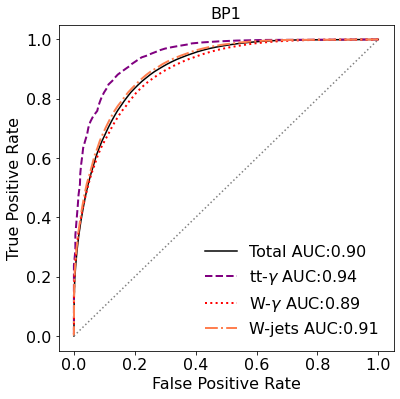

In [47]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)

plt.savefig('../graph/ROC_BP' + str(bp + 1) + '_All_MET200_new.png', bbox_inches='tight')

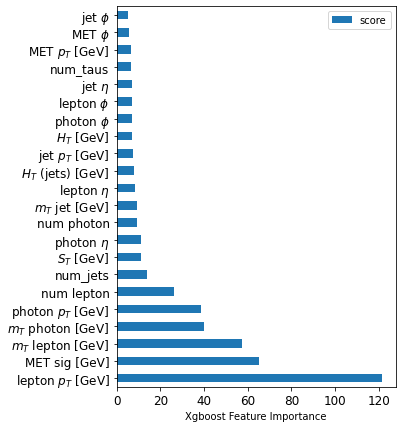

In [48]:
fig, ax = plt.subplots(figsize = (5,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1]])

plt.savefig('../graph/BP' + str(bp + 1) + '_featureImportance_All_MET200_new.png', bbox_inches='tight')

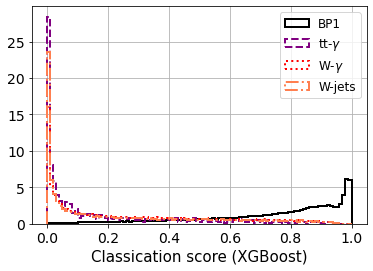

In [49]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('../graph/MLOutput_dist_BP' + str(bp + 1) + '_All_MET200_new.png', bbox_inches="tight")

In [50]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [51]:
len(np.where(bkg_flag_test != 0)[0])

52534

In [52]:
len(np.where(bkg_flag_test == 0)[0])

150768

In [53]:
S_expected[bp]

81.42521191306237

In [54]:
S_expected[bp] / np.sqrt(B_expected)

0.5043941787085761

In [55]:
print('MLL aproximated Z:')
print( MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, int(B_expected), int(S_expected[bp]))) 

MLL aproximated Z:
nan


/tmp/ipykernel_948935/1019789035.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return (f0 + fB + fS)**0.5


## Sequential selection criteria

In [65]:
nbins = 10
indices_aux = np.arange(len(df_test_array))

n_np0      = len(np.where(df_test_array[:, 22] == 0)[0])

n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[:, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[:, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[:, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[:, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[:, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[:, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[:, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[:, 22] == 11)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 2), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))
#random_vars = list(np.argsort(values)[::-1])*10

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    Z_sup = np.zeros(nbins)
    Z_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        n_np      = len(np.where(df_test_array[indices_sup, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_sup, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_sup, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_sup, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_sup, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_sup, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_sup, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_sup, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_sup, 22] == 11)[0])

        wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
  

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_sup[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_inf, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_inf, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_inf, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_inf, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_inf, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_inf, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_inf, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_inf, 22] == 11)[0])

        wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_inf[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut = np.argmax(np.asarray(Z))
    #print('Z = ' + str(Z[max_cut]))
    indices_aux = indices[max_cut]
    max_cut = np.argmax((Z_inf, Z_sup))
    if max_cut >= len(Z_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(Z_sup)]) + '; Z = ' + str(Z_sup[max_cut - len(Z_inf)]))
    #%    indices_aux = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cuts[max_cut - len(Z_sup)]) )[0]]
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(Z_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(Z_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; Z = ' + str(Z_inf[max_cut]))
    #%    indices_aux = indices_aux[np.where( (df_array[indices_aux,ivar] <= cuts[max_cut]) )[0]]
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux > 5) and (S_expected_aux > 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))

jet $\phi$ <= 3.142; Z = 0.5015024580945258
lepton $p_T$ [GeV] <= 184.92888888888888; Z = 0.5287798329355432
$H_T$ (jets) [GeV] <= 1460.7233333333334; Z = 0.5306488215443341
$H_T$ [GeV] <= 1885.6166666666666; Z = 0.5307969187940363
$m_T$ jet [GeV] >= 309.51592402834876; Z = 0.5320384972922035
lepton $\eta$ <= 2.5; Z = 0.5320384972922035
$m_T$ photon [GeV] <= 704.5140591374243; Z = 0.5331834601725303
photon $p_T$ [GeV] <= 178.73; Z = 0.5391227197397538
num_jets <= 5.888888888888889; Z = 0.541841863117784
jet $p_T$ [GeV] <= 1004.8433333333332; Z = 0.5421103723947178
lepton $\phi$ <= 3.142; Z = 0.5421103723947178
$S_T$ [GeV] <= 1171.2055555555555; Z = 0.5421775621148107
num lepton <= 2.0; Z = 0.5422313318722
MET $p_T$ [GeV] <= 1083.69; Z = 0.5422313318722
MET $\phi$ <= 3.142; Z = 0.5422313318722
jet $\eta$ <= 3.968; Z = 0.5422313318722
photon $\phi$ <= 3.142; Z = 0.5422313318722
MET sig [GeV] >= 10.377505423937784; Z = 0.5895834130524826
num photon <= 2.111111111111111; Z = 0.589583413052

In [67]:
sup_cuts

{'jet $\\phi$': 3.141,
 'lepton $p_T$ [GeV]': 48.51,
 '$H_T$ (jets) [GeV]': 839.0377777777778,
 '$H_T$ [GeV]': 1038.2044444444446,
 '$m_T$ jet [GeV]': 1379.3430548585216,
 'lepton $\\eta$': 2.499,
 '$m_T$ photon [GeV]': 171.40645475720046,
 'photon $p_T$ [GeV]': 161.88,
 'num_jets': 5.0,
 'jet $p_T$ [GeV]': 782.4177777777777,
 'lepton $\\phi$': 3.141,
 '$S_T$ [GeV]': 933.52,
 'num lepton': 1.0,
 'MET $p_T$ [GeV]': 1083.69,
 'MET $\\phi$': 3.141,
 'jet $\\eta$': 3.0524444444444443,
 'photon $\\phi$': 3.142,
 'MET sig [GeV]': 29.378304397739598,
 'num photon': 1.0,
 'photon $\\eta$': 2.367,
 'num_taus': 1.0,
 '$m_T$ lepton [GeV]': 173.3940303824013}

In [68]:
inf_cuts

{'jet $\\phi$': -999999,
 'lepton $p_T$ [GeV]': -999999,
 '$H_T$ (jets) [GeV]': -999999,
 '$H_T$ [GeV]': -999999,
 '$m_T$ jet [GeV]': 309.51592402834876,
 'lepton $\\eta$': -999999,
 '$m_T$ photon [GeV]': -999999,
 'photon $p_T$ [GeV]': 28.756666666666668,
 'num_jets': -999999,
 'jet $p_T$ [GeV]': -999999,
 'lepton $\\phi$': -999999,
 '$S_T$ [GeV]': -999999,
 'num lepton': 0.2222222222222222,
 'MET $p_T$ [GeV]': -999999,
 'MET $\\phi$': -999999,
 'jet $\\eta$': -999999,
 'photon $\\phi$': -999999,
 'MET sig [GeV]': 10.377505423937784,
 'num photon': -999999,
 'photon $\\eta$': -999999,
 'num_taus': -999999,
 '$m_T$ lepton [GeV]': 98.59276971998975}

In [69]:
write = True
if write:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_MET200_new.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_MET200_new.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_MET200_new.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_MET200_new.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

In [86]:
SM_test_pool = np.where(df_test_array[:,22] > 0)[0]
NP_test_pool = np.where(df_test_array[:,22] == 0)[0]

SM_indices = np.random.choice(SM_test_pool, size = int(B_expected), replace = False)
NP_indices = np.random.choice(NP_test_pool, size = int(S_expected[bp]), replace = False)
indices_aux = np.concatenate((NP_indices, SM_indices))

n_np0  = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma0  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

#indices_aux = np.arange(len(df_test_array))

variables = list(sup_cuts.keys())
for i in range(len(variables)):
    ind_var = np.where(df_test.columns == variables[i])[0][0]
    indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                            (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                           )[0]]


In [87]:

n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(n_ttgamma + n_wjets + n_wgamma + n_ttjets + \
                     n_zjets + n_wz + n_zz + n_ww + \
                     n_tj + n_tb + n_tw)
if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))



Z =  1.455265118722162
Expected Background = 44
Expected Signal = 10


In [88]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,22] > 0)[0]
NP_test_pool = np.where(df_test_array[:,22] == 0)[0]

q0_exp = np.zeros(nexperiments)
B_observed_exp = np.zeros(nexperiments)
S_observed_exp = np.zeros(nexperiments)
for nexp in tqdm(range(nexperiments)):
    # Let's create a pseudo-experiment
    SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
    NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
    indices_aux = np.concatenate((NP_indices, SM_indices))

    #%print('At the beggining')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')
    # Let's make the cuts

    variables = list(sup_cuts.keys())
    for i in range(len(variables)):
        #print(variables[i] + '<=' + str(sup_cuts[variables[i]]))
        #print(variables[i] + '>=' + str(inf_cuts[variables[i]]))
        ind_var = np.where(df_test.columns == variables[i])[0][0]
        indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                               )[0]]

        #%print('Total:' + str(len(indices_aux)))
        #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
        #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
        #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
        #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
        #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    # Let's calculate everything
    
    n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])
    
    n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
    n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
    n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
    n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
    n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
    n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
    n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
    n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
    n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
    n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
    n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

    #%print('At the end')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 22] == 0)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')

    #S_expected_aux = n_np
    S_observed_exp[nexp] = n_np

    # Formula discovery
    B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets + \
                           n_ttjets + n_zjets + n_wz + \
                           n_zz + n_ww + n_tj + \
                           n_tb + n_tw
        
    N_observed = n_np + n_ttgamma + n_wgamma + n_wjets+ \
                 n_ttjets + n_zjets + n_wz + \
                 n_zz + n_ww + n_tj + \
                 n_tb + n_tw
    
    if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
        q0_exp[nexp] = -2 * N_observed * np.log(B_expected_aux / N_observed) -2 * (N_observed - B_expected_aux)
        #Z_exp[nexp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
        #%print('\n')
        #%print('Z = ', Z_exp[nexp])
        #%print('Expected Background = ' + str(B_expected_aux))
        #%print('Expected Signal = ' + str(S_expected_aux))
    else:
        q0_exp[nexp] = -99
        #print('Expected Background = ' + str(B_observed_exp))
        #print('Expected Signal = ' + str(S_observed_exp))
    #%print('------------------------------------------')
        

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.20it/s]


(array([  2.,   0.,  68., 174., 337., 639., 444., 270.,  46.,  20.]),
 array([26. , 29.4, 32.8, 36.2, 39.6, 43. , 46.4, 49.8, 53.2, 56.6, 60. ]),
 <BarContainer object of 10 artists>)

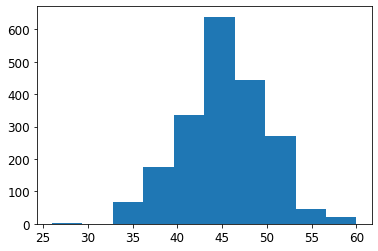

In [89]:
plt.hist(B_observed_exp)

(array([ 23., 144., 166., 529., 305., 498., 224.,  60.,  47.,   4.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

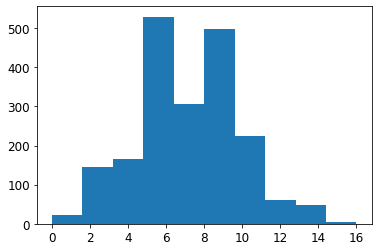

In [90]:
plt.hist(S_observed_exp)

In [91]:
np.mean(S_observed_exp /np.sqrt(B_observed_exp))

1.051228489175747

In [92]:
N_observed = S_observed_exp + B_observed_exp
-2 * N_observed * np.log(B_expected_aux / N_observed) -2 * (N_observed - B_expected_aux)


array([0.35309219, 0.35309219, 0.08956216, ..., 0.08956216, 3.01015036,
       2.54579064])

In [93]:
q0_exp

array([0.35309219, 0.35309219, 0.08956216, ..., 0.08956216, 3.01015036,
       2.54579064])

(array([1041.,  434.,  297.,  151.,   40.,   21.,   10.,    2.,    2.,
           2.]),
 array([ 0.        ,  1.49166139,  2.98332277,  4.47498416,  5.96664554,
         7.45830693,  8.94996831, 10.4416297 , 11.93329108, 13.42495247,
        14.91661385]),
 <BarContainer object of 10 artists>)

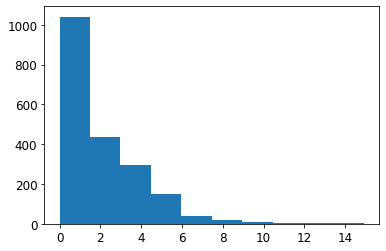

In [94]:
plt.hist(q0_exp)

In [95]:
print('Final results: for BP ' + str(bp+1) + '\n ')
print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))

Final results: for BP 1
 
Z = 1.1720174081340624; Z_std = 0.832208155232639
B_exp = 45.089; B_exp_std = 4.6803930390513155
S_exp = 7.028; S_exp_std = 2.6302501782149927


In [78]:
np.asarray(lst)[np.argsort(values)[::-1]][:4]

array(['lepton $p_T$ [GeV]', 'MET sig [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'], dtype='<U18')

In [226]:
imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]
imp_vars = np.array(['lepton $p_T$ [GeV]', 'MET sig [GeV]','$m_T$ lepton [GeV]', '$m_T$ photon [GeV]'])


In [227]:
imp_vars

array(['lepton $p_T$ [GeV]', 'MET sig [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'], dtype='<U18')

In [228]:
imp_vars_labels = ['$p_T^{\ell_{1}}$', '$E_T^{miss}/\sqrt{H_T}$',
                   '$m_T^{\ell_1}$','$m_T^{\gamma_1}$']

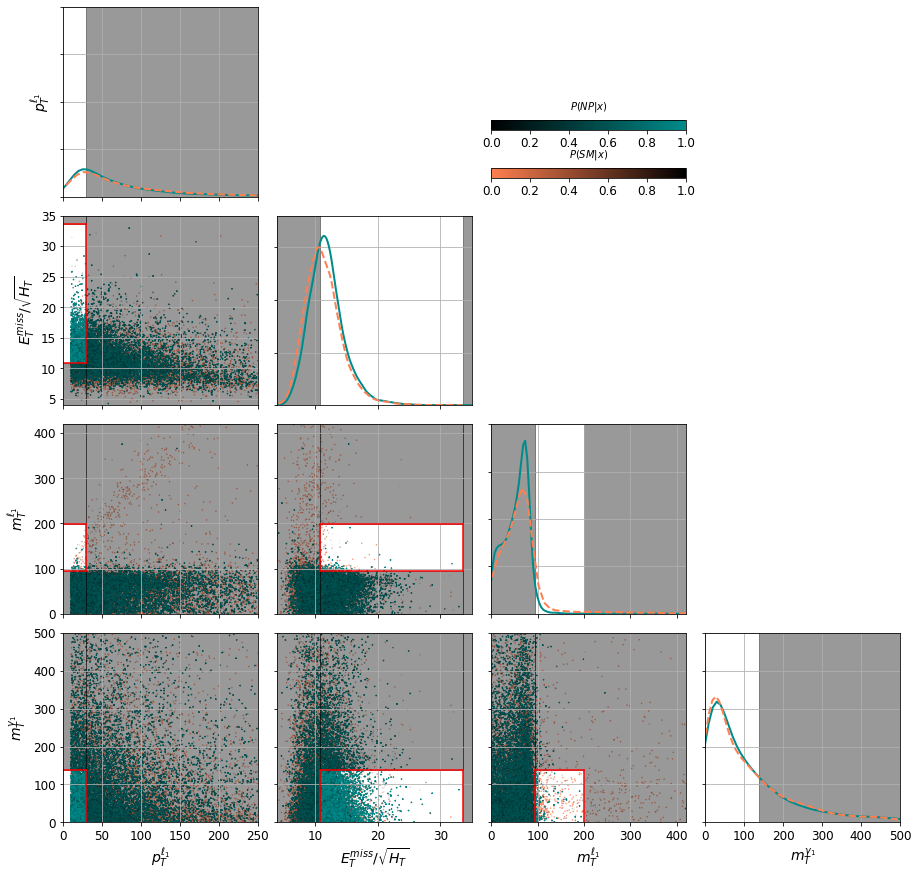

In [229]:
SM = df_test.loc[df_test['bkg_flag_pool'] != 0]
NP = df_test.loc[df_test['bkg_flag_pool'] == 1]

pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

rand_ind = np.random.choice(range(len(NP)), size =  10000, replace = False)
NP = NP.iloc[rand_ind]
pred_XG_NP = pred_XG_NP[rand_ind]

rand_ind = np.random.choice(range(len(SM)), size =  10000, replace = False)
SM = SM.iloc[rand_ind]
pred_XG_SM = pred_XG_SM[rand_ind]

limites = [[0,250], [4,35], [0,420], [0,500]]
ylimites = [[0,0.08], [0,0.18], [0,0.02], [0,0.01]]

fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = '--')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].set_ylim(ylimites[i])
            else:
                im_SM = ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 0.8, marker = '.', 
                                        c = pred_XG_SM, cmap = SM_cmap, vmin = 0, vmax = 1, alpha = (1-pred_XG_SM))
                im_NP = ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 0.8, marker = '*', 
                                        c = pred_XG_NP, cmap = NP_cmap, vmin = 0, vmax = 1, alpha = pred_XG_NP)
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(imp_vars_labels[0], fontsize = 14)
ax[3,1].set_xlabel(imp_vars_labels[1], fontsize = 14)
ax[3,2].set_xlabel(imp_vars_labels[2], fontsize = 14)
ax[3,3].set_xlabel(imp_vars_labels[3], fontsize = 14)

ax[0,0].set_ylabel(imp_vars_labels[0], fontsize = 14)
ax[1,0].set_ylabel(imp_vars_labels[1], fontsize = 14)
ax[2,0].set_ylabel(imp_vars_labels[2], fontsize = 14)
ax[3,0].set_ylabel(imp_vars_labels[3], fontsize = 14)

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])

cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal')
cbar_SM.set_label('$P(SM|x)$', labelpad=-50)
cbar_NP = plt.colorbar(im_NP, ax = ax[0,2], orientation = 'horizontal')
cbar_NP.set_label('$P(NP|x)$', labelpad=-50)

plt.savefig('../graph/BP' + str(bp+1) + '/ImpVars_dist_MET200_new.pdf')

## BinnedLikelihood

In [267]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(52534,)
(150768,)


In [268]:
B_expected = int(B_expected)

In [269]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, int(B_expected), range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  170 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  170
range of our data:  [[0, 1]]


In [270]:
# Z Poisson Bin Likelihood (Asimov data set)
D_or_E = 'discovery'
store_Z_asimov = []

Z_asimov = Z_BL_asimov(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), 25, range_dat, MIN_EVS, linear_bins=True) 
store_Z_asimov.append( Z_asimov )
    
    
print('\n FINAL RESULT for BP' + str(bp+1) + ':\n')
print(store_Z_asimov)


 FINAL RESULT for BP1:

[1.9802754647825263]


B_expected:  26060
S_expected:  81.42521191306237

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


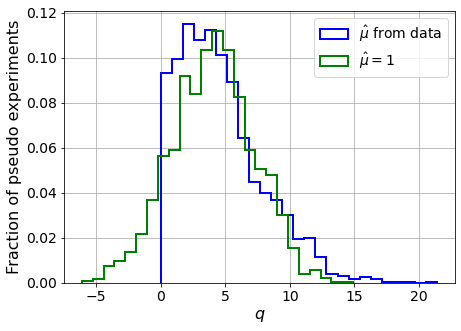

muhat mean:  1.035525
Z_bins:  2.021457591429074
std Z_bins:  0.8033443877974019
Z_bins mu=0:  2.021509496942973
std Z_bins mu=0:  0.7839002703248458

--------


 FINAL RESULT:

[[2.021457591429074, 0.8033443877974019, 1.035525, 2.021509496942973, 0.7839002703248458]]


In [271]:
# requested number of pseudo experiments
num_pseudo = 2000

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

B_expected:  26060
S_expected:  81.42521191306237

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


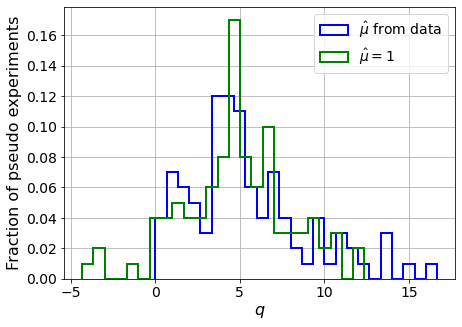

muhat mean:  1.1138028615043836
Z_bins:  2.1693719915624183
std Z_bins:  0.814109052769821
Z_bins mu=0:  2.1628347342081597
std Z_bins mu=0:  0.7458362692443263

--------


 FINAL RESULT:

[[2.1693719915624183, 0.814109052769821, 1.1138028615043836, 2.1628347342081597, 0.7458362692443263]]


In [272]:
# requested number of pseudo experiments
num_pseudo = 100

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

## loop pseudo exps. Fix ML and KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  2711.37220722
  2605.76672645  2471.96687306  2306.72883689  2125.62295396
  1898.01806677  1601.62075194  1251.22505673   832.27001277
   322.35403716  -285.61482491 -1023.87015973 -2093.690537  ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf


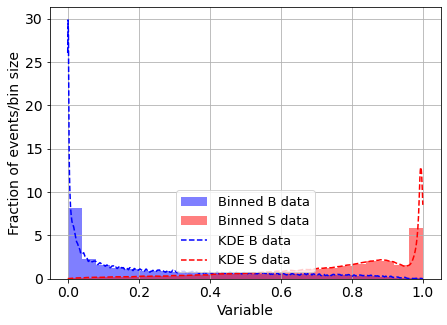

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.008287452507534925


In [175]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        20000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

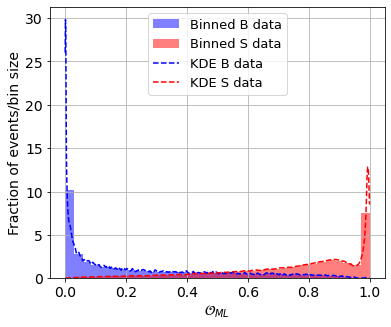

In [176]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,1000)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='blue',alpha=0.5, linewidth=2, label=r'Binned B data');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='red',alpha=0.5, linewidth=2, label=r'Binned S data');

plt.plot(s_vals, dens_bkg, color='blue',label=r'KDE B data',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='red',label=r'KDE S data',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale('log')
plt.xlabel("$\mathcal{O}_{ML}$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

plt.savefig('../graph/KDE_fit_BP' + str(bp+1) + '_MET200.pdf')

In [177]:
print(norm_factor_SM)
print(norm_factor_NP)

266.14753662758187
100.28423277903755


In [178]:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


In [179]:
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP
   

3 done
4 done


(array([58814., 60445.,  2955.,  2069.,  1720.,  1353.,  1268.,  3061.,
         5951., 13132.]),
 array([ 0.01698118,  1.30242448,  2.58786778,  3.87331107,  5.15875437,
         6.44419767,  7.72964097,  9.01508427, 10.30052756, 11.58597086,
        12.87141416]),
 [<matplotlib.patches.Polygon at 0x7efd5342bd60>])

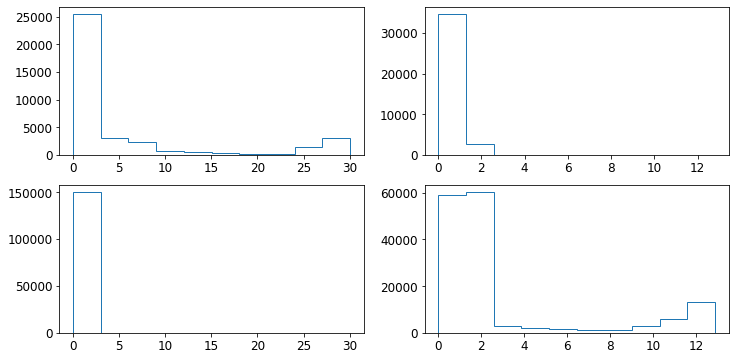

In [180]:
fig,ax = plt.subplots(2,2, figsize = (12,6))

ax[0,0].hist(pB_B_data, histtype = 'step')
ax[0,1].hist(pS_B_data, histtype = 'step')

ax[1,0].hist(pB_S_data, histtype = 'step')
ax[1,1].hist(pS_S_data, histtype = 'step')

In [181]:
# indeces (to later build a random pseudo experiment)
indices_B = [i for i in range(len(pS_B_data))]
indices_S = [i for i in range(len(pS_S_data))]
        
        

In [182]:
# loop over the number of pseudo experiments
#np.random.seed(91218)
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(3): 
    print(iloop)
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(200)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )
            
    

    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

0


  4%|██▋                                                                 | 8/200 [00:02<00:52,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3720336407504086
<p_{s}(Sdata)> = 2.964722663540827
<p_{b}(Bdata)> = 5.592528319237187
<p_{s}(Bdata)> = 0.40504091570382283


100%|██████████████████████████████████████████████████████████████████| 200/200 [00:58<00:00,  3.42it/s]


1


100%|██████████████████████████████████████████████████████████████████| 200/200 [01:02<00:00,  3.21it/s]


2


 48%|████████████████████████████████▏                                  | 96/200 [00:27<00:28,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5363417464870184
<p_{s}(Sdata)> = 2.1614090995550552
<p_{b}(Bdata)> = 5.595212159875739
<p_{s}(Bdata)> = 0.4057559256839425


 50%|█████████████████████████████████▏                                 | 99/200 [00:28<00:27,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5139697625411936
<p_{s}(Sdata)> = 2.532399185603165
<p_{b}(Bdata)> = 5.623472240825144
<p_{s}(Bdata)> = 0.4034399653275438


100%|██████████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.49it/s]


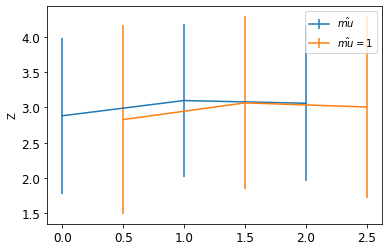

In [185]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP' + str(bp+1) + '_KDEfijo_MET200.pdf')

In [192]:
print('Z_MLL BP' + str(bp+1) + ': ' + str(np.mean(Z_MLL)) + ' +/- ' + str(np.std(Z_MLL))+
      ' +/- ' + str(np.mean(Z_MLL_std)))

Z_MLL BP1: 3.013632929980421 +/- 0.09409184220745251 +/- 1.098003789029043


## Loop varying KDE

In [ ]:
B_expected

In [ ]:
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20):
    print(iloop)
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(50)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_50000_KDEvariable__MET200.pdf')

## loop varying ML

In [56]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

0
AUC:0.9025711919374128
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


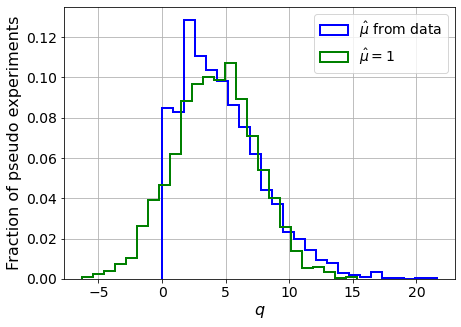

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  6991.47998866  6832.16128343  6626.98336161
  6363.65752802  6029.72693805  5625.80286008  5134.77238163
  4545.17675147  3818.43621224  2943.55706637  1888.72675073
   622.28548509  -892.43172381 -2704.88028291 -5296.95582782]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4230.53062447  4257.5251579   4269.5732485
 

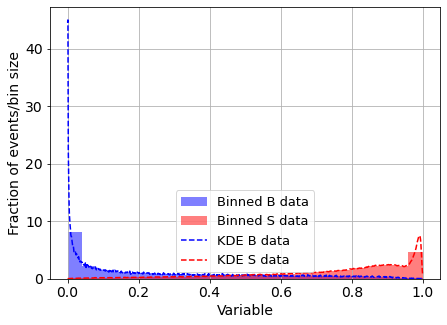

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.024546673193689687
0.024546673193689687
3 done
4 done
0.0
7.980590154794236e-06


  0%|▏                                                                 | 4/2000 [00:01<10:52,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4273281782911084
<p_{s}(Sdata)> = 2.05530470701574
<p_{b}(Bdata)> = 7.30473764156427
<p_{s}(Bdata)> = 0.4189752816159568


  1%|▋                                                                | 22/2000 [00:07<10:41,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40978512261100414
<p_{s}(Sdata)> = 1.9563913591683608
<p_{b}(Bdata)> = 7.042525444919464
<p_{s}(Bdata)> = 0.4214145164269905


  2%|█▏                                                               | 36/2000 [00:11<10:38,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46424269436769244
<p_{s}(Sdata)> = 1.5115444373717608
<p_{b}(Bdata)> = 7.2895724545932366
<p_{s}(Bdata)> = 0.41767757712339604


  4%|██▌                                                              | 79/2000 [00:25<10:49,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41921818246283526
<p_{s}(Sdata)> = 2.1027176674329073
<p_{b}(Bdata)> = 7.302273748378532
<p_{s}(Bdata)> = 0.41402612281594586


  6%|███▊                                                            | 121/2000 [00:39<11:08,  2.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.407742603956735
<p_{s}(Sdata)> = 2.2239650157732447
<p_{b}(Bdata)> = 7.26961384309423
<p_{s}(Bdata)> = 0.4170057101519335


  6%|████                                                            | 125/2000 [00:40<08:08,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.497699414525834
<p_{s}(Sdata)> = 1.7244602346534532
<p_{b}(Bdata)> = 7.274052580357642
<p_{s}(Bdata)> = 0.41925671565949013


  7%|████▍                                                           | 137/2000 [00:44<10:03,  3.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4624242969646868
<p_{s}(Sdata)> = 2.351761618719059
<p_{b}(Bdata)> = 7.254022923773643
<p_{s}(Bdata)> = 0.4274985424250446


  8%|█████▎                                                          | 167/2000 [00:54<08:19,  3.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37932894282680285
<p_{s}(Sdata)> = 2.077348270374101
<p_{b}(Bdata)> = 7.214381275642317
<p_{s}(Bdata)> = 0.4324493309367233


  9%|█████▋                                                          | 179/2000 [00:58<10:27,  2.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5088465503322085
<p_{s}(Sdata)> = 1.8738814935831005
<p_{b}(Bdata)> = 7.165683795293872
<p_{s}(Bdata)> = 0.4171217081850941


  9%|█████▉                                                          | 185/2000 [01:00<08:18,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3801022582967371
<p_{s}(Sdata)> = 2.1719339364617416
<p_{b}(Bdata)> = 7.162823017553429
<p_{s}(Bdata)> = 0.4173736012445375


 12%|███████▊                                                        | 245/2000 [01:19<09:59,  2.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44128111701161404
<p_{s}(Sdata)> = 1.980261919740918
<p_{b}(Bdata)> = 7.351680517437652
<p_{s}(Bdata)> = 0.4190188371934113


 13%|████████▎                                                       | 259/2000 [01:24<08:54,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4109312659305191
<p_{s}(Sdata)> = 2.1054908343975427
<p_{b}(Bdata)> = 7.161310395855275
<p_{s}(Bdata)> = 0.4207849175423456


 16%|██████████▍                                                     | 327/2000 [01:45<09:20,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4964262291330722
<p_{s}(Sdata)> = 1.8709896598804951
<p_{b}(Bdata)> = 7.124683153123172
<p_{s}(Bdata)> = 0.42306674596793764


 17%|██████████▊                                                     | 337/2000 [01:47<08:01,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5738521585036126
<p_{s}(Sdata)> = 1.6633305838210877
<p_{b}(Bdata)> = 7.332355097199811
<p_{s}(Bdata)> = 0.41958941768417995


 17%|██████████▉                                                     | 340/2000 [01:48<07:09,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.382496626434377
<p_{s}(Sdata)> = 2.291453193901624
<p_{b}(Bdata)> = 7.497695705843589
<p_{s}(Bdata)> = 0.4130782154951614


 18%|███████████▍                                                    | 356/2000 [01:54<09:32,  2.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4733201330328443
<p_{s}(Sdata)> = 1.6530884946949207
<p_{b}(Bdata)> = 7.207643273884656
<p_{s}(Bdata)> = 0.4199845304171673


 18%|███████████▊                                                    | 368/2000 [01:57<06:02,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4708396210253433
<p_{s}(Sdata)> = 1.861389821980955
<p_{b}(Bdata)> = 7.209302123288988
<p_{s}(Bdata)> = 0.4165549580258951


 19%|████████████▏                                                   | 381/2000 [02:00<04:53,  5.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42385499698102463
<p_{s}(Sdata)> = 2.1931576562397495
<p_{b}(Bdata)> = 7.247530220762836
<p_{s}(Bdata)> = 0.41627330794171385


 20%|████████████▊                                                   | 401/2000 [02:06<06:46,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4328106111632518
<p_{s}(Sdata)> = 1.9429985193069643
<p_{b}(Bdata)> = 7.227387584136769
<p_{s}(Bdata)> = 0.42028482528791


 21%|█████████████▎                                                  | 417/2000 [02:12<08:14,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40047465379411984
<p_{s}(Sdata)> = 2.1123421949022902
<p_{b}(Bdata)> = 7.244398091977012
<p_{s}(Bdata)> = 0.41308550138381595


 21%|█████████████▍                                                  | 419/2000 [02:12<06:59,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4902997073461042
<p_{s}(Sdata)> = 1.9150840160892662
<p_{b}(Bdata)> = 7.26436582478108
<p_{s}(Bdata)> = 0.41808946897367266


 23%|██████████████▊                                                 | 463/2000 [02:25<08:32,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42813301722893743
<p_{s}(Sdata)> = 1.9653986441222622
<p_{b}(Bdata)> = 7.23090552300476
<p_{s}(Bdata)> = 0.41940930563279977


 23%|██████████████▉                                                 | 467/2000 [02:27<09:21,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41784148822382733
<p_{s}(Sdata)> = 2.048952066424292
<p_{b}(Bdata)> = 7.195292108779401
<p_{s}(Bdata)> = 0.416140702326772


 27%|█████████████████▏                                              | 538/2000 [02:49<07:19,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43731627508927373
<p_{s}(Sdata)> = 2.0936271307362193
<p_{b}(Bdata)> = 7.313327738416806
<p_{s}(Bdata)> = 0.41432016164630375


 27%|█████████████████▌                                              | 548/2000 [02:53<08:28,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3585605382668698
<p_{s}(Sdata)> = 2.2386609250947305
<p_{b}(Bdata)> = 7.243449541788123
<p_{s}(Bdata)> = 0.4120456014720611


 28%|█████████████████▌                                              | 550/2000 [02:53<06:35,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4862680005924356
<p_{s}(Sdata)> = 1.9605205506910497
<p_{b}(Bdata)> = 7.23834270774522
<p_{s}(Bdata)> = 0.42200128744135434


 28%|█████████████████▊                                              | 557/2000 [02:55<07:28,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3883464047760687
<p_{s}(Sdata)> = 2.057629240853884
<p_{b}(Bdata)> = 7.078505360528056
<p_{s}(Bdata)> = 0.4229981887783347


 29%|██████████████████▍                                             | 577/2000 [03:02<08:08,  2.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44634911514128045
<p_{s}(Sdata)> = 2.0292425195056105
<p_{b}(Bdata)> = 7.157432092121316
<p_{s}(Bdata)> = 0.42005989611098277


 30%|███████████████████▎                                            | 603/2000 [03:09<05:02,  4.63it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4201988529022924
<p_{s}(Sdata)> = 2.3084688891771328
<p_{b}(Bdata)> = 7.189259517717101
<p_{s}(Bdata)> = 0.42538391546673743


 30%|███████████████████▍                                            | 607/2000 [03:10<06:26,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4661657616729014
<p_{s}(Sdata)> = 1.8742367509296947
<p_{b}(Bdata)> = 7.2353091756912145
<p_{s}(Bdata)> = 0.4155151101098108


 32%|████████████████████▏                                           | 631/2000 [03:17<06:15,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3918430182949521
<p_{s}(Sdata)> = 2.007233565031301
<p_{b}(Bdata)> = 7.182295337826085
<p_{s}(Bdata)> = 0.4205335311310634


 35%|██████████████████████▌                                         | 707/2000 [03:42<08:08,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4148295336911131
<p_{s}(Sdata)> = 1.8705824383963092
<p_{b}(Bdata)> = 7.216037505030536
<p_{s}(Bdata)> = 0.417530169861085


 36%|███████████████████████                                         | 720/2000 [03:45<05:05,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4299053468292232
<p_{s}(Sdata)> = 2.186395327386453
<p_{b}(Bdata)> = 7.403917995544893
<p_{s}(Bdata)> = 0.4117502169009132


 38%|████████████████████████▏                                       | 755/2000 [03:56<05:16,  3.94it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.40464154997537527
<p_{s}(Sdata)> = 2.2525895117615105
<p_{b}(Bdata)> = 7.198165729998658
<p_{s}(Bdata)> = 0.42552727680082164


 38%|████████████████████████▍                                       | 765/2000 [03:59<05:00,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4631688413925726
<p_{s}(Sdata)> = 1.707825973825576
<p_{b}(Bdata)> = 7.240729047165883
<p_{s}(Bdata)> = 0.420114494355188


 42%|███████████████████████████                                     | 847/2000 [04:25<05:29,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41573512422963976
<p_{s}(Sdata)> = 2.0071871369523735
<p_{b}(Bdata)> = 7.151086880093368
<p_{s}(Bdata)> = 0.42196321244949814


 44%|████████████████████████████▎                                   | 884/2000 [04:36<05:44,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46834584053573913
<p_{s}(Sdata)> = 1.8724922511467348
<p_{b}(Bdata)> = 7.228791924058481
<p_{s}(Bdata)> = 0.4179847525436571


 46%|█████████████████████████████▏                                  | 912/2000 [04:44<04:55,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5994216243312235
<p_{s}(Sdata)> = 1.7251602529097427
<p_{b}(Bdata)> = 7.183778016536942
<p_{s}(Bdata)> = 0.4172923160787094


 46%|█████████████████████████████▍                                  | 920/2000 [04:47<07:03,  2.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5334893093305855
<p_{s}(Sdata)> = 1.871088320440033
<p_{b}(Bdata)> = 7.358182066328754
<p_{s}(Bdata)> = 0.4215903271631079


 46%|█████████████████████████████▋                                  | 927/2000 [04:49<04:25,  4.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37664367478159694
<p_{s}(Sdata)> = 2.073674630893054
<p_{b}(Bdata)> = 7.09550865554387
<p_{s}(Bdata)> = 0.4325018697242761


 48%|██████████████████████████████▍                                 | 950/2000 [04:56<05:39,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42631474569320066
<p_{s}(Sdata)> = 2.150232296209178
<p_{b}(Bdata)> = 7.335684725434706
<p_{s}(Bdata)> = 0.4132290619186156


 49%|███████████████████████████████▌                                | 985/2000 [05:06<04:43,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3954327920576788
<p_{s}(Sdata)> = 2.214861739050823
<p_{b}(Bdata)> = 7.214831267606851
<p_{s}(Bdata)> = 0.41202642601644274


 51%|████████████████████████████████▍                              | 1028/2000 [05:19<05:30,  2.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41471014061864164
<p_{s}(Sdata)> = 1.8381622590487907
<p_{b}(Bdata)> = 7.149297857201234
<p_{s}(Bdata)> = 0.42103176414291915


 52%|████████████████████████████████▉                              | 1046/2000 [05:24<04:54,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4860796881059932
<p_{s}(Sdata)> = 1.9710805337691628
<p_{b}(Bdata)> = 7.1938538672040195
<p_{s}(Bdata)> = 0.4176323700445797


 54%|█████████████████████████████████▋                             | 1070/2000 [05:30<02:45,  5.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.374803974443836
<p_{s}(Sdata)> = 2.3670071793147476
<p_{b}(Bdata)> = 7.061716149885755
<p_{s}(Bdata)> = 0.4338004179983594


 55%|██████████████████████████████████▍                            | 1093/2000 [05:37<05:02,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49045153065529434
<p_{s}(Sdata)> = 1.950394573081515
<p_{b}(Bdata)> = 7.312466820897186
<p_{s}(Bdata)> = 0.4157258068194145


 56%|███████████████████████████████████                            | 1113/2000 [05:43<04:28,  3.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40273171635482413
<p_{s}(Sdata)> = 2.0218352974286216
<p_{b}(Bdata)> = 7.161984807351636
<p_{s}(Bdata)> = 0.419629006075798


 56%|███████████████████████████████████▎                           | 1121/2000 [05:45<03:06,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49517444412681505
<p_{s}(Sdata)> = 1.7543711439415235
<p_{b}(Bdata)> = 7.177248540675456
<p_{s}(Bdata)> = 0.4205376960043696


 56%|███████████████████████████████████▌                           | 1127/2000 [05:47<04:36,  3.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.39420923737293184
<p_{s}(Sdata)> = 2.384398100444364
<p_{b}(Bdata)> = 7.2232565565035936
<p_{s}(Bdata)> = 0.42604343797431177


 58%|████████████████████████████████████▋                          | 1163/2000 [05:58<05:07,  2.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.491025474027247
<p_{s}(Sdata)> = 1.6216960279478698
<p_{b}(Bdata)> = 7.1233338886669335
<p_{s}(Bdata)> = 0.4207136266726064


 59%|█████████████████████████████████████▏                         | 1182/2000 [06:04<04:44,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42611862169074094
<p_{s}(Sdata)> = 1.973386282038218
<p_{b}(Bdata)> = 7.373028809827633
<p_{s}(Bdata)> = 0.4154637719959593


 61%|██████████████████████████████████████▋                        | 1228/2000 [06:18<04:19,  2.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5591006279613856
<p_{s}(Sdata)> = 1.8840012239948303
<p_{b}(Bdata)> = 7.182518578964828
<p_{s}(Bdata)> = 0.4213908218551661


 62%|██████████████████████████████████████▊                        | 1233/2000 [06:19<04:05,  3.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.34449672445336543
<p_{s}(Sdata)> = 2.5984149331841153
<p_{b}(Bdata)> = 7.102643714024458
<p_{s}(Bdata)> = 0.42931410544462484


 62%|███████████████████████████████████████▏                       | 1243/2000 [06:22<03:29,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4310495278550377
<p_{s}(Sdata)> = 1.8492475924731473
<p_{b}(Bdata)> = 7.266614978760283
<p_{s}(Bdata)> = 0.41756865066088955


 63%|███████████████████████████████████████▉                       | 1267/2000 [06:30<03:07,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48860589334489796
<p_{s}(Sdata)> = 1.6690045491516305
<p_{b}(Bdata)> = 7.245222950459093
<p_{s}(Bdata)> = 0.41913541835553053


 64%|████████████████████████████████████████                       | 1273/2000 [06:32<04:21,  2.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4183104371069986
<p_{s}(Sdata)> = 1.9014670906670603
<p_{b}(Bdata)> = 7.3193701449349
<p_{s}(Bdata)> = 0.41963704819998443


 64%|████████████████████████████████████████▎                      | 1280/2000 [06:34<03:55,  3.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4459020602425113
<p_{s}(Sdata)> = 1.851209551831248
<p_{b}(Bdata)> = 7.1419016888349605
<p_{s}(Bdata)> = 0.4173791242037416


 65%|████████████████████████████████████████▉                      | 1300/2000 [06:40<02:26,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37887007146219853
<p_{s}(Sdata)> = 2.283734810665452
<p_{b}(Bdata)> = 7.253734403400939
<p_{s}(Bdata)> = 0.4187427945955571


 66%|█████████████████████████████████████████▋                     | 1322/2000 [06:47<03:32,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40773163062230366
<p_{s}(Sdata)> = 2.0229787147923766
<p_{b}(Bdata)> = 7.152105558099195
<p_{s}(Bdata)> = 0.4201881193261726


 66%|█████████████████████████████████████████▋                     | 1324/2000 [06:47<03:08,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4166579027209242
<p_{s}(Sdata)> = 1.9455101377589907
<p_{b}(Bdata)> = 7.39244421128596
<p_{s}(Bdata)> = 0.416609233332259


 68%|██████████████████████████████████████████▌                    | 1350/2000 [06:56<03:14,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40329895580125036
<p_{s}(Sdata)> = 2.273565657310531
<p_{b}(Bdata)> = 7.238302071861457
<p_{s}(Bdata)> = 0.41763142824223143


 68%|██████████████████████████████████████████▋                    | 1354/2000 [06:57<03:28,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4706927598296678
<p_{s}(Sdata)> = 1.7390611427858405
<p_{b}(Bdata)> = 7.35638183213417
<p_{s}(Bdata)> = 0.4156738556288406


 69%|███████████████████████████████████████████▋                   | 1385/2000 [07:06<03:22,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4226933190526436
<p_{s}(Sdata)> = 2.0236011315397406
<p_{b}(Bdata)> = 7.317291000499889
<p_{s}(Bdata)> = 0.41793272328603875


 70%|███████████████████████████████████████████▉                   | 1394/2000 [07:09<03:15,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4635696300964901
<p_{s}(Sdata)> = 2.1116672437327866
<p_{b}(Bdata)> = 7.232057521799619
<p_{s}(Bdata)> = 0.41533822307528623


 70%|████████████████████████████████████████████▏                  | 1403/2000 [07:11<03:06,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4347650272335056
<p_{s}(Sdata)> = 1.9989354639466868
<p_{b}(Bdata)> = 7.229132639329591
<p_{s}(Bdata)> = 0.4210692781867116


 71%|████████████████████████████████████████████▌                  | 1414/2000 [07:15<03:08,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5427805086784973
<p_{s}(Sdata)> = 1.7207287497730728
<p_{b}(Bdata)> = 7.325065554641439
<p_{s}(Bdata)> = 0.41936786685079874


 74%|██████████████████████████████████████████████▎                | 1470/2000 [07:31<02:26,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5521302285395598
<p_{s}(Sdata)> = 1.8584993101344223
<p_{b}(Bdata)> = 7.0684796111073505
<p_{s}(Bdata)> = 0.41730961825642315


 75%|███████████████████████████████████████████████▌               | 1509/2000 [07:42<01:47,  4.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4103066588874845
<p_{s}(Sdata)> = 2.0630858741780154
<p_{b}(Bdata)> = 7.234713162650282
<p_{s}(Bdata)> = 0.41353613323849525


 77%|████████████████████████████████████████████████▍              | 1537/2000 [07:51<02:19,  3.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46136563634166794
<p_{s}(Sdata)> = 1.9908567415443557
<p_{b}(Bdata)> = 7.1918299813897635
<p_{s}(Bdata)> = 0.414008487460307


 79%|█████████████████████████████████████████████████▌             | 1573/2000 [08:01<01:57,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4271836848960372
<p_{s}(Sdata)> = 2.0420448488990792
<p_{b}(Bdata)> = 7.277845673502367
<p_{s}(Bdata)> = 0.41786678600906235


 79%|█████████████████████████████████████████████████▊             | 1583/2000 [08:05<02:16,  3.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4403304119071301
<p_{s}(Sdata)> = 1.7389120281214718
<p_{b}(Bdata)> = 7.201148762331995
<p_{s}(Bdata)> = 0.41718915643476384


 80%|██████████████████████████████████████████████████▏            | 1592/2000 [08:07<01:49,  3.74it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.46866475700924465
<p_{s}(Sdata)> = 2.175945586856378
<p_{b}(Bdata)> = 7.202632715924975
<p_{s}(Bdata)> = 0.4294978385463268


 80%|██████████████████████████████████████████████████▋            | 1609/2000 [08:13<01:51,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42410273564407186
<p_{s}(Sdata)> = 1.9721267922400183
<p_{b}(Bdata)> = 7.196704550848524
<p_{s}(Bdata)> = 0.41904659356363505


 81%|██████████████████████████████████████████████████▉            | 1618/2000 [08:16<01:56,  3.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40177983906276016
<p_{s}(Sdata)> = 1.8763325465685772
<p_{b}(Bdata)> = 7.23034875455913
<p_{s}(Bdata)> = 0.4207501536360135


 81%|███████████████████████████████████████████████████            | 1620/2000 [08:16<01:30,  4.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42581842209840903
<p_{s}(Sdata)> = 1.9698222390001447
<p_{b}(Bdata)> = 7.169166732349277
<p_{s}(Bdata)> = 0.4166569051165623


 81%|███████████████████████████████████████████████████▎           | 1627/2000 [08:18<02:16,  2.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40720754129325987
<p_{s}(Sdata)> = 1.9988070292078757
<p_{b}(Bdata)> = 7.013379165289699
<p_{s}(Bdata)> = 0.4211336865273037


 82%|███████████████████████████████████████████████████▌           | 1638/2000 [08:21<01:27,  4.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4536938738192969
<p_{s}(Sdata)> = 1.6344271114572937
<p_{b}(Bdata)> = 7.255857421210108
<p_{s}(Bdata)> = 0.4221477803813198


 82%|███████████████████████████████████████████████████▊           | 1645/2000 [08:23<01:34,  3.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4470461882828458
<p_{s}(Sdata)> = 1.7565279014908017
<p_{b}(Bdata)> = 7.268539085301043
<p_{s}(Bdata)> = 0.41993610640348206


 87%|██████████████████████████████████████████████████████▌        | 1733/2000 [08:52<01:33,  2.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41179579601690763
<p_{s}(Sdata)> = 1.8602791721201302
<p_{b}(Bdata)> = 7.22955240372613
<p_{s}(Bdata)> = 0.4216141130584711


 88%|███████████████████████████████████████████████████████▍       | 1760/2000 [08:59<01:09,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4057931894708065
<p_{s}(Sdata)> = 2.0908568857088174
<p_{b}(Bdata)> = 7.1334147479269925
<p_{s}(Bdata)> = 0.4191719276607588


 89%|████████████████████████████████████████████████████████       | 1780/2000 [09:05<01:00,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.497303595294393
<p_{s}(Sdata)> = 1.9201096746668282
<p_{b}(Bdata)> = 7.309500235664426
<p_{s}(Bdata)> = 0.41515222534448576


 90%|████████████████████████████████████████████████████████▌      | 1794/2000 [09:09<01:03,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3759484074632161
<p_{s}(Sdata)> = 2.202228544911845
<p_{b}(Bdata)> = 7.2597550343556865
<p_{s}(Bdata)> = 0.41604118906646775


 92%|█████████████████████████████████████████████████████████▋     | 1832/2000 [09:21<00:49,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49094736430303926
<p_{s}(Sdata)> = 2.138401590532262
<p_{b}(Bdata)> = 7.298640020880574
<p_{s}(Bdata)> = 0.4154821947693585


 94%|██████████████████████████████████████████████████████████▉    | 1873/2000 [09:33<00:26,  4.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4422610008141516
<p_{s}(Sdata)> = 1.8709154979610962
<p_{b}(Bdata)> = 7.289747212628324
<p_{s}(Bdata)> = 0.41570769083362435


 94%|███████████████████████████████████████████████████████████▍   | 1886/2000 [09:37<00:35,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43800679324425784
<p_{s}(Sdata)> = 2.012613152871203
<p_{b}(Bdata)> = 7.0124376335038985
<p_{s}(Bdata)> = 0.4235908162466215


 95%|███████████████████████████████████████████████████████████▌   | 1891/2000 [09:38<00:27,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45815666615738543
<p_{s}(Sdata)> = 1.9907115801922508
<p_{b}(Bdata)> = 7.081999415144556
<p_{s}(Bdata)> = 0.4198987969809721


 95%|███████████████████████████████████████████████████████████▋   | 1895/2000 [09:39<00:32,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4237547890044562
<p_{s}(Sdata)> = 1.8596368158837069
<p_{b}(Bdata)> = 7.318269638221786
<p_{s}(Bdata)> = 0.42003890508454733


 96%|████████████████████████████████████████████████████████████▌  | 1922/2000 [09:48<00:24,  3.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4159394297628168
<p_{s}(Sdata)> = 2.025220154683847
<p_{b}(Bdata)> = 7.287395064797356
<p_{s}(Bdata)> = 0.4134763341707281


 96%|████████████████████████████████████████████████████████████▌  | 1924/2000 [09:48<00:19,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4004098305454701
<p_{s}(Sdata)> = 2.0007936861740694
<p_{b}(Bdata)> = 7.272568655923404
<p_{s}(Bdata)> = 0.4168865457604085


 99%|██████████████████████████████████████████████████████████████ | 1971/2000 [10:02<00:05,  4.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6536722389246464
<p_{s}(Sdata)> = 1.5908781853133505
<p_{b}(Bdata)> = 7.190877913613865
<p_{s}(Bdata)> = 0.4127113809914836


100%|██████████████████████████████████████████████████████████████▋| 1990/2000 [10:08<00:02,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4112812772274738
<p_{s}(Sdata)> = 1.925020549364807
<p_{b}(Bdata)> = 7.1743911079398
<p_{s}(Bdata)> = 0.4182733228530776


100%|███████████████████████████████████████████████████████████████| 2000/2000 [10:11<00:00,  3.27it/s]


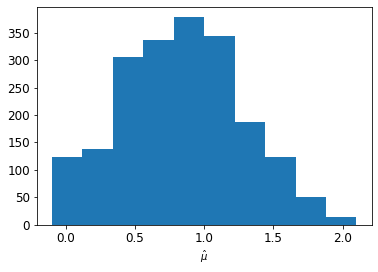

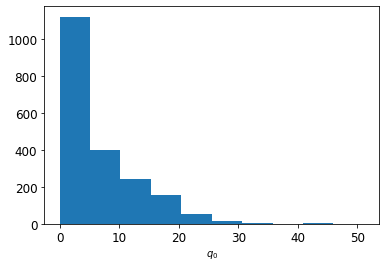

Z BL:(2.053044471423333, 0.7957544107600786, 1.0247, 2.054744714601037, 0.7854905928283415)
Z:2.0802619545476064
Z_std:1.5827623502436199
Z_1:2.0551652823340816
Z_std_1:1.7450668550656399
1
AUC:0.9027704917383614
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

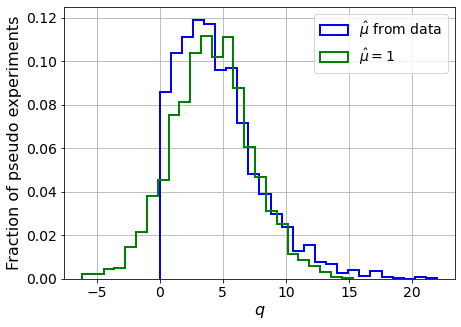

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  7026.91105298  6814.61346196
  6538.34744659  6190.95029623  5770.445745    5261.25941967
  4646.10916447  3886.38050115  2980.88790147  1909.68938587
   624.3410809   -900.85566917 -2732.87728354 -5310.78602933]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4298.77790764  4303.10928151


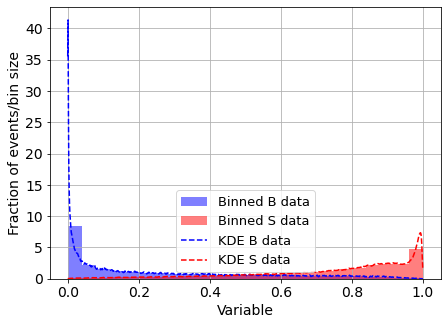

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.011127622378013981
0.011127622378013981
3 done
4 done
0.002828373081161218
0.002828373081161218


  2%|█                                                                | 32/2000 [00:09<09:33,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43001033773426833
<p_{s}(Sdata)> = 1.9812817889104366
<p_{b}(Bdata)> = 6.8263774199854845
<p_{s}(Bdata)> = 0.4148353701846189


  3%|█▋                                                               | 51/2000 [00:14<06:11,  5.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.418345951228401
<p_{s}(Sdata)> = 1.9837427497075786
<p_{b}(Bdata)> = 6.8125601406568
<p_{s}(Bdata)> = 0.41735672223956244
muhat = -0.1
<p_{b}(Sdata)> = 0.4417886488773278
<p_{s}(Sdata)> = 1.8928282452470135
<p_{b}(Bdata)> = 6.931266261209605
<p_{s}(Bdata)> = 0.41503974251970477


  4%|██▉                                                              | 89/2000 [00:24<05:41,  5.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5047690503646949
<p_{s}(Sdata)> = 1.7955843242866183
<p_{b}(Bdata)> = 6.806920500876614
<p_{s}(Bdata)> = 0.4148653158886733
muhat = -0.1
<p_{b}(Sdata)> = 0.4854264833842141
<p_{s}(Sdata)> = 1.5806989936857716
<p_{b}(Bdata)> = 6.86403638873978
<p_{s}(Bdata)> = 0.417116571738917


  5%|███                                                              | 94/2000 [00:26<08:09,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5128350723427932
<p_{s}(Sdata)> = 1.77051764532077
<p_{b}(Bdata)> = 6.763091426482764
<p_{s}(Bdata)> = 0.4190223024678139


  8%|████▊                                                           | 152/2000 [00:43<09:11,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.408475075006945
<p_{s}(Sdata)> = 2.0249474713404654
<p_{b}(Bdata)> = 6.851596594879556
<p_{s}(Bdata)> = 0.41693166715456775


  8%|████▉                                                           | 155/2000 [00:43<07:41,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3774212188232119
<p_{s}(Sdata)> = 2.2076004221202457
<p_{b}(Bdata)> = 6.799753886235173
<p_{s}(Bdata)> = 0.4180430270479275


  8%|█████                                                           | 159/2000 [00:44<06:49,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42003223755723473
<p_{s}(Sdata)> = 2.3092847641214242
<p_{b}(Bdata)> = 6.823626601117509
<p_{s}(Bdata)> = 0.41256007854444166


 11%|███████▏                                                        | 224/2000 [01:03<08:26,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43218343747274807
<p_{s}(Sdata)> = 2.0106715112021574
<p_{b}(Bdata)> = 6.786557614588449
<p_{s}(Bdata)> = 0.4157382573929421


 13%|████████▌                                                       | 266/2000 [01:16<09:38,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4079185765430635
<p_{s}(Sdata)> = 1.8700842194206724
<p_{b}(Bdata)> = 6.863896968192124
<p_{s}(Bdata)> = 0.4223664077477682


 15%|█████████▎                                                      | 292/2000 [01:23<08:36,  3.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47675736020845505
<p_{s}(Sdata)> = 1.8615397360232666
<p_{b}(Bdata)> = 6.7672000637484695
<p_{s}(Bdata)> = 0.4211603648305932


 16%|█████████▉                                                      | 311/2000 [01:29<10:16,  2.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37485159772562254
<p_{s}(Sdata)> = 2.212687937509977
<p_{b}(Bdata)> = 6.894089579440059
<p_{s}(Bdata)> = 0.41616937489026573


 18%|███████████▊                                                    | 370/2000 [01:47<06:09,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4076871105978429
<p_{s}(Sdata)> = 2.134876358563028
<p_{b}(Bdata)> = 6.82785088187792
<p_{s}(Bdata)> = 0.41867160382098134


 19%|████████████▎                                                   | 385/2000 [01:51<09:26,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5572392142243017
<p_{s}(Sdata)> = 2.034548697313526
<p_{b}(Bdata)> = 6.79508350005645
<p_{s}(Bdata)> = 0.4132292631240982


 20%|████████████▌                                                   | 391/2000 [01:52<07:24,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39882656866392974
<p_{s}(Sdata)> = 2.09425035545474
<p_{b}(Bdata)> = 6.655222423635631
<p_{s}(Bdata)> = 0.41770778739127784


 23%|██████████████▍                                                 | 453/2000 [02:10<05:16,  4.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.427492977442429
<p_{s}(Sdata)> = 1.9629068652037396
<p_{b}(Bdata)> = 6.920336259038816
<p_{s}(Bdata)> = 0.423240997187753


 23%|██████████████▉                                                 | 466/2000 [02:14<05:45,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4553507162128365
<p_{s}(Sdata)> = 1.8719506607965757
<p_{b}(Bdata)> = 6.749155309690883
<p_{s}(Bdata)> = 0.41498705821878273


 26%|████████████████▋                                               | 523/2000 [02:30<06:05,  4.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40780907893151813
<p_{s}(Sdata)> = 2.165706952433451
<p_{b}(Bdata)> = 6.738185819168109
<p_{s}(Bdata)> = 0.4145921351691313


 27%|████████████████▉                                               | 531/2000 [02:32<06:43,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4047878976323655
<p_{s}(Sdata)> = 2.059660704155513
<p_{b}(Bdata)> = 6.875139863463707
<p_{s}(Bdata)> = 0.41968621803990974


 29%|██████████████████▎                                             | 571/2000 [02:43<06:46,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41305799224782647
<p_{s}(Sdata)> = 2.022340428415861
<p_{b}(Bdata)> = 6.819276404826653
<p_{s}(Bdata)> = 0.41216589506269136


 31%|███████████████████▋                                            | 617/2000 [02:55<06:59,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4322549834149336
<p_{s}(Sdata)> = 2.0878245689837684
<p_{b}(Bdata)> = 6.804956312705495
<p_{s}(Bdata)> = 0.4148155760506362


 31%|████████████████████                                            | 625/2000 [02:57<06:30,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44443620007710083
<p_{s}(Sdata)> = 2.110364367363825
<p_{b}(Bdata)> = 6.755783060969799
<p_{s}(Bdata)> = 0.42158370354279356


 36%|███████████████████████                                         | 721/2000 [03:25<04:44,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5400860188317504
<p_{s}(Sdata)> = 1.7935684660535443
<p_{b}(Bdata)> = 6.787410519070974
<p_{s}(Bdata)> = 0.4145968236555965


 38%|████████████████████████▎                                       | 761/2000 [03:37<05:36,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3882344083591643
<p_{s}(Sdata)> = 2.222803941416103
<p_{b}(Bdata)> = 6.913136011453284
<p_{s}(Bdata)> = 0.4151707392477182


 41%|██████████████████████████                                      | 815/2000 [03:53<06:14,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39753940106765095
<p_{s}(Sdata)> = 2.090043659333551
<p_{b}(Bdata)> = 6.837391743796059
<p_{s}(Bdata)> = 0.4208782696818022


 43%|███████████████████████████▍                                    | 858/2000 [04:05<04:38,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4049931275776685
<p_{s}(Sdata)> = 2.0243252145328463
<p_{b}(Bdata)> = 6.8272930661704185
<p_{s}(Bdata)> = 0.41236756676313485


 45%|████████████████████████████▌                                   | 894/2000 [04:15<05:46,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8256008404080044
<p_{s}(Sdata)> = 2.050542316784754
<p_{b}(Bdata)> = 6.967259138059865
<p_{s}(Bdata)> = 0.41528752853824674


 46%|█████████████████████████████▍                                  | 919/2000 [04:22<05:24,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4390869310619155
<p_{s}(Sdata)> = 2.352739547260242
<p_{b}(Bdata)> = 6.820564146877719
<p_{s}(Bdata)> = 0.4169691992098102


 47%|█████████████████████████████▊                                  | 931/2000 [04:26<05:52,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4628923500744302
<p_{s}(Sdata)> = 1.7973921867340752
<p_{b}(Bdata)> = 6.695846298934213
<p_{s}(Bdata)> = 0.4239821051589022


 47%|██████████████████████████████                                  | 939/2000 [04:28<05:18,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37492194049123195
<p_{s}(Sdata)> = 2.1680487985159353
<p_{b}(Bdata)> = 6.720473941351229
<p_{s}(Bdata)> = 0.4198912253555384


 47%|██████████████████████████████▏                                 | 943/2000 [04:29<05:47,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.457775901973081
<p_{s}(Sdata)> = 1.9295630810131248
<p_{b}(Bdata)> = 6.81669371046659
<p_{s}(Bdata)> = 0.41659377016389676


 48%|██████████████████████████████▍                                 | 952/2000 [04:32<04:09,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45245785175806075
<p_{s}(Sdata)> = 2.0537641511919733
<p_{b}(Bdata)> = 6.758792418234166
<p_{s}(Bdata)> = 0.4192730164115718


 48%|██████████████████████████████▋                                 | 960/2000 [04:34<04:55,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4314907246834754
<p_{s}(Sdata)> = 2.113909409310849
<p_{b}(Bdata)> = 6.955117293123686
<p_{s}(Bdata)> = 0.4166841349934034


 48%|██████████████████████████████▉                                 | 968/2000 [04:36<05:08,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41194503711832503
<p_{s}(Sdata)> = 2.1020519849927637
<p_{b}(Bdata)> = 6.81846116430777
<p_{s}(Bdata)> = 0.4190720884340754


 49%|███████████████████████████████▍                                | 981/2000 [04:39<03:40,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48394615090440735
<p_{s}(Sdata)> = 1.928329067703353
<p_{b}(Bdata)> = 6.749182145905171
<p_{s}(Bdata)> = 0.41979243663868465
muhat = -0.1
<p_{b}(Sdata)> = 0.3890874493050117
<p_{s}(Sdata)> = 1.891715721417114
<p_{b}(Bdata)> = 6.727807076444644
<p_{s}(Bdata)> = 0.42028390196051074


 50%|███████████████████████████████▋                                | 991/2000 [04:42<03:43,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4490678455154286
<p_{s}(Sdata)> = 1.9289480093816054
<p_{b}(Bdata)> = 6.853316442672344
<p_{s}(Bdata)> = 0.4145489058277176


 51%|████████████████████████████████▏                              | 1021/2000 [04:51<04:56,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4343374075500435
<p_{s}(Sdata)> = 2.0826354485499037
<p_{b}(Bdata)> = 6.896803183492741
<p_{s}(Bdata)> = 0.41533638159956243


 51%|████████████████████████████████▎                              | 1026/2000 [04:52<03:06,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4610333966463657
<p_{s}(Sdata)> = 1.7611194266586856
<p_{b}(Bdata)> = 6.922015435379764
<p_{s}(Bdata)> = 0.4188239679630353


 53%|█████████████████████████████████▋                             | 1069/2000 [05:05<03:58,  3.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.43010931490396903
<p_{s}(Sdata)> = 2.4399064018796195
<p_{b}(Bdata)> = 6.8109442499909205
<p_{s}(Bdata)> = 0.42543943791805827


 54%|██████████████████████████████████                             | 1080/2000 [05:08<05:06,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38698248657263207
<p_{s}(Sdata)> = 2.2467236244655293
<p_{b}(Bdata)> = 6.861180088353757
<p_{s}(Bdata)> = 0.42215527412450793


 54%|██████████████████████████████████                             | 1083/2000 [05:09<04:08,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3979542369945928
<p_{s}(Sdata)> = 2.2437474290473256
<p_{b}(Bdata)> = 6.856805995046285
<p_{s}(Bdata)> = 0.4170168981508685


 55%|██████████████████████████████████▊                            | 1107/2000 [05:15<03:38,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4120694698004731
<p_{s}(Sdata)> = 2.1112273228070904
<p_{b}(Bdata)> = 6.873900562621013
<p_{s}(Bdata)> = 0.41681656318465193


 59%|█████████████████████████████████████▎                         | 1185/2000 [05:38<02:37,  5.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45345111809379457
<p_{s}(Sdata)> = 2.15709666751205
<p_{b}(Bdata)> = 6.877115150034811
<p_{s}(Bdata)> = 0.4174653197447636


 60%|█████████████████████████████████████▊                         | 1200/2000 [05:42<02:48,  4.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4407703022455391
<p_{s}(Sdata)> = 1.94896998515298
<p_{b}(Bdata)> = 6.772628391133958
<p_{s}(Bdata)> = 0.4203935519090424


 61%|██████████████████████████████████████▎                        | 1218/2000 [05:47<03:02,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3949550046173305
<p_{s}(Sdata)> = 2.1923585719637217
<p_{b}(Bdata)> = 6.8496681144175815
<p_{s}(Bdata)> = 0.41373939535581744


 65%|████████████████████████████████████████▋                      | 1292/2000 [06:07<03:06,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38116306997545485
<p_{s}(Sdata)> = 2.36923610278347
<p_{b}(Bdata)> = 6.730329067300024
<p_{s}(Bdata)> = 0.4163190167896143


 66%|█████████████████████████████████████████▌                     | 1318/2000 [06:14<02:43,  4.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3806971927103921
<p_{s}(Sdata)> = 2.5377369512993977
<p_{b}(Bdata)> = 6.892523864991365
<p_{s}(Bdata)> = 0.4254421364309853


 66%|█████████████████████████████████████████▌                     | 1320/2000 [06:14<03:00,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.448756334094287
<p_{s}(Sdata)> = 1.8045866426262112
<p_{b}(Bdata)> = 6.732162647805605
<p_{s}(Bdata)> = 0.4230630298264756


 69%|███████████████████████████████████████████▎                   | 1375/2000 [06:30<02:38,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46081823004356864
<p_{s}(Sdata)> = 2.018731849283317
<p_{b}(Bdata)> = 6.826277116575406
<p_{s}(Bdata)> = 0.41681670419407685


 71%|█████████████████████████████████████████████                  | 1429/2000 [06:46<03:05,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45689931957166613
<p_{s}(Sdata)> = 1.8978704575453285
<p_{b}(Bdata)> = 6.736955589843082
<p_{s}(Bdata)> = 0.41848549305417204


 72%|█████████████████████████████████████████████▍                 | 1443/2000 [06:49<01:46,  5.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5068576658094405
<p_{s}(Sdata)> = 1.7199251083657048
<p_{b}(Bdata)> = 6.918483218446785
<p_{s}(Bdata)> = 0.41559511558221013


 72%|█████████████████████████████████████████████▌                 | 1445/2000 [06:49<01:33,  5.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44366539098788166
<p_{s}(Sdata)> = 1.9693588485167428
<p_{b}(Bdata)> = 6.87430994603845
<p_{s}(Bdata)> = 0.41650967989768695


 73%|██████████████████████████████████████████████                 | 1461/2000 [06:53<02:48,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4141859095669083
<p_{s}(Sdata)> = 1.9950257734845336
<p_{b}(Bdata)> = 6.751907119861071
<p_{s}(Bdata)> = 0.42123676743438393


 73%|██████████████████████████████████████████████▎                | 1469/2000 [06:56<02:53,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34184530045064865
<p_{s}(Sdata)> = 2.3705749366497644
<p_{b}(Bdata)> = 6.8798343213411846
<p_{s}(Bdata)> = 0.41734728822248135


 75%|███████████████████████████████████████████████                | 1496/2000 [07:03<02:22,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4747103120236529
<p_{s}(Sdata)> = 1.7610014903299567
<p_{b}(Bdata)> = 6.832443088607147
<p_{s}(Bdata)> = 0.41832330780463534


 75%|███████████████████████████████████████████████▎               | 1501/2000 [07:04<01:41,  4.93it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37347579953047855
<p_{s}(Sdata)> = 2.6490792193749666
<p_{b}(Bdata)> = 6.787451050173388
<p_{s}(Bdata)> = 0.42739464715837766


 76%|███████████████████████████████████████████████▉               | 1520/2000 [07:09<01:34,  5.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44074492560788936
<p_{s}(Sdata)> = 1.8649143627274076
<p_{b}(Bdata)> = 6.912349717258834
<p_{s}(Bdata)> = 0.41560609634953943


 77%|████████████████████████████████████████████████▎              | 1532/2000 [07:12<01:59,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4407646989988138
<p_{s}(Sdata)> = 1.9141381043065586
<p_{b}(Bdata)> = 6.829517438205849
<p_{s}(Bdata)> = 0.42164578907469036


 78%|████████████████████████████████████████████████▉              | 1553/2000 [07:18<02:20,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41626191462204754
<p_{s}(Sdata)> = 2.0588166165245734
<p_{b}(Bdata)> = 6.886631363635663
<p_{s}(Bdata)> = 0.4138695147236043


 79%|█████████████████████████████████████████████████▉             | 1585/2000 [07:28<01:27,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5312647068711371
<p_{s}(Sdata)> = 1.587502539143632
<p_{b}(Bdata)> = 6.752831147656835
<p_{s}(Bdata)> = 0.42033006348583724


 79%|██████████████████████████████████████████████████             | 1588/2000 [07:28<01:45,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4219513051301068
<p_{s}(Sdata)> = 2.1719337601717132
<p_{b}(Bdata)> = 6.7947070187494925
<p_{s}(Bdata)> = 0.42007758313975274


 81%|██████████████████████████████████████████████████▊            | 1615/2000 [07:36<01:42,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4575878886478753
<p_{s}(Sdata)> = 1.8626547318872173
<p_{b}(Bdata)> = 6.903643787943078
<p_{s}(Bdata)> = 0.4131867943958294


 81%|███████████████████████████████████████████████████            | 1623/2000 [07:38<01:25,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4619882921961776
<p_{s}(Sdata)> = 1.878597824246393
<p_{b}(Bdata)> = 6.765872975205885
<p_{s}(Bdata)> = 0.42009240239311924


 83%|████████████████████████████████████████████████████▏          | 1656/2000 [07:47<01:39,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40529681424670805
<p_{s}(Sdata)> = 2.1789283060525455
<p_{b}(Bdata)> = 6.812569186985039
<p_{s}(Bdata)> = 0.41728701230600285


 85%|█████████████████████████████████████████████████████▌         | 1699/2000 [08:00<01:40,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43179410076698016
<p_{s}(Sdata)> = 2.030225641243781
<p_{b}(Bdata)> = 6.821418366566088
<p_{s}(Bdata)> = 0.417736380604841


 86%|██████████████████████████████████████████████████████         | 1715/2000 [08:04<01:16,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46554064795592337
<p_{s}(Sdata)> = 1.7158668390034773
<p_{b}(Bdata)> = 6.683291839907442
<p_{s}(Bdata)> = 0.42176308916385663


 91%|█████████████████████████████████████████████████████████      | 1811/2000 [08:33<00:44,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7104106763356783
<p_{s}(Sdata)> = 1.9884195241430602
<p_{b}(Bdata)> = 6.765480186272304
<p_{s}(Bdata)> = 0.4202771531460062


 92%|█████████████████████████████████████████████████████████▉     | 1839/2000 [08:40<00:40,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.410453017783099
<p_{s}(Sdata)> = 2.0109879528228953
<p_{b}(Bdata)> = 6.75021308899212
<p_{s}(Bdata)> = 0.4163527898876703


 93%|██████████████████████████████████████████████████████████▊    | 1868/2000 [08:48<00:27,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43873738332304374
<p_{s}(Sdata)> = 2.0599693514846176
<p_{b}(Bdata)> = 6.883472906139709
<p_{s}(Bdata)> = 0.41691665052185856


 96%|████████████████████████████████████████████████████████████▌  | 1923/2000 [09:05<00:23,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4058602163704428
<p_{s}(Sdata)> = 2.0368673478843635
<p_{b}(Bdata)> = 6.6606790099900675
<p_{s}(Bdata)> = 0.4160057655645869


 97%|████████████████████████████████████████████████████████████▊  | 1932/2000 [09:07<00:15,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6583935453340168
<p_{s}(Sdata)> = 1.7565711789330096
<p_{b}(Bdata)> = 6.845801348961023
<p_{s}(Bdata)> = 0.4212252381290543


 99%|██████████████████████████████████████████████████████████████▎| 1980/2000 [09:20<00:04,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43732635364284256
<p_{s}(Sdata)> = 1.8213700729959794
<p_{b}(Bdata)> = 6.8274644340585375
<p_{s}(Bdata)> = 0.41714718122044914


 99%|██████████████████████████████████████████████████████████████▍| 1983/2000 [09:21<00:04,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4244726617064312
<p_{s}(Sdata)> = 1.943263942701555
<p_{b}(Bdata)> = 6.831461526692523
<p_{s}(Bdata)> = 0.4175276291048119


100%|██████████████████████████████████████████████████████████████▊| 1993/2000 [09:24<00:02,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44766435491548046
<p_{s}(Sdata)> = 2.0340959076896725
<p_{b}(Bdata)> = 6.911117906801509
<p_{s}(Bdata)> = 0.41890551462306796


100%|███████████████████████████████████████████████████████████████| 2000/2000 [09:26<00:00,  3.53it/s]


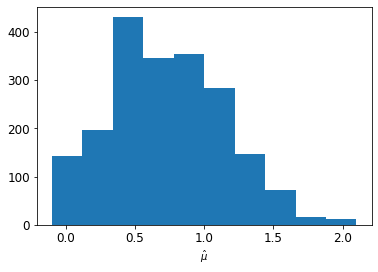

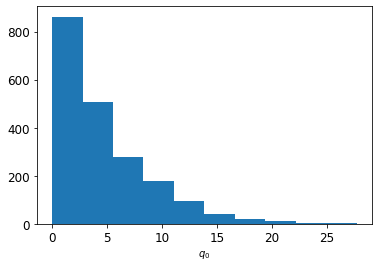

Z BL:(2.019004545658751, 0.8163103484668301, 1.037325, 2.019017834558455, 0.7804143812634632)
Z:1.8471886026498379
Z_std:1.1672146240944818
Z_1:1.703533185972339
Z_std_1:1.5873968254155333
2
AUC:0.901368645912959
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

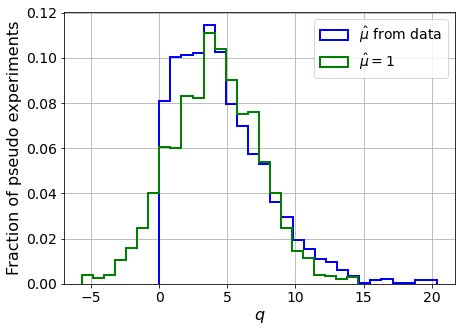

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  6824.6092701   6699.48571048  6517.80903386
  6276.86358711  5964.16569229  5572.52874716  5090.65868504
  4501.68129616  3766.40384918  2880.29089892  1836.39159376
   581.52087816  -922.10110778 -2734.58804544 -5308.37467772]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
  4171.16437626  4214.1159814   4240.23598196  4250.64420975


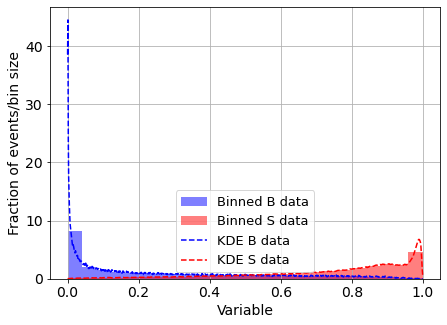

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.020852736467425855
0.020852736467425855
3 done
4 done
0.0
7.964296086341564e-05


  3%|█▋                                                               | 52/2000 [00:15<10:31,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4948113358022799
<p_{s}(Sdata)> = 2.004547311288612
<p_{b}(Bdata)> = 6.720953156592152
<p_{s}(Bdata)> = 0.4241709315503769


  6%|███▌                                                            | 113/2000 [00:34<10:32,  2.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4310123099271577
<p_{s}(Sdata)> = 1.9602445797018244
<p_{b}(Bdata)> = 6.560932822445857
<p_{s}(Bdata)> = 0.428669342016897


  7%|████▎                                                           | 136/2000 [00:41<08:52,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4397379800776407
<p_{s}(Sdata)> = 2.014726889094409
<p_{b}(Bdata)> = 6.638296154326426
<p_{s}(Bdata)> = 0.4216871951425867


  7%|████▊                                                           | 149/2000 [00:44<09:00,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36441337976720567
<p_{s}(Sdata)> = 2.0796315382572206
<p_{b}(Bdata)> = 6.7428544335296365
<p_{s}(Bdata)> = 0.42353050856206537


  8%|█████▏                                                          | 164/2000 [00:48<08:13,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45195576756789124
<p_{s}(Sdata)> = 1.8062480371348373
<p_{b}(Bdata)> = 6.672953478096753
<p_{s}(Bdata)> = 0.42379808050345646


  9%|█████▌                                                          | 172/2000 [00:50<07:08,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4735537724258827
<p_{s}(Sdata)> = 1.8619995881919276
<p_{b}(Bdata)> = 6.702085299724586
<p_{s}(Bdata)> = 0.4227690221600517


  9%|██████                                                          | 188/2000 [00:55<06:17,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4824823621789025
<p_{s}(Sdata)> = 1.8848693447198384
<p_{b}(Bdata)> = 6.788589550606389
<p_{s}(Bdata)> = 0.4218714260593231
muhat = -0.1
<p_{b}(Sdata)> = 0.42740949100161046
<p_{s}(Sdata)> = 1.904903054289052
<p_{b}(Bdata)> = 6.795165862809109
<p_{s}(Bdata)> = 0.4308308383186649


 12%|███████▌                                                        | 238/2000 [01:11<09:31,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4170127893719156
<p_{s}(Sdata)> = 1.8884641021273865
<p_{b}(Bdata)> = 6.841090970381027
<p_{s}(Bdata)> = 0.4211950045101274


 12%|███████▋                                                        | 242/2000 [01:12<07:34,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44906929906156623
<p_{s}(Sdata)> = 1.9195824175906426
<p_{b}(Bdata)> = 6.703246787875467
<p_{s}(Bdata)> = 0.4218997665564687


 13%|████████                                                        | 253/2000 [01:15<07:25,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37139804011645927
<p_{s}(Sdata)> = 2.2846684180271453
<p_{b}(Bdata)> = 6.680876886530514
<p_{s}(Bdata)> = 0.4286353862156447


 13%|████████▍                                                       | 265/2000 [01:19<07:54,  3.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5282137414885587
<p_{s}(Sdata)> = 1.4480103068083547
<p_{b}(Bdata)> = 6.702883131777335
<p_{s}(Bdata)> = 0.42603352427830954


 14%|████████▊                                                       | 274/2000 [01:22<09:45,  2.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44958859185371386
<p_{s}(Sdata)> = 2.234009693033532
<p_{b}(Bdata)> = 6.679333266679381
<p_{s}(Bdata)> = 0.42119808321690366


 14%|█████████▏                                                      | 286/2000 [01:25<05:42,  5.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42674508134785544
<p_{s}(Sdata)> = 2.1140874936185097
<p_{b}(Bdata)> = 6.7430036945280785
<p_{s}(Bdata)> = 0.41776586326643544
muhat = -0.1
<p_{b}(Sdata)> = 0.41969968658534074
<p_{s}(Sdata)> = 2.1041880526554246
<p_{b}(Bdata)> = 6.461981654538602
<p_{s}(Bdata)> = 0.4280020546913182


 14%|█████████▏                                                      | 289/2000 [01:26<07:32,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41523213852106106
<p_{s}(Sdata)> = 2.048646230557311
<p_{b}(Bdata)> = 6.827376875103972
<p_{s}(Bdata)> = 0.42586342050502846


 15%|█████████▋                                                      | 302/2000 [01:29<07:44,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3965758696608654
<p_{s}(Sdata)> = 2.0996861474613597
<p_{b}(Bdata)> = 6.873976813332901
<p_{s}(Bdata)> = 0.42123134960549197


 18%|███████████▏                                                    | 350/2000 [01:45<08:00,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44211545577898487
<p_{s}(Sdata)> = 1.98347830472515
<p_{b}(Bdata)> = 6.731266449345481
<p_{s}(Bdata)> = 0.4236859411642234


 18%|███████████▋                                                    | 366/2000 [01:49<07:23,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4596835966028838
<p_{s}(Sdata)> = 1.9263482791548798
<p_{b}(Bdata)> = 6.715556227031231
<p_{s}(Bdata)> = 0.4245952862503214


 20%|████████████▋                                                   | 395/2000 [01:57<08:57,  2.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.51945342773404
<p_{s}(Sdata)> = 1.4927521329623428
<p_{b}(Bdata)> = 6.867554736128039
<p_{s}(Bdata)> = 0.4201088596657292


 22%|██████████████▎                                                 | 448/2000 [02:14<08:11,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4313799576720474
<p_{s}(Sdata)> = 1.8910584039899525
<p_{b}(Bdata)> = 6.7427533357064515
<p_{s}(Bdata)> = 0.41762314399993167


 23%|██████████████▋                                                 | 458/2000 [02:16<05:06,  5.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4837541546203232
<p_{s}(Sdata)> = 1.7853006065076367
<p_{b}(Bdata)> = 6.734193699463469
<p_{s}(Bdata)> = 0.42033867539192604
muhat = -0.1
<p_{b}(Sdata)> = 0.455458568616125
<p_{s}(Sdata)> = 1.8184576432087634
<p_{b}(Bdata)> = 6.705286039216232
<p_{s}(Bdata)> = 0.4211207610929903


 24%|███████████████▋                                                | 489/2000 [02:26<07:09,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5167282585339561
<p_{s}(Sdata)> = 1.6796637714930538
<p_{b}(Bdata)> = 6.74530949331292
<p_{s}(Bdata)> = 0.42881676346199443


 26%|████████████████▍                                               | 515/2000 [02:35<07:44,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6829498307011541
<p_{s}(Sdata)> = 1.7233301874735074
<p_{b}(Bdata)> = 6.668968914056493
<p_{s}(Bdata)> = 0.4229736110820746


 28%|█████████████████▉                                              | 561/2000 [02:49<05:29,  4.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3945398022511597
<p_{s}(Sdata)> = 2.1653593317140802
<p_{b}(Bdata)> = 6.656229767186285
<p_{s}(Bdata)> = 0.43833203482697325


 29%|██████████████████▍                                             | 575/2000 [02:53<05:31,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4571771804906851
<p_{s}(Sdata)> = 1.8160961511223104
<p_{b}(Bdata)> = 6.634530856513858
<p_{s}(Bdata)> = 0.4219290213666928


 29%|██████████████████▍                                             | 577/2000 [02:54<05:53,  4.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44313496261559554
<p_{s}(Sdata)> = 1.8484146047038286
<p_{b}(Bdata)> = 6.762511897180432
<p_{s}(Bdata)> = 0.42364335908272843


 30%|███████████████████▎                                            | 602/2000 [03:01<08:44,  2.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38792807033376003
<p_{s}(Sdata)> = 2.263139217027494
<p_{b}(Bdata)> = 6.717857733591854
<p_{s}(Bdata)> = 0.4213368142636886


 31%|███████████████████▋                                            | 616/2000 [03:05<05:44,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4361716654382133
<p_{s}(Sdata)> = 2.1656674879469073
<p_{b}(Bdata)> = 6.716698592705724
<p_{s}(Bdata)> = 0.4232418539442561


 31%|███████████████████▊                                            | 621/2000 [03:06<03:49,  6.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5527091321955041
<p_{s}(Sdata)> = 1.8341012921756217
<p_{b}(Bdata)> = 6.687136198018347
<p_{s}(Bdata)> = 0.4208356976019308
muhat = -0.1
<p_{b}(Sdata)> = 0.4018584028911093
<p_{s}(Sdata)> = 2.0452684875617835
<p_{b}(Bdata)> = 6.720368876515624
<p_{s}(Bdata)> = 0.4256341818902017


 32%|████████████████████▌                                           | 644/2000 [03:13<06:28,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4190956375819487
<p_{s}(Sdata)> = 1.917698143579529
<p_{b}(Bdata)> = 6.799646005655404
<p_{s}(Bdata)> = 0.42305145708932407


 33%|████████████████████▉                                           | 654/2000 [03:16<07:17,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41399850678990147
<p_{s}(Sdata)> = 2.0568570931403003
<p_{b}(Bdata)> = 6.771656611848284
<p_{s}(Bdata)> = 0.4249411568948962


 33%|█████████████████████                                           | 658/2000 [03:17<06:39,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.415012665898163
<p_{s}(Sdata)> = 2.3020958819396227
<p_{b}(Bdata)> = 6.568930931539168
<p_{s}(Bdata)> = 0.42495353414781933


 34%|██████████████████████                                          | 689/2000 [03:26<04:23,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41662533427220677
<p_{s}(Sdata)> = 1.908183656585114
<p_{b}(Bdata)> = 6.815094862807922
<p_{s}(Bdata)> = 0.4231165115775079
muhat = -0.1
<p_{b}(Sdata)> = 0.3834832745069321
<p_{s}(Sdata)> = 2.274858767167825
<p_{b}(Bdata)> = 6.576828312584103
<p_{s}(Bdata)> = 0.42293468395856426


 36%|██████████████████████▊                                         | 712/2000 [03:32<05:22,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4685633692966233
<p_{s}(Sdata)> = 1.9027014163312128
<p_{b}(Bdata)> = 6.816570164055371
<p_{s}(Bdata)> = 0.421959058927339


 37%|███████████████████████▍                                        | 731/2000 [03:38<05:17,  4.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3553011022238367
<p_{s}(Sdata)> = 2.7506635091151894
<p_{b}(Bdata)> = 6.609146969236112
<p_{s}(Bdata)> = 0.4343619550083758


 38%|████████████████████████                                        | 751/2000 [03:44<06:01,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4271887705055116
<p_{s}(Sdata)> = 2.0539629922976506
<p_{b}(Bdata)> = 6.7471586544825985
<p_{s}(Bdata)> = 0.4216400906054973


 41%|██████████████████████████▏                                     | 818/2000 [04:06<08:16,  2.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4572409441206075
<p_{s}(Sdata)> = 1.8672775135427564
<p_{b}(Bdata)> = 6.767762465107563
<p_{s}(Bdata)> = 0.4280907007733553


 41%|██████████████████████████▍                                     | 825/2000 [04:08<04:34,  4.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4045007778275514
<p_{s}(Sdata)> = 2.1573304118959067
<p_{b}(Bdata)> = 6.608283053848656
<p_{s}(Bdata)> = 0.4233294180845803


 46%|█████████████████████████████▋                                  | 926/2000 [04:39<05:49,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45308508397815234
<p_{s}(Sdata)> = 2.013926134588852
<p_{b}(Bdata)> = 6.760843817021791
<p_{s}(Bdata)> = 0.4203072581224559


 47%|██████████████████████████████▏                                 | 944/2000 [04:45<05:34,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5149115966608895
<p_{s}(Sdata)> = 1.7766382104302336
<p_{b}(Bdata)> = 6.723421770235817
<p_{s}(Bdata)> = 0.42353911802558136


 48%|██████████████████████████████▍                                 | 953/2000 [04:48<05:01,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49413387678481346
<p_{s}(Sdata)> = 1.6995604362156038
<p_{b}(Bdata)> = 6.711626966180666
<p_{s}(Bdata)> = 0.4228955496188541


 49%|███████████████████████████████▎                                | 980/2000 [04:56<04:31,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4043077057234172
<p_{s}(Sdata)> = 2.0097235704264262
<p_{b}(Bdata)> = 6.717539789925372
<p_{s}(Bdata)> = 0.4253791208484901


 49%|███████████████████████████████▍                                | 983/2000 [04:57<04:44,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4846422907229319
<p_{s}(Sdata)> = 1.723345079411322
<p_{b}(Bdata)> = 6.498081736405703
<p_{s}(Bdata)> = 0.42687298201966517


 50%|███████████████████████████████▋                               | 1004/2000 [05:03<03:34,  4.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3878270013260057
<p_{s}(Sdata)> = 2.073084037205934
<p_{b}(Bdata)> = 6.637666718873677
<p_{s}(Bdata)> = 0.4254225269380713
muhat = -0.1
<p_{b}(Sdata)> = 0.4367315717644551
<p_{s}(Sdata)> = 1.8907829966555239
<p_{b}(Bdata)> = 6.64735590623939
<p_{s}(Bdata)> = 0.4244821785527658
muhat = -0.1
<p_{b}(Sdata)> = 0.48106131629031823
<p_{s}(Sdata)> = 1.7436976977772642
<p_{b}(Bdata)> = 6.573450434235698
<p_{s}(Bdata)> = 0.4301130340315625


 51%|███████████████████████████████▉                               | 1015/2000 [05:05<04:41,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4090609705330217
<p_{s}(Sdata)> = 1.9534449968381589
<p_{b}(Bdata)> = 6.6945982943688085
<p_{s}(Bdata)> = 0.4245000623525333


 51%|████████████████████████████████▍                              | 1028/2000 [05:09<05:37,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49844483574681614
<p_{s}(Sdata)> = 1.877200562772373
<p_{b}(Bdata)> = 6.672030509003045
<p_{s}(Bdata)> = 0.42466897673318826


 62%|███████████████████████████████████████▎                       | 1247/2000 [06:15<04:25,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44837583240459167
<p_{s}(Sdata)> = 1.7163870839156188
<p_{b}(Bdata)> = 6.543590227276214
<p_{s}(Bdata)> = 0.4266460193519838


 63%|███████████████████████████████████████▌                       | 1256/2000 [06:18<03:57,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43058344799370873
<p_{s}(Sdata)> = 2.0113511592412983
<p_{b}(Bdata)> = 6.661274913290656
<p_{s}(Bdata)> = 0.42600391935359877


 63%|███████████████████████████████████████▊                       | 1262/2000 [06:19<03:57,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43922771604018823
<p_{s}(Sdata)> = 1.9839918296783758
<p_{b}(Bdata)> = 6.644376845197711
<p_{s}(Bdata)> = 0.42637849777349485


 64%|████████████████████████████████████████                       | 1270/2000 [06:22<03:21,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38572465746423795
<p_{s}(Sdata)> = 2.021047486778829
<p_{b}(Bdata)> = 6.710774019556903
<p_{s}(Bdata)> = 0.42740922327409053


 65%|█████████████████████████████████████████                      | 1305/2000 [06:33<03:24,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40686642440463483
<p_{s}(Sdata)> = 2.0407384918218767
<p_{b}(Bdata)> = 6.69318055957882
<p_{s}(Bdata)> = 0.42076181358383585


 66%|█████████████████████████████████████████▎                     | 1313/2000 [06:35<03:52,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41378650934295474
<p_{s}(Sdata)> = 1.8529460514074965
<p_{b}(Bdata)> = 6.846374815806902
<p_{s}(Bdata)> = 0.42680552118263926


 70%|███████████████████████████████████████████▉                   | 1393/2000 [07:00<01:56,  5.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4222754795016114
<p_{s}(Sdata)> = 1.9229227253755565
<p_{b}(Bdata)> = 6.649723323710831
<p_{s}(Bdata)> = 0.42591823978955795
muhat = -0.1
<p_{b}(Sdata)> = 0.42370029089543965
<p_{s}(Sdata)> = 1.9994431350115622
<p_{b}(Bdata)> = 6.801892360157845
<p_{s}(Bdata)> = 0.4201557129472826


 70%|████████████████████████████████████████████                   | 1397/2000 [07:01<02:18,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4437251904641081
<p_{s}(Sdata)> = 1.8765094597251604
<p_{b}(Bdata)> = 6.77166483975107
<p_{s}(Bdata)> = 0.4224663446197808


 72%|█████████████████████████████████████████████▏                 | 1433/2000 [07:12<03:01,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4215837629514377
<p_{s}(Sdata)> = 1.9478952945419545
<p_{b}(Bdata)> = 6.766668462481828
<p_{s}(Bdata)> = 0.4191067079999116


 72%|█████████████████████████████████████████████▍                 | 1441/2000 [07:14<02:36,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43828756363404375
<p_{s}(Sdata)> = 1.9761399625714746
<p_{b}(Bdata)> = 6.652186339649793
<p_{s}(Bdata)> = 0.42420687584483274


 73%|██████████████████████████████████████████████                 | 1462/2000 [07:21<02:55,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.477988955837756
<p_{s}(Sdata)> = 1.8158866868375647
<p_{b}(Bdata)> = 6.571640116187025
<p_{s}(Bdata)> = 0.428673047109802


 73%|██████████████████████████████████████████████▏                | 1465/2000 [07:21<02:21,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42340161205014853
<p_{s}(Sdata)> = 1.9759754498195623
<p_{b}(Bdata)> = 6.818846493330378
<p_{s}(Bdata)> = 0.42230252265501794


 74%|██████████████████████████████████████████████▎                | 1472/2000 [07:23<02:07,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5132521876599788
<p_{s}(Sdata)> = 1.9064999537007996
<p_{b}(Bdata)> = 6.573076806831336
<p_{s}(Bdata)> = 0.4253560657016847


 74%|██████████████████████████████████████████████▍                | 1474/2000 [07:24<01:47,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4336710658123599
<p_{s}(Sdata)> = 1.6824153431734128
<p_{b}(Bdata)> = 6.676197584474348
<p_{s}(Bdata)> = 0.42517920559564454


 74%|██████████████████████████████████████████████▉                | 1489/2000 [07:28<02:56,  2.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44527891678240406
<p_{s}(Sdata)> = 1.9090282416910422
<p_{b}(Bdata)> = 6.808108300833857
<p_{s}(Bdata)> = 0.4222681483197679


 75%|███████████████████████████████████████████████▍               | 1507/2000 [07:34<03:06,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49377310031598054
<p_{s}(Sdata)> = 1.8885432548921726
<p_{b}(Bdata)> = 6.59536066072755
<p_{s}(Bdata)> = 0.4290597592980443


 76%|███████████████████████████████████████████████▋               | 1514/2000 [07:36<03:02,  2.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4202201294995996
<p_{s}(Sdata)> = 1.9548463104789766
<p_{b}(Bdata)> = 6.717265720611676
<p_{s}(Bdata)> = 0.4256889769113802


 80%|██████████████████████████████████████████████████▍            | 1602/2000 [08:05<02:46,  2.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43567758040292637
<p_{s}(Sdata)> = 1.9882802983369467
<p_{b}(Bdata)> = 6.752829744931617
<p_{s}(Bdata)> = 0.4217768176042337


 81%|███████████████████████████████████████████████████▎           | 1629/2000 [08:14<01:55,  3.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5452963217157578
<p_{s}(Sdata)> = 1.8268021943304225
<p_{b}(Bdata)> = 6.67207260778868
<p_{s}(Bdata)> = 0.4234453980041841


 82%|███████████████████████████████████████████████████▋           | 1640/2000 [08:17<01:45,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4034413955725003
<p_{s}(Sdata)> = 2.266865325520314
<p_{b}(Bdata)> = 6.780774941797227
<p_{s}(Bdata)> = 0.4203954467773646


 84%|█████████████████████████████████████████████████████          | 1685/2000 [08:31<01:11,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3872759658581889
<p_{s}(Sdata)> = 2.275094128437047
<p_{b}(Bdata)> = 6.718858282433166
<p_{s}(Bdata)> = 0.41899882278074335


 86%|██████████████████████████████████████████████████████▎        | 1726/2000 [08:44<01:06,  4.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3762112858849538
<p_{s}(Sdata)> = 2.318068424268991
<p_{b}(Bdata)> = 6.803530339369693
<p_{s}(Bdata)> = 0.4284888176907985


 86%|██████████████████████████████████████████████████████▍        | 1728/2000 [08:45<01:10,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3933841773365988
<p_{s}(Sdata)> = 2.0640018895516867
<p_{b}(Bdata)> = 6.7729969654550315
<p_{s}(Bdata)> = 0.42219433327950096


 88%|███████████████████████████████████████████████████████▌       | 1762/2000 [08:55<01:01,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42916428986667965
<p_{s}(Sdata)> = 2.1133690332561255
<p_{b}(Bdata)> = 6.726611940015775
<p_{s}(Bdata)> = 0.42461441593111776


 88%|███████████████████████████████████████████████████████▌       | 1764/2000 [08:55<00:50,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.440756471611779
<p_{s}(Sdata)> = 1.9332736257852101
<p_{b}(Bdata)> = 6.737741738740324
<p_{s}(Bdata)> = 0.4199011321474411


 88%|███████████████████████████████████████████████████████▊       | 1770/2000 [08:57<01:16,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4743450054209953
<p_{s}(Sdata)> = 1.7170102160145801
<p_{b}(Bdata)> = 6.629517940781849
<p_{s}(Bdata)> = 0.42674118800414285


 89%|███████████████████████████████████████████████████████▊       | 1772/2000 [08:58<01:02,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.496908295601914
<p_{s}(Sdata)> = 1.9611400576259401
<p_{b}(Bdata)> = 6.74595365973905
<p_{s}(Bdata)> = 0.42083339642236284


 90%|████████████████████████████████████████████████████████▌      | 1797/2000 [09:06<01:03,  3.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45365646640586443
<p_{s}(Sdata)> = 1.9663168147891925
<p_{b}(Bdata)> = 6.756789919001589
<p_{s}(Bdata)> = 0.42286537661831364


 90%|█████████████████████████████████████████████████████████      | 1810/2000 [09:10<00:48,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4675526949630963
<p_{s}(Sdata)> = 1.9319219507977188
<p_{b}(Bdata)> = 6.755275208291872
<p_{s}(Bdata)> = 0.4242581812160795


 91%|█████████████████████████████████████████████████████████      | 1812/2000 [09:10<00:43,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3976867565334055
<p_{s}(Sdata)> = 1.9724039360177568
<p_{b}(Bdata)> = 6.779168220532738
<p_{s}(Bdata)> = 0.4280327262333332


 92%|█████████████████████████████████████████████████████████▋     | 1830/2000 [09:16<00:38,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.458716055899916
<p_{s}(Sdata)> = 1.9285449626515085
<p_{b}(Bdata)> = 6.85168226796451
<p_{s}(Bdata)> = 0.4184795483246247


 93%|██████████████████████████████████████████████████████████▋    | 1865/2000 [09:27<00:32,  4.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4468425655712689
<p_{s}(Sdata)> = 2.042543225373272
<p_{b}(Bdata)> = 6.578703836941017
<p_{s}(Bdata)> = 0.42402609057879165


 95%|███████████████████████████████████████████████████████████▊   | 1899/2000 [09:38<00:30,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47576276096199915
<p_{s}(Sdata)> = 2.0179164467911663
<p_{b}(Bdata)> = 6.801239347846496
<p_{s}(Bdata)> = 0.42090524226591314


 95%|███████████████████████████████████████████████████████████▉   | 1902/2000 [09:39<00:30,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4671963225946547
<p_{s}(Sdata)> = 2.0176241047413987
<p_{b}(Bdata)> = 6.775913658635528
<p_{s}(Bdata)> = 0.42369328528641503


 96%|████████████████████████████████████████████████████████████▎  | 1914/2000 [09:43<00:26,  3.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3760139163801113
<p_{s}(Sdata)> = 2.340693413947363
<p_{b}(Bdata)> = 6.686477149528247
<p_{s}(Bdata)> = 0.4343188007505215


 99%|██████████████████████████████████████████████████████████████▍| 1983/2000 [10:05<00:05,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46214791483898193
<p_{s}(Sdata)> = 1.9975747481189623
<p_{b}(Bdata)> = 6.848948966704502
<p_{s}(Bdata)> = 0.4262723626426285


100%|███████████████████████████████████████████████████████████████| 2000/2000 [10:11<00:00,  3.27it/s]


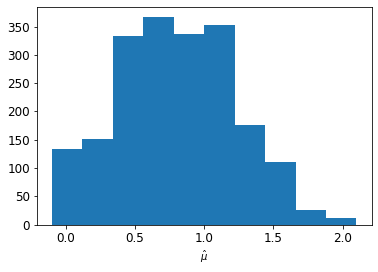

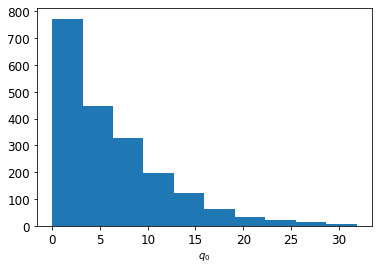

Z BL:(2.0219808222612823, 0.8050801199973995, 1.0136500000000002, 2.02326931447047, 0.7948906761242355)
Z:2.1570617093400526
Z_std:1.3381716900470066
Z_1:2.06184444773521
Z_std_1:1.603328146984235
3
AUC:0.9028568157038788
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

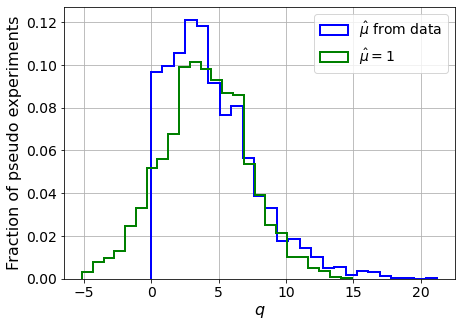

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  7302.98229605  7134.45706309  6916.7541014
  6629.80732202  6275.67444327  5847.46893008  5337.6683338
  4718.92973318  3960.76807348  3040.00440472  1946.68299145
   641.72819207  -909.76636383 -2739.08173318 -5314.28276107]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4338.61098847  4359.91619937  4363.81724716
  

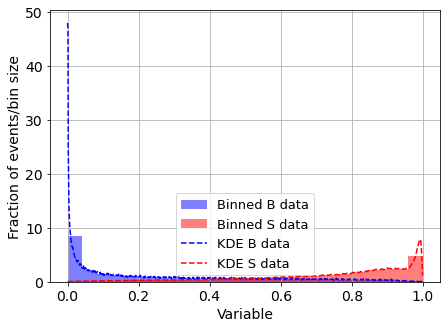

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.021295263038521823
0.021295263038521823
3 done
4 done
0.0
1.177325401989524e-05


  1%|▋                                                                | 21/2000 [00:07<12:35,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37041502113865893
<p_{s}(Sdata)> = 2.302135575890247
<p_{b}(Bdata)> = 7.883466744830739
<p_{s}(Bdata)> = 0.41732125771103995


  2%|█                                                                | 31/2000 [00:10<09:26,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5308769348906683
<p_{s}(Sdata)> = 2.070381789862345
<p_{b}(Bdata)> = 7.896781611358002
<p_{s}(Bdata)> = 0.4200224843075654


  3%|█▋                                                               | 52/2000 [00:16<10:46,  3.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.0551558067368576
<p_{s}(Sdata)> = 1.9666492055300324
<p_{b}(Bdata)> = 7.765786736547967
<p_{s}(Bdata)> = 0.4127972907369245


  6%|███▋                                                            | 114/2000 [00:35<08:42,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45352132107230236
<p_{s}(Sdata)> = 1.9912744211296034
<p_{b}(Bdata)> = 7.906152565078241
<p_{s}(Bdata)> = 0.4126376086020101


  9%|█████▌                                                          | 175/2000 [00:56<09:48,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42739093880040757
<p_{s}(Sdata)> = 1.8253467668316274
<p_{b}(Bdata)> = 8.108163613796005
<p_{s}(Bdata)> = 0.41757302144744946


 10%|██████▏                                                         | 194/2000 [01:02<09:31,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44866315431334564
<p_{s}(Sdata)> = 2.0942467980701682
<p_{b}(Bdata)> = 7.801080898123848
<p_{s}(Bdata)> = 0.41476880223995005


 13%|████████                                                        | 251/2000 [01:18<05:57,  4.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4402401339100274
<p_{s}(Sdata)> = 2.1074083831824795
<p_{b}(Bdata)> = 7.760308849918866
<p_{s}(Bdata)> = 0.4205058639164146


 13%|████████▎                                                       | 260/2000 [01:22<09:53,  2.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4559887175634879
<p_{s}(Sdata)> = 1.9055930135471233
<p_{b}(Bdata)> = 7.711137186619099
<p_{s}(Bdata)> = 0.41957256165825757


 14%|█████████                                                       | 285/2000 [01:29<08:56,  3.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3756919822566795
<p_{s}(Sdata)> = 2.521224600250439
<p_{b}(Bdata)> = 7.873347756709496
<p_{s}(Bdata)> = 0.4273325092255944


 14%|█████████▏                                                      | 288/2000 [01:29<08:32,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4596202062504865
<p_{s}(Sdata)> = 1.8626508300988454
<p_{b}(Bdata)> = 7.918945346567621
<p_{s}(Bdata)> = 0.41721953545339246


 17%|██████████▉                                                     | 342/2000 [01:46<08:48,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4031978716078255
<p_{s}(Sdata)> = 2.3124847315102492
<p_{b}(Bdata)> = 7.97696544213308
<p_{s}(Bdata)> = 0.42038859804730183


 19%|████████████▏                                                   | 381/2000 [01:59<06:45,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39300998143667193
<p_{s}(Sdata)> = 2.130308849836104
<p_{b}(Bdata)> = 7.822833711712066
<p_{s}(Bdata)> = 0.41724241225119507


 19%|████████████▎                                                   | 386/2000 [01:59<04:36,  5.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4125057881356628
<p_{s}(Sdata)> = 2.2033735135347348
<p_{b}(Bdata)> = 7.873389552422531
<p_{s}(Bdata)> = 0.41402590078778406
muhat = -0.1
<p_{b}(Sdata)> = 0.4056251370705592
<p_{s}(Sdata)> = 1.9379761747940305
<p_{b}(Bdata)> = 7.846261970860582
<p_{s}(Bdata)> = 0.42232929865457286


 20%|████████████▌                                                   | 391/2000 [02:01<05:27,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3812064159894057
<p_{s}(Sdata)> = 2.216870612359876
<p_{b}(Bdata)> = 7.880217581367702
<p_{s}(Bdata)> = 0.4137276439988833
muhat = -0.1
<p_{b}(Sdata)> = 0.40435001071163734
<p_{s}(Sdata)> = 2.0691474268917793
<p_{b}(Bdata)> = 7.822039955357856
<p_{s}(Bdata)> = 0.4185184028958302


 20%|████████████▊                                                   | 402/2000 [02:04<09:21,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4115759594292801
<p_{s}(Sdata)> = 1.972377752658798
<p_{b}(Bdata)> = 7.848153632155036
<p_{s}(Bdata)> = 0.42164052738147473


 22%|█████████████▊                                                  | 431/2000 [02:12<05:50,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7718029420147571
<p_{s}(Sdata)> = 2.22568552684076
<p_{b}(Bdata)> = 7.798426740279232
<p_{s}(Bdata)> = 0.41453986578315266


 28%|█████████████████▊                                              | 558/2000 [02:53<09:06,  2.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.46903295504442544
<p_{s}(Sdata)> = 2.408186964932262
<p_{b}(Bdata)> = 7.698518847284339
<p_{s}(Bdata)> = 0.4279291095797115


 28%|██████████████████▏                                             | 568/2000 [02:55<06:30,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4253275086669185
<p_{s}(Sdata)> = 1.9960855543324374
<p_{b}(Bdata)> = 7.834530132703532
<p_{s}(Bdata)> = 0.41609835467040845


 29%|██████████████████▋                                             | 583/2000 [02:59<04:38,  5.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4216427522191204
<p_{s}(Sdata)> = 1.9241858251292574
<p_{b}(Bdata)> = 7.811934034059982
<p_{s}(Bdata)> = 0.41549423256163326


 29%|██████████████████▋                                             | 585/2000 [03:00<06:29,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46429968594298293
<p_{s}(Sdata)> = 1.7259801792520106
<p_{b}(Bdata)> = 7.990368538146818
<p_{s}(Bdata)> = 0.4178988817323085


 30%|██████████████████▉                                             | 593/2000 [03:02<06:53,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3767768786020726
<p_{s}(Sdata)> = 2.094504572167859
<p_{b}(Bdata)> = 7.830996121438182
<p_{s}(Bdata)> = 0.41250387061335025


 30%|███████████████████▏                                            | 599/2000 [03:04<06:27,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4573701769001573
<p_{s}(Sdata)> = 1.949658311201851
<p_{b}(Bdata)> = 7.878853836484327
<p_{s}(Bdata)> = 0.4148827030934885


 30%|███████████████████▏                                            | 601/2000 [03:04<05:46,  4.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4403095376686996
<p_{s}(Sdata)> = 2.224143662575758
<p_{b}(Bdata)> = 8.077873935993404
<p_{s}(Bdata)> = 0.41156561991446344


 31%|███████████████████▊                                            | 620/2000 [03:10<08:59,  2.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47827729914624184
<p_{s}(Sdata)> = 2.078643440459844
<p_{b}(Bdata)> = 7.920365142904256
<p_{s}(Bdata)> = 0.41634517455388975


 32%|████████████████████▍                                           | 637/2000 [03:15<06:05,  3.73it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.40236146781919785
<p_{s}(Sdata)> = 2.480272929352281
<p_{b}(Bdata)> = 7.873814892227901
<p_{s}(Bdata)> = 0.42659373744140155


 32%|████████████████████▊                                           | 650/2000 [03:19<06:16,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46693093014896586
<p_{s}(Sdata)> = 1.9647337667424845
<p_{b}(Bdata)> = 7.886159642474822
<p_{s}(Bdata)> = 0.4129705462535538


 35%|██████████████████████▏                                         | 694/2000 [03:33<06:30,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4489304212239246
<p_{s}(Sdata)> = 2.010544654085481
<p_{b}(Bdata)> = 7.905181813068742
<p_{s}(Bdata)> = 0.416873985341345


 35%|██████████████████████▎                                         | 697/2000 [03:33<06:08,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45775134271163936
<p_{s}(Sdata)> = 1.8965102181904794
<p_{b}(Bdata)> = 7.843340641767983
<p_{s}(Bdata)> = 0.4100469549115765


 37%|███████████████████████▍                                        | 734/2000 [03:45<06:43,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39927465655555194
<p_{s}(Sdata)> = 1.852805504809434
<p_{b}(Bdata)> = 7.935621421637111
<p_{s}(Bdata)> = 0.4174441455874001


 37%|███████████████████████▋                                        | 740/2000 [03:46<05:00,  4.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4154618873142612
<p_{s}(Sdata)> = 2.07270040579242
<p_{b}(Bdata)> = 7.736963124882095
<p_{s}(Bdata)> = 0.4186078898540161


 37%|███████████████████████▉                                        | 747/2000 [03:49<07:16,  2.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4477866049672011
<p_{s}(Sdata)> = 1.9404047966927136
<p_{b}(Bdata)> = 7.836819671812155
<p_{s}(Bdata)> = 0.4178078382059677


 39%|████████████████████████▊                                       | 777/2000 [03:58<04:48,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41986906559336507
<p_{s}(Sdata)> = 1.9772091539107803
<p_{b}(Bdata)> = 7.770587551897255
<p_{s}(Bdata)> = 0.42162058326064566


 44%|████████████████████████████▍                                   | 888/2000 [04:32<04:31,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37977446541599963
<p_{s}(Sdata)> = 2.3160508335283243
<p_{b}(Bdata)> = 7.805385776581302
<p_{s}(Bdata)> = 0.4192763336766638


 46%|█████████████████████████████▏                                  | 912/2000 [04:40<05:08,  3.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3459626638999175
<p_{s}(Sdata)> = 2.5771063869413253
<p_{b}(Bdata)> = 7.744113311685584
<p_{s}(Bdata)> = 0.4310204719613477


 46%|█████████████████████████████▍                                  | 919/2000 [04:42<05:25,  3.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42281428890164696
<p_{s}(Sdata)> = 2.0336331643754404
<p_{b}(Bdata)> = 7.838940991529548
<p_{s}(Bdata)> = 0.4142539970384963


 48%|██████████████████████████████▊                                 | 961/2000 [04:54<04:14,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42316530158499965
<p_{s}(Sdata)> = 1.9941057335915204
<p_{b}(Bdata)> = 7.723537918174685
<p_{s}(Bdata)> = 0.4171022296012266


 50%|███████████████████████████████▉                                | 997/2000 [05:06<05:23,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37951941696281194
<p_{s}(Sdata)> = 2.1158550040312707
<p_{b}(Bdata)> = 7.888716238227322
<p_{s}(Bdata)> = 0.4190461186821063


 54%|██████████████████████████████████▏                            | 1085/2000 [05:33<03:31,  4.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4517834516005946
<p_{s}(Sdata)> = 1.991411757879995
<p_{b}(Bdata)> = 7.820065982266254
<p_{s}(Bdata)> = 0.4171936743278461


 56%|███████████████████████████████████▏                           | 1118/2000 [05:43<06:03,  2.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4082166451827665
<p_{s}(Sdata)> = 2.0010809575866433
<p_{b}(Bdata)> = 7.973980143064868
<p_{s}(Bdata)> = 0.4133500017119253


 56%|███████████████████████████████████▎                           | 1121/2000 [05:44<04:10,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45950595266039784
<p_{s}(Sdata)> = 2.129025008078503
<p_{b}(Bdata)> = 8.106718912979579
<p_{s}(Bdata)> = 0.41590974937125186


 60%|█████████████████████████████████████▋                         | 1196/2000 [06:07<04:35,  2.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4447952148450199
<p_{s}(Sdata)> = 1.9249691781073677
<p_{b}(Bdata)> = 7.908061311688185
<p_{s}(Bdata)> = 0.4146923072117478


 62%|██████████████████████████████████████▉                        | 1235/2000 [06:19<04:32,  2.81it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32869248948621194
<p_{s}(Sdata)> = 2.64312179954321
<p_{b}(Bdata)> = 8.045066640572959
<p_{s}(Bdata)> = 0.42499263323848063


 64%|████████████████████████████████████████▎                      | 1278/2000 [06:32<03:03,  3.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46367460642280495
<p_{s}(Sdata)> = 1.7928934259608937
<p_{b}(Bdata)> = 7.889035170469633
<p_{s}(Bdata)> = 0.4186469629483425


 64%|████████████████████████████████████████▍                      | 1283/2000 [06:33<03:24,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40160920375876685
<p_{s}(Sdata)> = 2.1960118588304676
<p_{b}(Bdata)> = 7.994931004310345
<p_{s}(Bdata)> = 0.41685597755186576


 64%|████████████████████████████████████████▌                      | 1286/2000 [06:34<03:14,  3.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3745984697796076
<p_{s}(Sdata)> = 2.434643509884446
<p_{b}(Bdata)> = 7.780574870891177
<p_{s}(Bdata)> = 0.4295822790089578


 65%|████████████████████████████████████████▋                      | 1292/2000 [06:36<03:26,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3858534129182714
<p_{s}(Sdata)> = 2.112530368872985
<p_{b}(Bdata)> = 7.923408314546318
<p_{s}(Bdata)> = 0.420751698045982


 65%|████████████████████████████████████████▊                      | 1294/2000 [06:36<02:54,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4061955173654765
<p_{s}(Sdata)> = 2.266635034656795
<p_{b}(Bdata)> = 8.00116848185067
<p_{s}(Bdata)> = 0.41292526891720077


 66%|█████████████████████████████████████████▎                     | 1310/2000 [06:41<02:37,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4082806691755783
<p_{s}(Sdata)> = 2.2775745495086004
<p_{b}(Bdata)> = 7.899952006428422
<p_{s}(Bdata)> = 0.4164308355973562
muhat = -0.1
<p_{b}(Sdata)> = 0.4426514952441909
<p_{s}(Sdata)> = 2.024866967550928
<p_{b}(Bdata)> = 7.806357738735955
<p_{s}(Bdata)> = 0.4149671075914101


 68%|██████████████████████████████████████████▊                    | 1358/2000 [06:55<02:27,  4.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4716375805117123
<p_{s}(Sdata)> = 1.9595769271741172
<p_{b}(Bdata)> = 7.809892291418323
<p_{s}(Bdata)> = 0.41818163524788193


 70%|███████████████████████████████████████████▊                   | 1390/2000 [07:05<03:35,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41562607246850103
<p_{s}(Sdata)> = 2.249590597668682
<p_{b}(Bdata)> = 7.915726641134505
<p_{s}(Bdata)> = 0.41387647528514004


 70%|████████████████████████████████████████████                   | 1397/2000 [07:07<02:31,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44318059317761666
<p_{s}(Sdata)> = 1.9273085551435143
<p_{b}(Bdata)> = 7.921819990606543
<p_{s}(Bdata)> = 0.41718146400152184


 72%|█████████████████████████████████████████████▏                 | 1434/2000 [07:19<03:27,  2.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3637744601210271
<p_{s}(Sdata)> = 2.551990326771499
<p_{b}(Bdata)> = 7.6735992124783285
<p_{s}(Bdata)> = 0.4262183432596977


 76%|████████████████████████████████████████████████               | 1525/2000 [07:48<02:53,  2.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48904479328035894
<p_{s}(Sdata)> = 1.6895960270209485
<p_{b}(Bdata)> = 7.89967328110145
<p_{s}(Bdata)> = 0.42111911818552694


 77%|████████████████████████████████████████████████▌              | 1541/2000 [07:53<02:38,  2.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.509085167420468
<p_{s}(Sdata)> = 1.6615833774007163
<p_{b}(Bdata)> = 7.983942170534839
<p_{s}(Bdata)> = 0.4123598229779109


 78%|█████████████████████████████████████████████████              | 1556/2000 [07:57<02:05,  3.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4105790000973348
<p_{s}(Sdata)> = 2.5234095163232735
<p_{b}(Bdata)> = 7.9963815098910205
<p_{s}(Bdata)> = 0.4250642160931132


 78%|█████████████████████████████████████████████████              | 1559/2000 [07:58<01:52,  3.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3931712004045451
<p_{s}(Sdata)> = 2.417919921601609
<p_{b}(Bdata)> = 7.796506851094797
<p_{s}(Bdata)> = 0.42708625689047947


 80%|██████████████████████████████████████████████████▎            | 1596/2000 [08:10<02:25,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4502947111616792
<p_{s}(Sdata)> = 2.057060907343128
<p_{b}(Bdata)> = 7.828108588287583
<p_{s}(Bdata)> = 0.4181427676879466


 81%|███████████████████████████████████████████████████            | 1622/2000 [08:18<01:40,  3.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.426584140401159
<p_{s}(Sdata)> = 2.1400848209864334
<p_{b}(Bdata)> = 8.005792728641392
<p_{s}(Bdata)> = 0.422231343787536


 81%|███████████████████████████████████████████████████▏           | 1625/2000 [08:19<01:52,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3686190089375195
<p_{s}(Sdata)> = 2.3549112719857286
<p_{b}(Bdata)> = 7.8279626432098635
<p_{s}(Bdata)> = 0.4141249995251187


 81%|███████████████████████████████████████████████████▎           | 1629/2000 [08:20<01:15,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.427595058511812
<p_{s}(Sdata)> = 1.9880422553026595
<p_{b}(Bdata)> = 7.664569284869429
<p_{s}(Bdata)> = 0.4182249055881946


 84%|█████████████████████████████████████████████████████          | 1685/2000 [08:38<01:14,  4.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.35555609820893946
<p_{s}(Sdata)> = 2.619581189964925
<p_{b}(Bdata)> = 7.767534447839113
<p_{s}(Bdata)> = 0.425611639689877


 85%|█████████████████████████████████████████████████████▍         | 1697/2000 [08:42<01:46,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4474291740976072
<p_{s}(Sdata)> = 1.8563254802284452
<p_{b}(Bdata)> = 7.824422933812007
<p_{s}(Bdata)> = 0.41755848719481936


 85%|█████████████████████████████████████████████████████▌         | 1702/2000 [08:43<01:02,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4172333808494769
<p_{s}(Sdata)> = 1.880774329230268
<p_{b}(Bdata)> = 7.837380192798692
<p_{s}(Bdata)> = 0.4167884282911068


 87%|██████████████████████████████████████████████████████▌        | 1731/2000 [08:53<01:41,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41839456056663293
<p_{s}(Sdata)> = 2.026538415977678
<p_{b}(Bdata)> = 7.852424125480129
<p_{s}(Bdata)> = 0.4123170625250899


 88%|███████████████████████████████████████████████████████▏       | 1752/2000 [08:59<01:11,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39326440967261406
<p_{s}(Sdata)> = 2.1995339269644
<p_{b}(Bdata)> = 8.109294614252851
<p_{s}(Bdata)> = 0.41846365858220186


 89%|███████████████████████████████████████████████████████▊       | 1772/2000 [09:05<01:14,  3.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40167940126181934
<p_{s}(Sdata)> = 2.262206333266041
<p_{b}(Bdata)> = 7.840548745782603
<p_{s}(Bdata)> = 0.41500363693721654


 90%|████████████████████████████████████████████████████████▋      | 1798/2000 [09:13<00:58,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47106529081379533
<p_{s}(Sdata)> = 1.8918167400467039
<p_{b}(Bdata)> = 7.838562240826747
<p_{s}(Bdata)> = 0.42251189163485026


 91%|█████████████████████████████████████████████████████████      | 1811/2000 [09:16<00:41,  4.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.34829102821377284
<p_{s}(Sdata)> = 2.9127382682104264
<p_{b}(Bdata)> = 7.975599897081539
<p_{s}(Bdata)> = 0.4250661135384964


 91%|█████████████████████████████████████████████████████████▍     | 1825/2000 [09:21<00:56,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47455476941849123
<p_{s}(Sdata)> = 2.0086961200417206
<p_{b}(Bdata)> = 7.720057868838368
<p_{s}(Bdata)> = 0.4202809826756467


 91%|█████████████████████████████████████████████████████████▌     | 1827/2000 [09:21<00:52,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4062669509677881
<p_{s}(Sdata)> = 2.05074945169276
<p_{b}(Bdata)> = 7.941624670629866
<p_{s}(Bdata)> = 0.4172884146659072


 93%|██████████████████████████████████████████████████████████▋    | 1864/2000 [09:33<00:41,  3.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6204252081124917
<p_{s}(Sdata)> = 1.9915156772577094
<p_{b}(Bdata)> = 7.861939433740017
<p_{s}(Bdata)> = 0.42308676298670905


 95%|███████████████████████████████████████████████████████████▉   | 1903/2000 [09:45<00:29,  3.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38978567223120686
<p_{s}(Sdata)> = 2.0211644784549527
<p_{b}(Bdata)> = 8.011971922383783
<p_{s}(Bdata)> = 0.41772337668145865


 95%|████████████████████████████████████████████████████████████   | 1906/2000 [09:46<00:26,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4325360282529889
<p_{s}(Sdata)> = 2.1602538213230233
<p_{b}(Bdata)> = 7.893072069455004
<p_{s}(Bdata)> = 0.4164283915737959


 96%|████████████████████████████████████████████████████████████▋  | 1927/2000 [09:51<00:21,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4395833409692074
<p_{s}(Sdata)> = 1.9717285196128058
<p_{b}(Bdata)> = 7.78468893792944
<p_{s}(Bdata)> = 0.4173329432204361


 98%|█████████████████████████████████████████████████████████████▉ | 1968/2000 [10:04<00:09,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36570638669013905
<p_{s}(Sdata)> = 2.2475096003110338
<p_{b}(Bdata)> = 7.98838851324869
<p_{s}(Bdata)> = 0.4125530103627724


 99%|██████████████████████████████████████████████████████████████▎| 1979/2000 [10:07<00:03,  5.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3830917310207694
<p_{s}(Sdata)> = 2.141277403961499
<p_{b}(Bdata)> = 7.885544465556083
<p_{s}(Bdata)> = 0.42955859248687067


 99%|██████████████████████████████████████████████████████████████▌| 1987/2000 [10:09<00:03,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47488501292333846
<p_{s}(Sdata)> = 1.9157823668477856
<p_{b}(Bdata)> = 7.93747632514092
<p_{s}(Bdata)> = 0.4153859971825508


100%|██████████████████████████████████████████████████████████████▋| 1992/2000 [10:10<00:01,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5388531921647346
<p_{s}(Sdata)> = 2.013827986607594
<p_{b}(Bdata)> = 7.868446979894493
<p_{s}(Bdata)> = 0.41991741296085267


100%|███████████████████████████████████████████████████████████████| 2000/2000 [10:13<00:00,  3.26it/s]


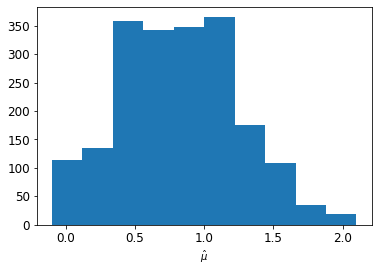

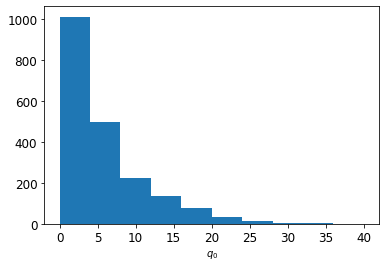

Z BL:(1.983267938592677, 0.8183072999002787, 1.014375, 1.9837646275325145, 0.8034489158063689)
Z:1.9857291441675442
Z_std:1.4405943715645209
Z_1:1.945351235497528
Z_std_1:1.6123066808194537
4
AUC:0.9028175915074012
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

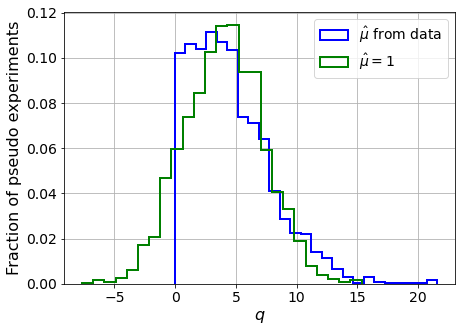

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  7155.16741932  6933.47167632
  6640.00526189  6281.12477749  5848.97218742  5328.07638065
  4695.77110259  3924.9591148   2995.5131482   1911.77382072
   623.67891279  -923.07861583 -2760.98523881 -5321.19913443]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4304.09645912  4325.78985861  4331.58745974


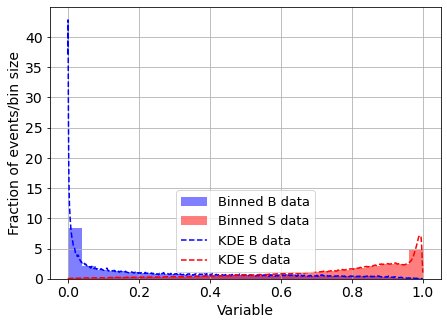

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.00971557576844804
0.00971557576844804
3 done
4 done
0.004367782649496947
0.004367782649496947


  0%|                                                                          | 0/2000 [00:00<?, ?it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45204344522354234
<p_{s}(Sdata)> = 2.030837850843111
<p_{b}(Bdata)> = 7.129769609728454
<p_{s}(Bdata)> = 0.42086722939226207


  2%|█▋                                                               | 50/2000 [00:14<08:12,  3.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4404288485059238
<p_{s}(Sdata)> = 2.05867209877875
<p_{b}(Bdata)> = 7.052854866072696
<p_{s}(Bdata)> = 0.4179816061915807


  5%|███                                                              | 94/2000 [00:29<11:32,  2.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4711188834256736
<p_{s}(Sdata)> = 1.8681360652144248
<p_{b}(Bdata)> = 7.109492338939551
<p_{s}(Bdata)> = 0.41832677938813734


  5%|███▎                                                            | 104/2000 [00:31<08:48,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42116003110232925
<p_{s}(Sdata)> = 1.9119783277066154
<p_{b}(Bdata)> = 7.200616298122894
<p_{s}(Bdata)> = 0.4215314795713715


  8%|█████▏                                                          | 163/2000 [00:48<08:52,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5688563423270177
<p_{s}(Sdata)> = 1.7934250903335096
<p_{b}(Bdata)> = 7.084175695886943
<p_{s}(Bdata)> = 0.4218135989338051


  8%|█████▎                                                          | 165/2000 [00:49<08:29,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48609661187203385
<p_{s}(Sdata)> = 1.7417133731341972
<p_{b}(Bdata)> = 7.091360367733892
<p_{s}(Bdata)> = 0.4191986727924182


 11%|██████▊                                                         | 213/2000 [01:03<07:52,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.425167647095371
<p_{s}(Sdata)> = 1.8337389022994661
<p_{b}(Bdata)> = 7.203041324211842
<p_{s}(Bdata)> = 0.4169313602606052


 11%|███████                                                         | 222/2000 [01:06<09:40,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4531148228301739
<p_{s}(Sdata)> = 1.9341951928042218
<p_{b}(Bdata)> = 7.097135207104907
<p_{s}(Bdata)> = 0.4187534877888153


 12%|███████▍                                                        | 231/2000 [01:09<11:21,  2.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4533772971157932
<p_{s}(Sdata)> = 1.9521192954037758
<p_{b}(Bdata)> = 6.905073677967576
<p_{s}(Bdata)> = 0.42466142392958134


 12%|███████▌                                                        | 238/2000 [01:11<08:01,  3.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4851120286358504
<p_{s}(Sdata)> = 1.8570597171631744
<p_{b}(Bdata)> = 7.076892655853281
<p_{s}(Bdata)> = 0.4258786051255578


 13%|████████▏                                                       | 254/2000 [01:16<09:51,  2.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39032640654566253
<p_{s}(Sdata)> = 2.2716983889424798
<p_{b}(Bdata)> = 7.062078946039114
<p_{s}(Bdata)> = 0.42185128170032815


 13%|████████▌                                                       | 269/2000 [01:20<07:36,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39373643372770695
<p_{s}(Sdata)> = 2.026534545493345
<p_{b}(Bdata)> = 7.205929856011061
<p_{s}(Bdata)> = 0.41938292653746434


 14%|████████▋                                                       | 273/2000 [01:21<08:12,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44740842656416224
<p_{s}(Sdata)> = 1.7834739928802417
<p_{b}(Bdata)> = 7.130762268540645
<p_{s}(Bdata)> = 0.4211628134651537


 14%|█████████                                                       | 283/2000 [01:24<09:18,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4420738275977464
<p_{s}(Sdata)> = 1.841136580891712
<p_{b}(Bdata)> = 7.140276411410991
<p_{s}(Bdata)> = 0.4210423396095651


 14%|█████████                                                       | 285/2000 [01:25<08:44,  3.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40127273936908087
<p_{s}(Sdata)> = 2.030333429736739
<p_{b}(Bdata)> = 7.113038663926508
<p_{s}(Bdata)> = 0.42010485672137354


 14%|█████████▎                                                      | 290/2000 [01:25<05:42,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4450883333344748
<p_{s}(Sdata)> = 1.9683333237932055
<p_{b}(Bdata)> = 6.953281767646763
<p_{s}(Bdata)> = 0.421104796696349


 15%|█████████▎                                                      | 291/2000 [01:26<05:48,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4261264628393285
<p_{s}(Sdata)> = 2.049952432578782
<p_{b}(Bdata)> = 7.11734820268773
<p_{s}(Bdata)> = 0.42131470407229055


 16%|██████████                                                      | 314/2000 [01:32<05:41,  4.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39365887780779973
<p_{s}(Sdata)> = 2.22603974020041
<p_{b}(Bdata)> = 7.347535123021364
<p_{s}(Bdata)> = 0.4137541880942398


 20%|█████████████                                                   | 408/2000 [02:01<05:01,  5.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5762582890134568
<p_{s}(Sdata)> = 2.050645195518881
<p_{b}(Bdata)> = 7.067770451845619
<p_{s}(Bdata)> = 0.41997456999476446


 21%|█████████████▏                                                  | 414/2000 [02:03<06:21,  4.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32935691401372025
<p_{s}(Sdata)> = 2.7526983571499923
<p_{b}(Bdata)> = 7.136702736497992
<p_{s}(Bdata)> = 0.4265871121724347


 21%|█████████████▍                                                  | 421/2000 [02:05<04:55,  5.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3853879702066239
<p_{s}(Sdata)> = 2.0615026345740617
<p_{b}(Bdata)> = 7.138492997699385
<p_{s}(Bdata)> = 0.4174868324160857
muhat = -0.1
<p_{b}(Sdata)> = 0.4532150011019262
<p_{s}(Sdata)> = 2.059495458205782
<p_{b}(Bdata)> = 7.147978046745499
<p_{s}(Bdata)> = 0.4161782033670299


 22%|██████████████▎                                                 | 449/2000 [02:12<06:58,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43381507331784225
<p_{s}(Sdata)> = 2.0570173769394526
<p_{b}(Bdata)> = 7.150865341185754
<p_{s}(Bdata)> = 0.4199283679013126


 24%|███████████████                                                 | 472/2000 [02:19<05:19,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39829515962113904
<p_{s}(Sdata)> = 2.159785550332616
<p_{b}(Bdata)> = 7.126452726300658
<p_{s}(Bdata)> = 0.4244620381972304


 24%|███████████████▏                                                | 475/2000 [02:19<06:51,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3976659290499196
<p_{s}(Sdata)> = 2.234690590998586
<p_{b}(Bdata)> = 7.268075467852276
<p_{s}(Bdata)> = 0.4138392345367834


 24%|███████████████▌                                                | 487/2000 [02:23<08:08,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5033651365167876
<p_{s}(Sdata)> = 1.8420658769452238
<p_{b}(Bdata)> = 7.104559407008734
<p_{s}(Bdata)> = 0.4223675923422562


 25%|████████████████                                                | 503/2000 [02:28<05:50,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4156388469519353
<p_{s}(Sdata)> = 2.117983687388062
<p_{b}(Bdata)> = 7.0500093181837205
<p_{s}(Bdata)> = 0.4189607294220187


 25%|████████████████▏                                               | 504/2000 [02:28<05:48,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4357625939441259
<p_{s}(Sdata)> = 1.800698363669986
<p_{b}(Bdata)> = 7.176725965231077
<p_{s}(Bdata)> = 0.41316039324275844


 25%|████████████████▏                                               | 506/2000 [02:28<05:46,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36029205515108137
<p_{s}(Sdata)> = 2.301194605882895
<p_{b}(Bdata)> = 7.136981195677912
<p_{s}(Bdata)> = 0.4245179237265538


 29%|██████████████████▍                                             | 576/2000 [02:49<06:37,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4083008241276602
<p_{s}(Sdata)> = 2.142514854970588
<p_{b}(Bdata)> = 7.108688957652451
<p_{s}(Bdata)> = 0.42042970820484804


 29%|██████████████████▌                                             | 582/2000 [02:50<06:33,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4390073273413767
<p_{s}(Sdata)> = 2.081197214625339
<p_{b}(Bdata)> = 6.970790214772462
<p_{s}(Bdata)> = 0.4258248694878878


 30%|███████████████████▏                                            | 598/2000 [02:55<05:01,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45718041860997893
<p_{s}(Sdata)> = 1.8629989630984871
<p_{b}(Bdata)> = 6.971669600807617
<p_{s}(Bdata)> = 0.42278785075172864
muhat = -0.1
<p_{b}(Sdata)> = 0.497980668539564
<p_{s}(Sdata)> = 2.0173669336039324
<p_{b}(Bdata)> = 6.955122597904497
<p_{s}(Bdata)> = 0.42180665933797235


 31%|████████████████████▏                                           | 629/2000 [03:04<06:48,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39643357840477494
<p_{s}(Sdata)> = 2.069565729558805
<p_{b}(Bdata)> = 7.190795502108232
<p_{s}(Bdata)> = 0.41725085116330657


 32%|████████████████████▍                                           | 638/2000 [03:07<05:07,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41857707409977507
<p_{s}(Sdata)> = 1.8741162450879256
<p_{b}(Bdata)> = 7.09085233543154
<p_{s}(Bdata)> = 0.42158487741507983


 32%|████████████████████▊                                           | 650/2000 [03:11<09:21,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4910509742727277
<p_{s}(Sdata)> = 2.004040685237314
<p_{b}(Bdata)> = 7.126981689624717
<p_{s}(Bdata)> = 0.4210352642108053


 34%|█████████████████████▋                                          | 678/2000 [03:20<06:46,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42684055080550876
<p_{s}(Sdata)> = 1.8630169933387564
<p_{b}(Bdata)> = 7.156596093544974
<p_{s}(Bdata)> = 0.4171565566236863


 34%|█████████████████████▊                                          | 683/2000 [03:21<06:04,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3667360201706048
<p_{s}(Sdata)> = 2.391506244527541
<p_{b}(Bdata)> = 6.999142467422655
<p_{s}(Bdata)> = 0.4140289933400983


 36%|███████████████████████▏                                        | 723/2000 [03:32<05:55,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36965303801871924
<p_{s}(Sdata)> = 2.2942012607205458
<p_{b}(Bdata)> = 7.085756830807492
<p_{s}(Bdata)> = 0.4217281990568885


 36%|███████████████████████▏                                        | 726/2000 [03:33<05:11,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4338680685420041
<p_{s}(Sdata)> = 2.001086208360906
<p_{b}(Bdata)> = 7.0741029215391835
<p_{s}(Bdata)> = 0.42074750776817016


 37%|███████████████████████▍                                        | 734/2000 [03:36<07:32,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38336574008261975
<p_{s}(Sdata)> = 2.0985050636375218
<p_{b}(Bdata)> = 7.023946848450374
<p_{s}(Bdata)> = 0.42405363618631486


 37%|███████████████████████▊                                        | 743/2000 [03:38<07:15,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5252373574165147
<p_{s}(Sdata)> = 2.0183576703980335
<p_{b}(Bdata)> = 7.078307297142162
<p_{s}(Bdata)> = 0.41978963641996175


 38%|████████████████████████▍                                       | 763/2000 [03:44<04:09,  4.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5720896930960238
<p_{s}(Sdata)> = 1.891247803735172
<p_{b}(Bdata)> = 7.055258002608211
<p_{s}(Bdata)> = 0.4190770061628421


 39%|████████████████████████▉                                       | 781/2000 [03:50<05:32,  3.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4431051343340864
<p_{s}(Sdata)> = 1.915878318428812
<p_{b}(Bdata)> = 7.055872076056909
<p_{s}(Bdata)> = 0.41657053673044336


 39%|█████████████████████████▏                                      | 789/2000 [03:52<06:19,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.443020931173984
<p_{s}(Sdata)> = 2.0668878947553746
<p_{b}(Bdata)> = 7.203619576270074
<p_{s}(Bdata)> = 0.4213865234808581


 41%|██████████████████████████                                      | 814/2000 [03:59<05:20,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41110048001199306
<p_{s}(Sdata)> = 2.0944543139606697
<p_{b}(Bdata)> = 7.024006306406778
<p_{s}(Bdata)> = 0.4249832545405199


 42%|██████████████████████████▊                                     | 837/2000 [04:06<04:44,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45098959574053493
<p_{s}(Sdata)> = 2.1492911823565466
<p_{b}(Bdata)> = 7.028945590435165
<p_{s}(Bdata)> = 0.42333273830230145
muhat = -0.1
<p_{b}(Sdata)> = 0.4739564215785177
<p_{s}(Sdata)> = 1.851185631342793
<p_{b}(Bdata)> = 7.050156229955449
<p_{s}(Bdata)> = 0.419334025406079


 42%|███████████████████████████                                     | 844/2000 [04:08<04:23,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40424824785733776
<p_{s}(Sdata)> = 2.109664208717643
<p_{b}(Bdata)> = 7.125941911125965
<p_{s}(Bdata)> = 0.4192423337909343


 43%|███████████████████████████▌                                    | 863/2000 [04:13<04:14,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5083404511022326
<p_{s}(Sdata)> = 1.6537112270464056
<p_{b}(Bdata)> = 7.055932797704325
<p_{s}(Bdata)> = 0.4215287382533886


 44%|████████████████████████████▏                                   | 879/2000 [04:18<05:15,  3.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4054677551372309
<p_{s}(Sdata)> = 2.1131268018243046
<p_{b}(Bdata)> = 7.058606957379859
<p_{s}(Bdata)> = 0.4220366113694293


 44%|████████████████████████████▎                                   | 883/2000 [04:19<04:36,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40658873098883297
<p_{s}(Sdata)> = 2.08888726248478
<p_{b}(Bdata)> = 7.213924412427976
<p_{s}(Bdata)> = 0.42428569023612955


 45%|████████████████████████████▌                                   | 894/2000 [04:21<03:55,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4811100307643303
<p_{s}(Sdata)> = 1.9025931652324468
<p_{b}(Bdata)> = 7.144462325670305
<p_{s}(Bdata)> = 0.4189574700239665
muhat = 2.1
<p_{b}(Sdata)> = 0.40116561687688784
<p_{s}(Sdata)> = 2.4703604995451776
<p_{b}(Bdata)> = 7.12257378936628
<p_{s}(Bdata)> = 0.4336475831362972


 45%|████████████████████████████▊                                   | 902/2000 [04:24<05:53,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48052975563284533
<p_{s}(Sdata)> = 1.7075492437325537
<p_{b}(Bdata)> = 7.045363923200822
<p_{s}(Bdata)> = 0.4207062473226359


 46%|█████████████████████████████▏                                  | 914/2000 [04:27<03:46,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4305249652569859
<p_{s}(Sdata)> = 1.939538965616926
<p_{b}(Bdata)> = 7.1987048545896
<p_{s}(Bdata)> = 0.4270899665144596
muhat = -0.1
<p_{b}(Sdata)> = 0.46288239702174216
<p_{s}(Sdata)> = 1.717924289996795
<p_{b}(Bdata)> = 7.177981343323251
<p_{s}(Bdata)> = 0.42209717309112055


 46%|█████████████████████████████▎                                  | 917/2000 [04:29<05:25,  3.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4578092247961901
<p_{s}(Sdata)> = 1.9268511077217614
<p_{b}(Bdata)> = 7.116463673467523
<p_{s}(Bdata)> = 0.42205218530490696


 47%|█████████████████████████████▊                                  | 931/2000 [04:33<06:25,  2.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.519301565107887
<p_{s}(Sdata)> = 1.7963050993996088
<p_{b}(Bdata)> = 7.064061942858683
<p_{s}(Bdata)> = 0.4214911650623668


 48%|██████████████████████████████▍                                 | 952/2000 [04:39<05:25,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.423261286649004
<p_{s}(Sdata)> = 2.1279146761521432
<p_{b}(Bdata)> = 7.163674750205193
<p_{s}(Bdata)> = 0.42097633856183614


 50%|███████████████████████████████▌                               | 1002/2000 [04:55<05:50,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4408367989059523
<p_{s}(Sdata)> = 1.8299027327454729
<p_{b}(Bdata)> = 6.926849779811368
<p_{s}(Bdata)> = 0.42761770285905626


 50%|███████████████████████████████▋                               | 1007/2000 [04:56<03:42,  4.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41553409078772263
<p_{s}(Sdata)> = 2.0354962281384537
<p_{b}(Bdata)> = 7.0437855700207095
<p_{s}(Bdata)> = 0.42437059666075044


 51%|███████████████████████████████▉                               | 1012/2000 [04:57<02:47,  5.90it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31649708245507663
<p_{s}(Sdata)> = 2.856964225954024
<p_{b}(Bdata)> = 7.080062178511736
<p_{s}(Bdata)> = 0.43021675239816654


 51%|███████████████████████████████▉                               | 1013/2000 [04:57<03:32,  4.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5978571749419241
<p_{s}(Sdata)> = 2.1705377885914374
<p_{b}(Bdata)> = 7.054947208501705
<p_{s}(Bdata)> = 0.4216793047657412


 51%|████████████████████████████████▎                              | 1027/2000 [05:01<04:01,  4.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3630024221669732
<p_{s}(Sdata)> = 2.4825328252870227
<p_{b}(Bdata)> = 7.066980868338531
<p_{s}(Bdata)> = 0.4291019163329114


 52%|████████████████████████████████▍                              | 1031/2000 [05:02<03:29,  4.63it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37312932306429675
<p_{s}(Sdata)> = 2.938674064983938
<p_{b}(Bdata)> = 7.042855704871935
<p_{s}(Bdata)> = 0.4299868110179361


 52%|████████████████████████████████▋                              | 1039/2000 [05:04<03:52,  4.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4042512838112052
<p_{s}(Sdata)> = 2.4153203730098487
<p_{b}(Bdata)> = 7.153832505100445
<p_{s}(Bdata)> = 0.432522980904184


 53%|█████████████████████████████████▎                             | 1058/2000 [05:10<04:20,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4311395012822979
<p_{s}(Sdata)> = 2.02214010070683
<p_{b}(Bdata)> = 7.099237135618748
<p_{s}(Bdata)> = 0.4263297537732758


 55%|██████████████████████████████████▍                            | 1094/2000 [05:21<04:41,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43493561244616785
<p_{s}(Sdata)> = 1.7809130806835667
<p_{b}(Bdata)> = 7.01886053759021
<p_{s}(Bdata)> = 0.4256138457870832


 57%|███████████████████████████████████▉                           | 1140/2000 [05:35<04:04,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41406160631201533
<p_{s}(Sdata)> = 1.9186039556499421
<p_{b}(Bdata)> = 7.02601707214964
<p_{s}(Bdata)> = 0.42452525643354133


 57%|████████████████████████████████████▏                          | 1149/2000 [05:38<04:25,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3974827571786928
<p_{s}(Sdata)> = 2.1307060585829856
<p_{b}(Bdata)> = 7.108629594666249
<p_{s}(Bdata)> = 0.42117374157461723


 58%|████████████████████████████████████▎                          | 1152/2000 [05:39<04:23,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.415398841036033
<p_{s}(Sdata)> = 2.0231964540462166
<p_{b}(Bdata)> = 7.043543607914459
<p_{s}(Bdata)> = 0.4217786814511645


 58%|████████████████████████████████████▍                          | 1157/2000 [05:40<03:55,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4063372597386809
<p_{s}(Sdata)> = 2.1189033590146975
<p_{b}(Bdata)> = 7.085746345599663
<p_{s}(Bdata)> = 0.41908317117292077


 59%|█████████████████████████████████████                          | 1175/2000 [05:45<03:20,  4.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4661404250435326
<p_{s}(Sdata)> = 1.9562041593568205
<p_{b}(Bdata)> = 7.053304480245804
<p_{s}(Bdata)> = 0.41990443139105527


 59%|█████████████████████████████████████▏                         | 1180/2000 [05:46<02:32,  5.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44278200825228176
<p_{s}(Sdata)> = 2.025188702873263
<p_{b}(Bdata)> = 7.082697810321626
<p_{s}(Bdata)> = 0.4166438268667578
muhat = -0.1
<p_{b}(Sdata)> = 0.42218528252621196
<p_{s}(Sdata)> = 1.945533002717529
<p_{b}(Bdata)> = 7.027763112439892
<p_{s}(Bdata)> = 0.42348202995889467


 59%|█████████████████████████████████████▎                         | 1183/2000 [05:47<03:10,  4.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4466005495652676
<p_{s}(Sdata)> = 2.0989801625522047
<p_{b}(Bdata)> = 7.041336165817704
<p_{s}(Bdata)> = 0.4186316849986821


 60%|█████████████████████████████████████▋                         | 1197/2000 [05:52<04:51,  2.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4233271179684189
<p_{s}(Sdata)> = 2.0837448391902678
<p_{b}(Bdata)> = 7.040623717712226
<p_{s}(Bdata)> = 0.4195010869755582


 61%|██████████████████████████████████████▍                        | 1220/2000 [05:58<02:34,  5.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4200493145584853
<p_{s}(Sdata)> = 2.015248011383728
<p_{b}(Bdata)> = 7.031609902425252
<p_{s}(Bdata)> = 0.42303402019765923


 61%|██████████████████████████████████████▋                        | 1227/2000 [05:59<02:11,  5.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5121598935083598
<p_{s}(Sdata)> = 1.7330392762610665
<p_{b}(Bdata)> = 7.141261934638886
<p_{s}(Bdata)> = 0.41749128885535347
muhat = -0.1
<p_{b}(Sdata)> = 0.3940276936081931
<p_{s}(Sdata)> = 2.07941994381628
<p_{b}(Bdata)> = 7.094200058118816
<p_{s}(Bdata)> = 0.42092925192104935
muhat = -0.1
<p_{b}(Sdata)> = 0.42427724115596327
<p_{s}(Sdata)> = 1.9595103018323567
<p_{b}(Bdata)> = 7.103977181280777
<p_{s}(Bdata)> = 0.4195112035621832


 62%|██████████████████████████████████████▋                        | 1230/2000 [06:00<03:20,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4535250804394912
<p_{s}(Sdata)> = 1.8231109899751052
<p_{b}(Bdata)> = 6.9754528871951855
<p_{s}(Bdata)> = 0.42531682258883696


 62%|███████████████████████████████████████                        | 1240/2000 [06:03<04:09,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45004472816333235
<p_{s}(Sdata)> = 1.871562419759088
<p_{b}(Bdata)> = 7.097045004914768
<p_{s}(Bdata)> = 0.4213021482279334


 62%|███████████████████████████████████████▎                       | 1249/2000 [06:06<03:42,  3.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.40413305462677085
<p_{s}(Sdata)> = 2.282749017299825
<p_{b}(Bdata)> = 7.025529787898394
<p_{s}(Bdata)> = 0.4311766848702399


 63%|███████████████████████████████████████▌                       | 1256/2000 [06:08<03:08,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45310347579289884
<p_{s}(Sdata)> = 2.001097741433755
<p_{b}(Bdata)> = 7.097314467064332
<p_{s}(Bdata)> = 0.420277031633574


 63%|███████████████████████████████████████▊                       | 1263/2000 [06:10<04:05,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48756202253269415
<p_{s}(Sdata)> = 1.9633947669529388
<p_{b}(Bdata)> = 6.923004994900355
<p_{s}(Bdata)> = 0.42430579393475165


 64%|████████████████████████████████████████▏                      | 1275/2000 [06:15<04:25,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4363965928439072
<p_{s}(Sdata)> = 2.219017746453039
<p_{b}(Bdata)> = 7.1829588884929025
<p_{s}(Bdata)> = 0.41706877344748977


 64%|████████████████████████████████████████▎                      | 1281/2000 [06:16<02:39,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42720902042258974
<p_{s}(Sdata)> = 1.8949614152088257
<p_{b}(Bdata)> = 7.155975491441397
<p_{s}(Bdata)> = 0.41761257285366254
muhat = -0.1
<p_{b}(Sdata)> = 0.4118722887022864
<p_{s}(Sdata)> = 1.7759287893545674
<p_{b}(Bdata)> = 7.055245850831543
<p_{s}(Bdata)> = 0.4247147043570114


 64%|████████████████████████████████████████▌                      | 1289/2000 [06:19<04:39,  2.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45552865798430175
<p_{s}(Sdata)> = 1.6412444835250037
<p_{b}(Bdata)> = 7.229196070278223
<p_{s}(Bdata)> = 0.4215315200486622


 65%|████████████████████████████████████████▋                      | 1293/2000 [06:20<03:07,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4318209346199924
<p_{s}(Sdata)> = 1.940648203422386
<p_{b}(Bdata)> = 7.0515330582176805
<p_{s}(Bdata)> = 0.418968005623654


 66%|█████████████████████████████████████████▎                     | 1312/2000 [06:25<03:20,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5217278458648528
<p_{s}(Sdata)> = 1.9088438476207996
<p_{b}(Bdata)> = 7.078922114455282
<p_{s}(Bdata)> = 0.42008087922307763


 68%|██████████████████████████████████████████▋                    | 1357/2000 [06:39<03:19,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.453891097730122
<p_{s}(Sdata)> = 1.956945771847376
<p_{b}(Bdata)> = 7.257797538726379
<p_{s}(Bdata)> = 0.42287058657726717


 68%|██████████████████████████████████████████▊                    | 1360/2000 [06:40<02:54,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3907164141534758
<p_{s}(Sdata)> = 2.1379359802943125
<p_{b}(Bdata)> = 7.220110808696752
<p_{s}(Bdata)> = 0.4193268285522115


 68%|██████████████████████████████████████████▉                    | 1362/2000 [06:40<02:35,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3898425590753948
<p_{s}(Sdata)> = 2.2569112875524207
<p_{b}(Bdata)> = 7.094303256211831
<p_{s}(Bdata)> = 0.4191946709501


 69%|███████████████████████████████████████████▋                   | 1388/2000 [06:48<02:45,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4599064803838139
<p_{s}(Sdata)> = 1.8918777532086146
<p_{b}(Bdata)> = 7.053344789747187
<p_{s}(Bdata)> = 0.4212568104189549


 71%|████████████████████████████████████████████▋                  | 1420/2000 [06:59<03:39,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7052982120747598
<p_{s}(Sdata)> = 1.9038556803827864
<p_{b}(Bdata)> = 7.03980884396383
<p_{s}(Bdata)> = 0.41861361119024754


 72%|█████████████████████████████████████████████▏                 | 1434/2000 [07:02<02:32,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4160972304437476
<p_{s}(Sdata)> = 2.1466174423882407
<p_{b}(Bdata)> = 7.07632265233812
<p_{s}(Bdata)> = 0.41490288548432525


 72%|█████████████████████████████████████████████▍                 | 1443/2000 [07:04<02:22,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38968037313790754
<p_{s}(Sdata)> = 2.3762617138686255
<p_{b}(Bdata)> = 7.242304369528684
<p_{s}(Bdata)> = 0.4163384247702974


 73%|██████████████████████████████████████████████                 | 1463/2000 [07:10<02:39,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42503352264480526
<p_{s}(Sdata)> = 2.140545467384864
<p_{b}(Bdata)> = 7.030611144360177
<p_{s}(Bdata)> = 0.4199281213194714


 73%|██████████████████████████████████████████████▏                | 1466/2000 [07:11<02:53,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4062714207414086
<p_{s}(Sdata)> = 2.1678193977739415
<p_{b}(Bdata)> = 7.093333810910555
<p_{s}(Bdata)> = 0.4238070434881481


 74%|██████████████████████████████████████████████▎                | 1472/2000 [07:13<02:36,  3.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4447559387885698
<p_{s}(Sdata)> = 1.9535612124347235
<p_{b}(Bdata)> = 7.058475532673349
<p_{s}(Bdata)> = 0.41972535506632314


 74%|██████████████████████████████████████████████▍                | 1475/2000 [07:14<02:34,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41127867526099193
<p_{s}(Sdata)> = 2.030347666290099
<p_{b}(Bdata)> = 7.10318459500974
<p_{s}(Bdata)> = 0.4202523683485248


 76%|███████████████████████████████████████████████▉               | 1523/2000 [07:29<03:47,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4579539466661503
<p_{s}(Sdata)> = 1.8475461479858644
<p_{b}(Bdata)> = 7.198030838955287
<p_{s}(Bdata)> = 0.42080023516834325


 77%|████████████████████████████████████████████████▎              | 1535/2000 [07:32<02:18,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37554992162268025
<p_{s}(Sdata)> = 2.450009450240668
<p_{b}(Bdata)> = 7.03607776898525
<p_{s}(Bdata)> = 0.4131750405469698


 77%|████████████████████████████████████████████████▍              | 1537/2000 [07:33<01:50,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.508367864299712
<p_{s}(Sdata)> = 2.1417247732004867
<p_{b}(Bdata)> = 7.069527041041106
<p_{s}(Bdata)> = 0.42080493054769735


 77%|████████████████████████████████████████████████▋              | 1547/2000 [07:36<02:06,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5445680635689917
<p_{s}(Sdata)> = 2.005623704137793
<p_{b}(Bdata)> = 7.218927337764958
<p_{s}(Bdata)> = 0.42145604562472905


 78%|████████████████████████████████████████████████▉              | 1552/2000 [07:37<02:22,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46158575170905564
<p_{s}(Sdata)> = 2.2222534718494606
<p_{b}(Bdata)> = 7.007132900799151
<p_{s}(Bdata)> = 0.42353690389438076


 78%|█████████████████████████████████████████████████              | 1556/2000 [07:38<01:52,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46986718789426246
<p_{s}(Sdata)> = 1.8483567295219139
<p_{b}(Bdata)> = 7.113439892616203
<p_{s}(Bdata)> = 0.41749835984242323


 78%|█████████████████████████████████████████████████▎             | 1567/2000 [07:41<01:52,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4118498240471168
<p_{s}(Sdata)> = 2.1425869091422856
<p_{b}(Bdata)> = 7.280974303778309
<p_{s}(Bdata)> = 0.4152096461498122


 79%|█████████████████████████████████████████████████▌             | 1572/2000 [07:42<01:42,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38756437271489186
<p_{s}(Sdata)> = 2.2131980931347046
<p_{b}(Bdata)> = 7.187727712304113
<p_{s}(Bdata)> = 0.417526730738912


 80%|██████████████████████████████████████████████████▏            | 1593/2000 [07:48<01:14,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49343011631723266
<p_{s}(Sdata)> = 2.185039285448788
<p_{b}(Bdata)> = 7.19067497321453
<p_{s}(Bdata)> = 0.4182835074063111
muhat = -0.1
<p_{b}(Sdata)> = 0.48523822766726077
<p_{s}(Sdata)> = 1.9544599686128703
<p_{b}(Bdata)> = 7.132133697653526
<p_{s}(Bdata)> = 0.4229834981577313


 80%|██████████████████████████████████████████████████▍            | 1603/2000 [07:50<01:08,  5.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4354881670558353
<p_{s}(Sdata)> = 1.982910009324799
<p_{b}(Bdata)> = 7.094724132293768
<p_{s}(Bdata)> = 0.4200988215535009


 81%|██████████████████████████████████████████████████▉            | 1616/2000 [07:54<02:05,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4263487331759853
<p_{s}(Sdata)> = 2.017837073851714
<p_{b}(Bdata)> = 7.0302909517072685
<p_{s}(Bdata)> = 0.4267553604673112


 81%|███████████████████████████████████████████████████            | 1622/2000 [07:56<01:52,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4420445988110911
<p_{s}(Sdata)> = 1.9874723317088328
<p_{b}(Bdata)> = 7.073712210409215
<p_{s}(Bdata)> = 0.41873437080409487


 82%|███████████████████████████████████████████████████▋           | 1641/2000 [08:02<02:11,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5275553114660002
<p_{s}(Sdata)> = 1.9384965745997995
<p_{b}(Bdata)> = 7.001953973398048
<p_{s}(Bdata)> = 0.42038986687779606


 83%|████████████████████████████████████████████████████▍          | 1665/2000 [08:09<01:02,  5.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44276140587578816
<p_{s}(Sdata)> = 2.0238759426896054
<p_{b}(Bdata)> = 7.135460073398833
<p_{s}(Bdata)> = 0.420288773542594
muhat = -0.1
<p_{b}(Sdata)> = 0.4282751577417464
<p_{s}(Sdata)> = 1.9454825044118165
<p_{b}(Bdata)> = 7.0518469497724094
<p_{s}(Bdata)> = 0.4185492739124362


 84%|████████████████████████████████████████████████████▌          | 1670/2000 [08:10<01:09,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4604461120094491
<p_{s}(Sdata)> = 1.8121394898732408
<p_{b}(Bdata)> = 7.086507647005276
<p_{s}(Bdata)> = 0.4205240750939861


 84%|█████████████████████████████████████████████████████          | 1684/2000 [08:14<01:42,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46793715966685046
<p_{s}(Sdata)> = 1.907470905371714
<p_{b}(Bdata)> = 7.164107300906885
<p_{s}(Bdata)> = 0.4151904321838946


 85%|█████████████████████████████████████████████████████▋         | 1705/2000 [08:19<00:56,  5.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5095823779337473
<p_{s}(Sdata)> = 1.8715797253067417
<p_{b}(Bdata)> = 7.082238148073211
<p_{s}(Bdata)> = 0.4177088820523948
muhat = -0.1
<p_{b}(Sdata)> = 0.41415159145713804
<p_{s}(Sdata)> = 1.9026387438200056
<p_{b}(Bdata)> = 7.004373055877433
<p_{s}(Bdata)> = 0.42025796175817964


 88%|███████████████████████████████████████████████████████▋       | 1766/2000 [08:38<01:22,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.503102564808686
<p_{s}(Sdata)> = 1.7218953421670677
<p_{b}(Bdata)> = 7.224607536840146
<p_{s}(Bdata)> = 0.42411556732335837


 88%|███████████████████████████████████████████████████████▊       | 1770/2000 [08:40<01:17,  2.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4811160125322554
<p_{s}(Sdata)> = 1.8955048071163176
<p_{b}(Bdata)> = 7.232198498857064
<p_{s}(Bdata)> = 0.4204713650661657


 89%|████████████████████████████████████████████████████████▏      | 1785/2000 [08:44<00:53,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3985581746479219
<p_{s}(Sdata)> = 2.0599251196856128
<p_{b}(Bdata)> = 6.98315782443252
<p_{s}(Bdata)> = 0.4170934929744654


 90%|████████████████████████████████████████████████████████▌      | 1796/2000 [08:46<00:46,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4310591177592466
<p_{s}(Sdata)> = 2.0876625719775714
<p_{b}(Bdata)> = 7.061291810923528
<p_{s}(Bdata)> = 0.42029967189691514


 92%|█████████████████████████████████████████████████████████▋     | 1830/2000 [08:56<00:34,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4230927314140967
<p_{s}(Sdata)> = 1.818405194668114
<p_{b}(Bdata)> = 7.0083684734322915
<p_{s}(Bdata)> = 0.4224964641569174


 92%|██████████████████████████████████████████████████████████     | 1843/2000 [08:59<00:50,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36786117335887614
<p_{s}(Sdata)> = 2.335214711095731
<p_{b}(Bdata)> = 7.120398785758694
<p_{s}(Bdata)> = 0.42352878503985864


 92%|██████████████████████████████████████████████████████████▏    | 1847/2000 [09:00<00:30,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46675944642217193
<p_{s}(Sdata)> = 1.7289481181572823
<p_{b}(Bdata)> = 7.055792269432757
<p_{s}(Bdata)> = 0.4230422206146942
muhat = -0.1
<p_{b}(Sdata)> = 0.469406360655851
<p_{s}(Sdata)> = 1.9294192480170467
<p_{b}(Bdata)> = 7.053645697782158
<p_{s}(Bdata)> = 0.42156261556484925


 93%|██████████████████████████████████████████████████████████▊    | 1867/2000 [09:06<00:32,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43564575477374334
<p_{s}(Sdata)> = 1.9664806743644092
<p_{b}(Bdata)> = 7.070976156778946
<p_{s}(Bdata)> = 0.4233360572629833


 97%|█████████████████████████████████████████████████████████████▏ | 1942/2000 [09:27<00:10,  5.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4176856218089042
<p_{s}(Sdata)> = 2.071141826343933
<p_{b}(Bdata)> = 7.12901610322055
<p_{s}(Bdata)> = 0.4218548983280518
muhat = -0.1
<p_{b}(Sdata)> = 0.4471580477365602
<p_{s}(Sdata)> = 2.108096795269039
<p_{b}(Bdata)> = 7.030258628229094
<p_{s}(Bdata)> = 0.419430468580396


 97%|█████████████████████████████████████████████████████████████▍ | 1949/2000 [09:29<00:14,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4166461161565535
<p_{s}(Sdata)> = 1.8501625260139458
<p_{b}(Bdata)> = 7.058375633011198
<p_{s}(Bdata)> = 0.4189899803269773


 98%|█████████████████████████████████████████████████████████████▌ | 1953/2000 [09:29<00:08,  5.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4667921930814626
<p_{s}(Sdata)> = 1.7003897022075758
<p_{b}(Bdata)> = 7.095628284071111
<p_{s}(Bdata)> = 0.42424480053585034


 98%|█████████████████████████████████████████████████████████████▋ | 1960/2000 [09:31<00:12,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37901662331985875
<p_{s}(Sdata)> = 2.133331291265307
<p_{b}(Bdata)> = 7.20115753054973
<p_{s}(Bdata)> = 0.4168358310948229


100%|██████████████████████████████████████████████████████████████▊| 1994/2000 [09:42<00:01,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4005646840427317
<p_{s}(Sdata)> = 1.919033416951559
<p_{b}(Bdata)> = 7.1604837460361495
<p_{s}(Bdata)> = 0.41726789966835287


100%|███████████████████████████████████████████████████████████████| 2000/2000 [09:43<00:00,  3.43it/s]


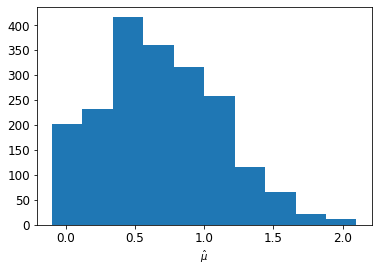

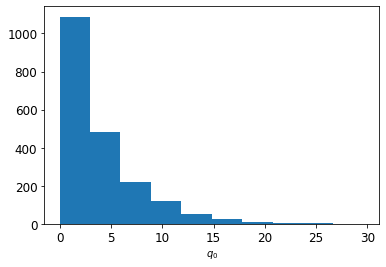

Z BL:(2.004282529268094, 0.8238683012051201, 1.020925, 2.0047598271858957, 0.8094650341450361)
Z:1.586271515978786
Z_std:1.2402455708504445
Z_1:1.3505822412450843
Z_std_1:1.8887086442821825
5
AUC:0.902509099540478
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

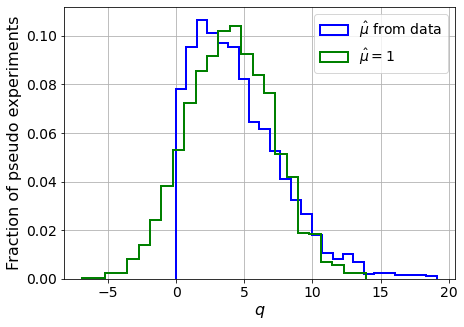

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  6810.09252896  6612.45545595
  6355.28846484  6032.13785007  5631.17854369  5140.53290279
  4540.42000669  3816.86339839  2941.54193144  1889.00921845
   621.06229599  -895.60645041 -2708.10499868 -5299.85231282]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4270.98574733  4277.19520785


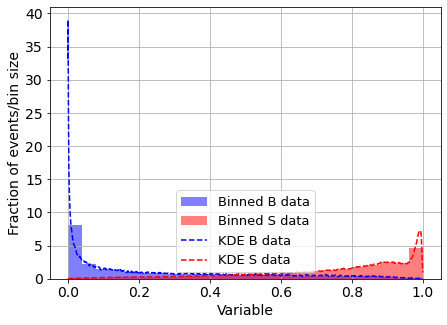

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.024279861808536748
0.024279861808536748
3 done
4 done
0.0
2.0992845004687856e-05


  1%|▍                                                                | 14/2000 [00:03<08:39,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.415518921352753
<p_{s}(Sdata)> = 1.8883380306809212
<p_{b}(Bdata)> = 6.243585016998719
<p_{s}(Bdata)> = 0.41849240063768656


  1%|▋                                                                | 21/2000 [00:05<07:45,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4084096276314534
<p_{s}(Sdata)> = 2.108824988640831
<p_{b}(Bdata)> = 6.244844687165643
<p_{s}(Bdata)> = 0.42309004044807935


  2%|█▌                                                               | 48/2000 [00:12<06:52,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4341697736161819
<p_{s}(Sdata)> = 2.0109242183616147
<p_{b}(Bdata)> = 6.239172229754659
<p_{s}(Bdata)> = 0.4200512700728268


  3%|█▋                                                               | 51/2000 [00:13<10:44,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4524429497160492
<p_{s}(Sdata)> = 1.9002868008797944
<p_{b}(Bdata)> = 6.3376699608402705
<p_{s}(Bdata)> = 0.4160886372100342


  4%|██▊                                                              | 86/2000 [00:24<08:44,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42921277538440544
<p_{s}(Sdata)> = 2.2221226468502886
<p_{b}(Bdata)> = 6.284057748819517
<p_{s}(Bdata)> = 0.41602979634714876


  5%|███▏                                                             | 98/2000 [00:27<09:18,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3837023456952088
<p_{s}(Sdata)> = 2.1867203621435687
<p_{b}(Bdata)> = 6.251642607980527
<p_{s}(Bdata)> = 0.42075270605482096


  6%|███▌                                                            | 110/2000 [00:31<07:32,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6251072671439456
<p_{s}(Sdata)> = 1.6310288707875795
<p_{b}(Bdata)> = 6.235357637744321
<p_{s}(Bdata)> = 0.41821086016866404


  6%|███▊                                                            | 120/2000 [00:33<06:47,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44194748790437893
<p_{s}(Sdata)> = 1.7531893502788718
<p_{b}(Bdata)> = 6.362002120028356
<p_{s}(Bdata)> = 0.4151212826630097
muhat = -0.1
<p_{b}(Sdata)> = 0.4565400757265476
<p_{s}(Sdata)> = 2.0874796335823493
<p_{b}(Bdata)> = 6.4065510382782
<p_{s}(Bdata)> = 0.413643832171095


  7%|████▌                                                           | 141/2000 [00:40<10:15,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45539696949235836
<p_{s}(Sdata)> = 1.8760091553543876
<p_{b}(Bdata)> = 6.4188902567023405
<p_{s}(Bdata)> = 0.4147783079442286


  7%|████▌                                                           | 144/2000 [00:40<07:41,  4.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4173869331195995
<p_{s}(Sdata)> = 1.957604269717297
<p_{b}(Bdata)> = 6.2783785931442955
<p_{s}(Bdata)> = 0.42060412248053786


  8%|█████                                                           | 158/2000 [00:44<07:25,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4226282058973701
<p_{s}(Sdata)> = 2.04128780059135
<p_{b}(Bdata)> = 6.257763188827418
<p_{s}(Bdata)> = 0.424121211207513


  9%|█████▋                                                          | 178/2000 [00:49<05:40,  5.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4132054031512945
<p_{s}(Sdata)> = 1.9559764581163834
<p_{b}(Bdata)> = 6.333732640592786
<p_{s}(Bdata)> = 0.41916031281957056
muhat = -0.1
<p_{b}(Sdata)> = 0.44739530150879575
<p_{s}(Sdata)> = 1.9281776700649906
<p_{b}(Bdata)> = 6.376994186225509
<p_{s}(Bdata)> = 0.41592243644607274


 11%|███████▏                                                        | 224/2000 [01:02<09:33,  3.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.488213571383644
<p_{s}(Sdata)> = 1.7997879982230582
<p_{b}(Bdata)> = 6.319075595223719
<p_{s}(Bdata)> = 0.4172054938708375


 12%|███████▉                                                        | 248/2000 [01:08<05:30,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4319156476841452
<p_{s}(Sdata)> = 2.0639953239696256
<p_{b}(Bdata)> = 6.434838721288169
<p_{s}(Bdata)> = 0.4128534686010992


 13%|████████                                                        | 251/2000 [01:09<05:06,  5.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4266032776943103
<p_{s}(Sdata)> = 1.8722893724068423
<p_{b}(Bdata)> = 6.346517602386081
<p_{s}(Bdata)> = 0.42021966438368563
muhat = -0.1
<p_{b}(Sdata)> = 0.4390467733591411
<p_{s}(Sdata)> = 1.7625720196340977
<p_{b}(Bdata)> = 6.1424308337176505
<p_{s}(Bdata)> = 0.42642799218707916


 13%|████████▎                                                       | 258/2000 [01:10<06:14,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4527925297843859
<p_{s}(Sdata)> = 2.0109101154021807
<p_{b}(Bdata)> = 6.304224276548843
<p_{s}(Bdata)> = 0.41534839420846204


 13%|████████▍                                                       | 262/2000 [01:11<07:48,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4337575848689637
<p_{s}(Sdata)> = 1.8275669579292309
<p_{b}(Bdata)> = 6.472231323436374
<p_{s}(Bdata)> = 0.41726314025218136


 13%|████████▌                                                       | 269/2000 [01:13<06:18,  4.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40313483702515657
<p_{s}(Sdata)> = 2.1347484999021873
<p_{b}(Bdata)> = 6.355748740699817
<p_{s}(Bdata)> = 0.416816505334087


 15%|█████████▊                                                      | 305/2000 [01:24<06:00,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4192771011326082
<p_{s}(Sdata)> = 2.151555841413718
<p_{b}(Bdata)> = 6.33046515995575
<p_{s}(Bdata)> = 0.4166089114521471


 17%|██████████▉                                                     | 340/2000 [01:35<08:17,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4429942546606114
<p_{s}(Sdata)> = 2.217489697520314
<p_{b}(Bdata)> = 6.396260878628213
<p_{s}(Bdata)> = 0.418794895449528


 20%|█████████████                                                   | 407/2000 [01:56<07:58,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5552033699596887
<p_{s}(Sdata)> = 2.1790301932880447
<p_{b}(Bdata)> = 6.225547525228271
<p_{s}(Bdata)> = 0.41766564051838173


 20%|█████████████                                                   | 410/2000 [01:57<06:13,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4554978493475142
<p_{s}(Sdata)> = 1.7554561591761135
<p_{b}(Bdata)> = 6.142673765255279
<p_{s}(Bdata)> = 0.4218932413443639


 21%|█████████████▍                                                  | 420/2000 [02:00<09:23,  2.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3890424606995052
<p_{s}(Sdata)> = 2.1183108641810424
<p_{b}(Bdata)> = 6.239145043399795
<p_{s}(Bdata)> = 0.41438892445837905


 22%|██████████████                                                  | 440/2000 [02:06<09:13,  2.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3973808281816163
<p_{s}(Sdata)> = 2.13197520718711
<p_{b}(Bdata)> = 6.384248245598025
<p_{s}(Bdata)> = 0.4170438288694725


 25%|███████████████▉                                                | 499/2000 [02:26<07:17,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39022913946409205
<p_{s}(Sdata)> = 2.0775111538343696
<p_{b}(Bdata)> = 6.200947934061029
<p_{s}(Bdata)> = 0.4177509147107252


 26%|████████████████▍                                               | 515/2000 [02:30<04:56,  5.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4308513909644294
<p_{s}(Sdata)> = 2.148251263906404
<p_{b}(Bdata)> = 6.32206320446541
<p_{s}(Bdata)> = 0.41882151780206794
muhat = -0.1
<p_{b}(Sdata)> = 0.3996044422950202
<p_{s}(Sdata)> = 1.8150993928162211
<p_{b}(Bdata)> = 6.331248424952084
<p_{s}(Bdata)> = 0.4182287121172817


 26%|████████████████▌                                               | 518/2000 [02:31<06:10,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45706788669790555
<p_{s}(Sdata)> = 1.694339328923464
<p_{b}(Bdata)> = 6.24675375961846
<p_{s}(Bdata)> = 0.42176053442583067


 26%|████████████████▉                                               | 529/2000 [02:33<04:17,  5.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46082231511105687
<p_{s}(Sdata)> = 2.072256488845181
<p_{b}(Bdata)> = 6.329310175975632
<p_{s}(Bdata)> = 0.4166626980890838
muhat = -0.1
<p_{b}(Sdata)> = 0.4113475093092097
<p_{s}(Sdata)> = 2.1265494231418622
<p_{b}(Bdata)> = 6.303923863353333
<p_{s}(Bdata)> = 0.41530292107417627


 27%|█████████████████                                               | 532/2000 [02:34<07:40,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4126780127967286
<p_{s}(Sdata)> = 2.11767377130658
<p_{b}(Bdata)> = 6.236415295669951
<p_{s}(Bdata)> = 0.41553038409074833


 27%|█████████████████▎                                              | 542/2000 [02:37<07:24,  3.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43257617751285704
<p_{s}(Sdata)> = 2.310029569703501
<p_{b}(Bdata)> = 6.228428818587229
<p_{s}(Bdata)> = 0.42232936675313404


 27%|█████████████████▌                                              | 548/2000 [02:39<07:01,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4214230512240357
<p_{s}(Sdata)> = 1.9342387194868746
<p_{b}(Bdata)> = 6.185987831751221
<p_{s}(Bdata)> = 0.4192362985281733


 28%|█████████████████▋                                              | 553/2000 [02:40<08:25,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3982224448465292
<p_{s}(Sdata)> = 2.1404801290915225
<p_{b}(Bdata)> = 6.207300636737623
<p_{s}(Bdata)> = 0.41908511866091774


 29%|██████████████████▎                                             | 574/2000 [02:47<06:45,  3.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37295732494634753
<p_{s}(Sdata)> = 2.4896316272924577
<p_{b}(Bdata)> = 6.265952416504978
<p_{s}(Bdata)> = 0.42554041192324243


 29%|██████████████████▌                                             | 579/2000 [02:49<08:17,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40060604303534686
<p_{s}(Sdata)> = 2.1676006985265457
<p_{b}(Bdata)> = 6.270969226101417
<p_{s}(Bdata)> = 0.41391457004014415


 31%|███████████████████▉                                            | 624/2000 [03:03<08:06,  2.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43217846832617746
<p_{s}(Sdata)> = 1.9670679055350608
<p_{b}(Bdata)> = 6.211825181389514
<p_{s}(Bdata)> = 0.4214162759219981


 31%|████████████████████▏                                           | 629/2000 [03:04<08:10,  2.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4498159745017983
<p_{s}(Sdata)> = 1.8136459327801508
<p_{b}(Bdata)> = 6.186865663899349
<p_{s}(Bdata)> = 0.42031382178932436


 33%|█████████████████████▍                                          | 668/2000 [03:17<07:05,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5112229281474067
<p_{s}(Sdata)> = 1.7813996770482088
<p_{b}(Bdata)> = 6.1944890233420535
<p_{s}(Bdata)> = 0.4209113593485853


 34%|█████████████████████▍                                          | 671/2000 [03:18<06:28,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42444362489651305
<p_{s}(Sdata)> = 1.9357419185984124
<p_{b}(Bdata)> = 6.290737493514001
<p_{s}(Bdata)> = 0.4203395810418837


 37%|███████████████████████▊                                        | 745/2000 [03:42<04:40,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44002481163164175
<p_{s}(Sdata)> = 2.058736434839424
<p_{b}(Bdata)> = 6.424849585152009
<p_{s}(Bdata)> = 0.4152463283118935


 38%|████████████████████████▍                                       | 762/2000 [03:48<06:33,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.453835515503161
<p_{s}(Sdata)> = 1.9575404077590697
<p_{b}(Bdata)> = 6.312541400114458
<p_{s}(Bdata)> = 0.4155533801458004


 39%|████████████████████████▉                                       | 779/2000 [03:52<06:29,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41244705254480096
<p_{s}(Sdata)> = 1.981998782996719
<p_{b}(Bdata)> = 6.294033945558043
<p_{s}(Bdata)> = 0.42285324042148664


 43%|███████████████████████████▍                                    | 856/2000 [04:18<07:39,  2.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42236446775651854
<p_{s}(Sdata)> = 1.9279104241723921
<p_{b}(Bdata)> = 6.340511016578882
<p_{s}(Bdata)> = 0.42138248048953525


 46%|█████████████████████████████▋                                  | 929/2000 [04:43<05:44,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.451439014658035
<p_{s}(Sdata)> = 1.9802909504796113
<p_{b}(Bdata)> = 6.320720486452581
<p_{s}(Bdata)> = 0.42091936198340263


 47%|██████████████████████████████                                  | 938/2000 [04:46<05:38,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4610195735196308
<p_{s}(Sdata)> = 1.9513274594323795
<p_{b}(Bdata)> = 6.329727043000372
<p_{s}(Bdata)> = 0.4168162790187661


 50%|███████████████████████████████▉                                | 998/2000 [05:05<05:27,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4365969898350084
<p_{s}(Sdata)> = 2.027423668244892
<p_{b}(Bdata)> = 6.232731654772755
<p_{s}(Bdata)> = 0.4196645993046392


 51%|████████████████████████████████                               | 1016/2000 [05:10<04:15,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39220128253158965
<p_{s}(Sdata)> = 1.9334143088840146
<p_{b}(Bdata)> = 6.232566950391489
<p_{s}(Bdata)> = 0.42253518003782237


 53%|█████████████████████████████████▏                             | 1053/2000 [05:22<05:31,  2.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3844681096453957
<p_{s}(Sdata)> = 2.2744205182671515
<p_{b}(Bdata)> = 6.408089263517749
<p_{s}(Bdata)> = 0.41714270539163856


 53%|█████████████████████████████████▋                             | 1068/2000 [05:26<04:41,  3.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44885032807994174
<p_{s}(Sdata)> = 1.818900396934633
<p_{b}(Bdata)> = 6.170440281514951
<p_{s}(Bdata)> = 0.4278345156052672


 54%|██████████████████████████████████                             | 1082/2000 [05:30<04:30,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46567870677396445
<p_{s}(Sdata)> = 2.1071255762044387
<p_{b}(Bdata)> = 6.357318358766923
<p_{s}(Bdata)> = 0.41810026578999143


 55%|██████████████████████████████████▋                            | 1101/2000 [05:37<04:09,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36160060907901964
<p_{s}(Sdata)> = 2.17392999297304
<p_{b}(Bdata)> = 6.3464378256381675
<p_{s}(Bdata)> = 0.42090231320260035


 55%|██████████████████████████████████▊                            | 1104/2000 [05:37<02:56,  5.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.358851859521548
<p_{s}(Sdata)> = 2.58047069695849
<p_{b}(Bdata)> = 6.3189541549549
<p_{s}(Bdata)> = 0.4273529227672818


 57%|███████████████████████████████████▋                           | 1131/2000 [05:45<04:51,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39458384403198093
<p_{s}(Sdata)> = 2.267970031745329
<p_{b}(Bdata)> = 6.359822507372603
<p_{s}(Bdata)> = 0.4156573571453793


 58%|████████████████████████████████████▌                          | 1161/2000 [05:55<03:53,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3896478589576497
<p_{s}(Sdata)> = 2.0779097243854636
<p_{b}(Bdata)> = 6.223290264866883
<p_{s}(Bdata)> = 0.4195288723407008


 58%|████████████████████████████████████▊                          | 1167/2000 [05:56<03:47,  3.66it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.35999611889574257
<p_{s}(Sdata)> = 2.7346043621241467
<p_{b}(Bdata)> = 6.313231092347278
<p_{s}(Bdata)> = 0.42779500424490596


 59%|█████████████████████████████████████▎                         | 1185/2000 [06:03<05:38,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39228373600318756
<p_{s}(Sdata)> = 2.117210777699488
<p_{b}(Bdata)> = 6.265440858198849
<p_{s}(Bdata)> = 0.41800337676191784


 60%|█████████████████████████████████████▌                         | 1194/2000 [06:05<02:41,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3966876229575119
<p_{s}(Sdata)> = 2.1206518349893777
<p_{b}(Bdata)> = 6.246721554923375
<p_{s}(Bdata)> = 0.42113920147545125


 61%|██████████████████████████████████████▏                        | 1211/2000 [06:09<04:02,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41923849624011367
<p_{s}(Sdata)> = 1.816705646140939
<p_{b}(Bdata)> = 6.312344841833349
<p_{s}(Bdata)> = 0.4192823528020359


 61%|██████████████████████████████████████▋                        | 1227/2000 [06:14<03:59,  3.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4386082993899501
<p_{s}(Sdata)> = 2.1173737883712094
<p_{b}(Bdata)> = 6.2255557090443485
<p_{s}(Bdata)> = 0.41923578659520233


 62%|███████████████████████████████████████▎                       | 1249/2000 [06:21<03:49,  3.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41584832904082086
<p_{s}(Sdata)> = 2.0572599445643616
<p_{b}(Bdata)> = 6.280200792467983
<p_{s}(Bdata)> = 0.4225533115630069


 64%|████████████████████████████████████████▎                      | 1278/2000 [06:30<03:47,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41449603898104276
<p_{s}(Sdata)> = 1.9073655171775
<p_{b}(Bdata)> = 6.292063290904891
<p_{s}(Bdata)> = 0.4174791786049662


 64%|████████████████████████████████████████▍                      | 1284/2000 [06:32<03:39,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4818500855598824
<p_{s}(Sdata)> = 1.8112621923788392
<p_{b}(Bdata)> = 6.17147829829991
<p_{s}(Bdata)> = 0.4246607077983173


 64%|████████████████████████████████████████▋                      | 1290/2000 [06:33<02:30,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4082026151499354
<p_{s}(Sdata)> = 1.9863803013983623
<p_{b}(Bdata)> = 6.365904940845888
<p_{s}(Bdata)> = 0.4129454411315859
muhat = -0.1
<p_{b}(Sdata)> = 0.5093850349757009
<p_{s}(Sdata)> = 1.898364326681517
<p_{b}(Bdata)> = 6.304914278844991
<p_{s}(Bdata)> = 0.42128779822681195


 65%|█████████████████████████████████████████                      | 1305/2000 [06:38<04:04,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44466842685509783
<p_{s}(Sdata)> = 1.9616297509849743
<p_{b}(Bdata)> = 6.363480644383937
<p_{s}(Bdata)> = 0.41979557093493947


 67%|██████████████████████████████████████████▏                    | 1340/2000 [06:49<03:52,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4062448902170295
<p_{s}(Sdata)> = 2.053790636012769
<p_{b}(Bdata)> = 6.450100554994098
<p_{s}(Bdata)> = 0.4111329964811563


 67%|██████████████████████████████████████████▎                    | 1345/2000 [06:50<03:48,  2.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5736367952851368
<p_{s}(Sdata)> = 1.9519149004290726
<p_{b}(Bdata)> = 6.278114855826257
<p_{s}(Bdata)> = 0.4213172807821194


 69%|███████████████████████████████████████████▎                   | 1374/2000 [07:00<04:22,  2.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4712198454888613
<p_{s}(Sdata)> = 1.7895806105252996
<p_{b}(Bdata)> = 6.304662710482829
<p_{s}(Bdata)> = 0.41940607264301805


 69%|███████████████████████████████████████████▎                   | 1376/2000 [07:01<03:15,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4658276975004866
<p_{s}(Sdata)> = 2.0810620774636055
<p_{b}(Bdata)> = 6.306172273705697
<p_{s}(Bdata)> = 0.41842606895779794


 69%|███████████████████████████████████████████▍                   | 1379/2000 [07:01<02:47,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.501942026025835
<p_{s}(Sdata)> = 1.842504941754482
<p_{b}(Bdata)> = 6.20833783688985
<p_{s}(Bdata)> = 0.4180525313245764


 70%|███████████████████████████████████████████▉                   | 1396/2000 [07:06<02:02,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43833603330720583
<p_{s}(Sdata)> = 2.1415298735680586
<p_{b}(Bdata)> = 6.335956870178427
<p_{s}(Bdata)> = 0.41070227273577453


 70%|████████████████████████████████████████████                   | 1398/2000 [07:07<02:34,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4587486408828422
<p_{s}(Sdata)> = 1.8746992112091798
<p_{b}(Bdata)> = 6.243911866692862
<p_{s}(Bdata)> = 0.42049079663894445


 70%|████████████████████████████████████████████▍                  | 1409/2000 [07:10<02:56,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45935117156878
<p_{s}(Sdata)> = 1.7788032484601985
<p_{b}(Bdata)> = 6.381870116996735
<p_{s}(Bdata)> = 0.41721284733288144


 72%|█████████████████████████████████████████████▋                 | 1450/2000 [07:22<02:32,  3.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.38110711766677574
<p_{s}(Sdata)> = 2.2093191102513456
<p_{b}(Bdata)> = 6.287273314027279
<p_{s}(Bdata)> = 0.4342955034324457


 73%|██████████████████████████████████████████████                 | 1462/2000 [07:26<02:43,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49187205104772036
<p_{s}(Sdata)> = 2.1014973487499975
<p_{b}(Bdata)> = 6.280452590213881
<p_{s}(Bdata)> = 0.4187554371075417


 75%|██████████████████████████████████████████████▉                | 1492/2000 [07:36<02:43,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44824027897296587
<p_{s}(Sdata)> = 1.9987827973326315
<p_{b}(Bdata)> = 6.25230814661626
<p_{s}(Bdata)> = 0.41695698906528195


 76%|███████████████████████████████████████████████▊               | 1518/2000 [07:44<02:48,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3979353140258673
<p_{s}(Sdata)> = 2.2771203653665673
<p_{b}(Bdata)> = 6.371310812967998
<p_{s}(Bdata)> = 0.4193199954949347


 76%|████████████████████████████████████████████████               | 1525/2000 [07:46<01:47,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4045936454160621
<p_{s}(Sdata)> = 1.925263765166869
<p_{b}(Bdata)> = 6.243068263749472
<p_{s}(Bdata)> = 0.41588779221724564


 78%|█████████████████████████████████████████████████▏             | 1561/2000 [07:58<02:52,  2.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3678662314008691
<p_{s}(Sdata)> = 2.4082915776036993
<p_{b}(Bdata)> = 6.41418334042402
<p_{s}(Bdata)> = 0.41555771757707644


 79%|█████████████████████████████████████████████████▋             | 1578/2000 [08:03<01:58,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4626765429259947
<p_{s}(Sdata)> = 2.121384752142886
<p_{b}(Bdata)> = 6.26613378061964
<p_{s}(Bdata)> = 0.4160744799682825


 79%|██████████████████████████████████████████████████             | 1589/2000 [08:08<02:30,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42065408395909126
<p_{s}(Sdata)> = 2.057468012873416
<p_{b}(Bdata)> = 6.336935294198015
<p_{s}(Bdata)> = 0.4175240864282043


 80%|██████████████████████████████████████████████████▏            | 1595/2000 [08:09<02:09,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42665153647724136
<p_{s}(Sdata)> = 2.103921560804416
<p_{b}(Bdata)> = 6.377969876366467
<p_{s}(Bdata)> = 0.41790058825326704


 80%|██████████████████████████████████████████████████▌            | 1607/2000 [08:13<02:27,  2.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4492648054485831
<p_{s}(Sdata)> = 2.0649183341200064
<p_{b}(Bdata)> = 6.27382127941456
<p_{s}(Bdata)> = 0.42235843290712966


 81%|██████████████████████████████████████████████████▉            | 1617/2000 [08:16<01:24,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43232200705410534
<p_{s}(Sdata)> = 2.0548994345194944
<p_{b}(Bdata)> = 6.365840955016464
<p_{s}(Bdata)> = 0.41621907467754793


 81%|███████████████████████████████████████████████████▏           | 1626/2000 [08:18<01:21,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.454908154782923
<p_{s}(Sdata)> = 1.8718049402357364
<p_{b}(Bdata)> = 6.348167509388749
<p_{s}(Bdata)> = 0.42233436495008597


 82%|███████████████████████████████████████████████████▊           | 1644/2000 [08:24<01:54,  3.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.392479516318752
<p_{s}(Sdata)> = 2.154672383998359
<p_{b}(Bdata)> = 6.293890829708406
<p_{s}(Bdata)> = 0.4162139346419312


 85%|█████████████████████████████████████████████████████▋         | 1703/2000 [08:42<01:31,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4061396502402788
<p_{s}(Sdata)> = 2.0494353468342155
<p_{b}(Bdata)> = 6.294487151015572
<p_{s}(Bdata)> = 0.41649766716567


 86%|█████████████████████████████████████████████████████▊         | 1710/2000 [08:43<00:54,  5.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4547665243278208
<p_{s}(Sdata)> = 2.0306629331706865
<p_{b}(Bdata)> = 6.312070069296715
<p_{s}(Bdata)> = 0.4129514834155037


 87%|██████████████████████████████████████████████████████▋        | 1737/2000 [08:51<01:06,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45439653708663935
<p_{s}(Sdata)> = 1.8332437003383646
<p_{b}(Bdata)> = 6.289971523167315
<p_{s}(Bdata)> = 0.41974037721358337


 87%|██████████████████████████████████████████████████████▉        | 1745/2000 [08:53<01:10,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4019529510872219
<p_{s}(Sdata)> = 2.0658878708585067
<p_{b}(Bdata)> = 6.299334982882082
<p_{s}(Bdata)> = 0.4219935193965611


 88%|███████████████████████████████████████████████████████▎       | 1756/2000 [08:57<01:29,  2.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44890974722004795
<p_{s}(Sdata)> = 1.8857912319856507
<p_{b}(Bdata)> = 6.318023573388977
<p_{s}(Bdata)> = 0.417718373198608


 88%|███████████████████████████████████████████████████████▍       | 1760/2000 [08:58<01:13,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6121935193626361
<p_{s}(Sdata)> = 1.99444009691878
<p_{b}(Bdata)> = 6.409656293239085
<p_{s}(Bdata)> = 0.4184642952381534


 90%|████████████████████████████████████████████████████████▌      | 1796/2000 [09:09<01:24,  2.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44523399605548164
<p_{s}(Sdata)> = 2.0341646686333603
<p_{b}(Bdata)> = 6.310924499969697
<p_{s}(Bdata)> = 0.41918872816852815


 90%|████████████████████████████████████████████████████████▊      | 1804/2000 [09:11<00:38,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4451389850011415
<p_{s}(Sdata)> = 1.9864979998145027
<p_{b}(Bdata)> = 6.171232599908689
<p_{s}(Bdata)> = 0.4215321298487364
muhat = -0.1
<p_{b}(Sdata)> = 0.5612898040859597
<p_{s}(Sdata)> = 1.4573165338688094
<p_{b}(Bdata)> = 6.297993494785495
<p_{s}(Bdata)> = 0.42435575323867275


 91%|█████████████████████████████████████████████████████████▎     | 1820/2000 [09:16<00:58,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44942578120920457
<p_{s}(Sdata)> = 1.7577655804533552
<p_{b}(Bdata)> = 6.257893799843515
<p_{s}(Bdata)> = 0.4184158528545372


 92%|█████████████████████████████████████████████████████████▋     | 1832/2000 [09:19<00:45,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4517842851626123
<p_{s}(Sdata)> = 1.8068399358201257
<p_{b}(Bdata)> = 6.3223888348675255
<p_{s}(Bdata)> = 0.4193424388760623


 92%|██████████████████████████████████████████████████████████     | 1843/2000 [09:22<00:28,  5.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4082328020053041
<p_{s}(Sdata)> = 1.9960838857621133
<p_{b}(Bdata)> = 6.26819024476182
<p_{s}(Bdata)> = 0.4201850616581849
muhat = -0.1
<p_{b}(Sdata)> = 0.43332593708467165
<p_{s}(Sdata)> = 1.9243659417425
<p_{b}(Bdata)> = 6.266691363807432
<p_{s}(Bdata)> = 0.417277486222436


 93%|██████████████████████████████████████████████████████████▊    | 1868/2000 [09:30<00:30,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4600758430473888
<p_{s}(Sdata)> = 1.8815103334393422
<p_{b}(Bdata)> = 6.231788248708577
<p_{s}(Bdata)> = 0.42300906180769754


 94%|███████████████████████████████████████████████████████████▌   | 1890/2000 [09:37<00:31,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40860375757905676
<p_{s}(Sdata)> = 2.36041915384736
<p_{b}(Bdata)> = 6.26892075950453
<p_{s}(Bdata)> = 0.4136179724324616


 96%|████████████████████████████████████████████████████████████▍  | 1918/2000 [09:45<00:22,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45267978346356874
<p_{s}(Sdata)> = 1.9639025398093635
<p_{b}(Bdata)> = 6.500084654382377
<p_{s}(Bdata)> = 0.41802988250192324


 97%|████████████████████████████████████████████████████████████▊  | 1931/2000 [09:49<00:15,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41979533951239306
<p_{s}(Sdata)> = 1.9157300017003152
<p_{b}(Bdata)> = 6.4093131586013925
<p_{s}(Bdata)> = 0.41720835343941204


 98%|█████████████████████████████████████████████████████████████▊ | 1961/2000 [09:59<00:13,  2.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39564465611640676
<p_{s}(Sdata)> = 2.3380469615629944
<p_{b}(Bdata)> = 6.271602267386211
<p_{s}(Bdata)> = 0.4200037302655535


100%|███████████████████████████████████████████████████████████████| 2000/2000 [10:11<00:00,  3.27it/s]


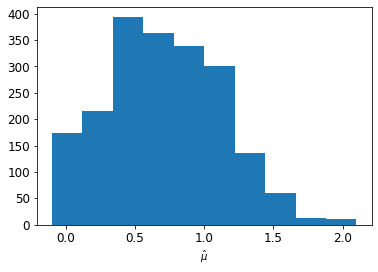

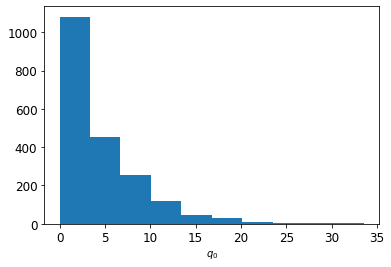

Z BL:(1.9933233584375964, 0.8139367265853483, 1.0233750000000001, 1.9934767597595766, 0.7918900211307548)
Z:1.7392679460370968
Z_std:1.2943193356877225
Z_1:1.5744359530087821
Z_std_1:1.7735386456427946
6
AUC:0.9026555577050305
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

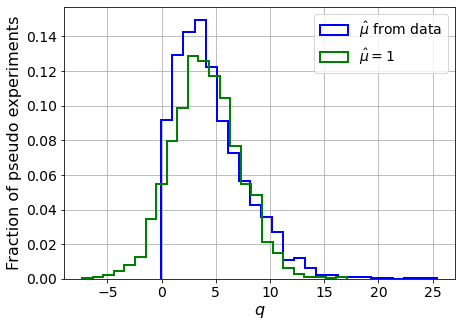

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  6956.97388798
  6641.86552102  6267.14581308  5825.37949638  5304.21634714
  4682.61153122  3933.05165605  3033.75594302  1953.92381662
   648.85637639  -889.77063916 -2724.95414168 -5308.27267801]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4323.73734238  4333.98491653


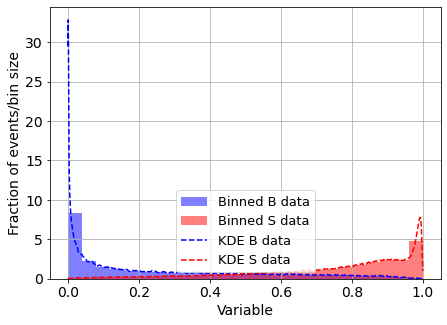

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.009579723006893907
0.009579723006893907
3 done
4 done
0.005472665677825421
0.005472665677825421


  0%|                                                                  | 3/2000 [00:00<03:41,  9.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4995153259261646
<p_{s}(Sdata)> = 2.5841375277841623
<p_{b}(Bdata)> = 6.415510662871084
<p_{s}(Bdata)> = 0.42114801432513277
muhat = -0.1
<p_{b}(Sdata)> = 0.4504335132972249
<p_{s}(Sdata)> = 1.971699997937058
<p_{b}(Bdata)> = 6.345043343511486
<p_{s}(Bdata)> = 0.4164554150212149


  0%|▏                                                                 | 6/2000 [00:00<04:49,  6.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5471448234636294
<p_{s}(Sdata)> = 1.8247806267383526
<p_{b}(Bdata)> = 6.291195662504757
<p_{s}(Bdata)> = 0.4175783030033003


  0%|▎                                                                 | 8/2000 [00:01<06:10,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4945447694408351
<p_{s}(Sdata)> = 1.585636375474452
<p_{b}(Bdata)> = 6.307094999788013
<p_{s}(Bdata)> = 0.4238603945164004


  1%|▌                                                                | 19/2000 [00:04<08:42,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42759954735177086
<p_{s}(Sdata)> = 2.3236910318755983
<p_{b}(Bdata)> = 6.290103488433102
<p_{s}(Bdata)> = 0.42179776692266996


  1%|▊                                                                | 25/2000 [00:05<07:32,  4.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4403400965739455
<p_{s}(Sdata)> = 2.1419501585191063
<p_{b}(Bdata)> = 6.227898917597472
<p_{s}(Bdata)> = 0.4215398793846808


  2%|█▏                                                               | 35/2000 [00:08<07:51,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4103102485744793
<p_{s}(Sdata)> = 2.051917458176609
<p_{b}(Bdata)> = 6.264006610606494
<p_{s}(Bdata)> = 0.41871066334882234


  2%|█▌                                                               | 47/2000 [00:11<08:08,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4490827555031481
<p_{s}(Sdata)> = 1.9664349764099536
<p_{b}(Bdata)> = 6.270289016247673
<p_{s}(Bdata)> = 0.4240866096235521


  3%|█▋                                                               | 51/2000 [00:12<05:50,  5.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45706881622034323
<p_{s}(Sdata)> = 1.9449408043944036
<p_{b}(Bdata)> = 6.302268517257802
<p_{s}(Bdata)> = 0.41643481309631125
muhat = -0.1
<p_{b}(Sdata)> = 0.43553802763795857
<p_{s}(Sdata)> = 1.885663397165358
<p_{b}(Bdata)> = 6.200671634446941
<p_{s}(Bdata)> = 0.41927085579700435


  3%|█▉                                                               | 59/2000 [00:14<08:36,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43443072969522833
<p_{s}(Sdata)> = 2.1285380191066174
<p_{b}(Bdata)> = 6.30946112095686
<p_{s}(Bdata)> = 0.4190782618678447


  4%|██▎                                                              | 70/2000 [00:17<07:37,  4.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6702958972175459
<p_{s}(Sdata)> = 1.8956015609170875
<p_{b}(Bdata)> = 6.26780456213354
<p_{s}(Bdata)> = 0.4260299808210644


  4%|██▍                                                              | 75/2000 [00:18<07:35,  4.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4106812682572969
<p_{s}(Sdata)> = 2.151957824343921
<p_{b}(Bdata)> = 6.335385590960704
<p_{s}(Bdata)> = 0.4178407887948993


  4%|██▊                                                              | 87/2000 [00:21<05:41,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4793794782618289
<p_{s}(Sdata)> = 2.2397979742042478
<p_{b}(Bdata)> = 6.4092886624372944
<p_{s}(Bdata)> = 0.4173675429554281
muhat = -0.1
<p_{b}(Sdata)> = 0.4397093215572802
<p_{s}(Sdata)> = 1.9783447278364736
<p_{b}(Bdata)> = 6.390002034921147
<p_{s}(Bdata)> = 0.4172488090454399


  5%|██▉                                                              | 92/2000 [00:22<05:56,  5.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45341537656571235
<p_{s}(Sdata)> = 2.1660043278128427
<p_{b}(Bdata)> = 6.273036959253496
<p_{s}(Bdata)> = 0.42031338218435493


  5%|███▏                                                             | 99/2000 [00:23<05:19,  5.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4378663346381195
<p_{s}(Sdata)> = 1.9741146238145562
<p_{b}(Bdata)> = 6.201588956794716
<p_{s}(Bdata)> = 0.4214904675898189
muhat = -0.1
<p_{b}(Sdata)> = 0.45143794072461224
<p_{s}(Sdata)> = 1.7978876482892607
<p_{b}(Bdata)> = 6.3059691153263175
<p_{s}(Bdata)> = 0.4205791234551993


  5%|███▏                                                            | 101/2000 [00:24<06:01,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42462456717806285
<p_{s}(Sdata)> = 2.1225137439950705
<p_{b}(Bdata)> = 6.13883853764846
<p_{s}(Bdata)> = 0.42312338168199026


  5%|███▍                                                            | 106/2000 [00:25<04:51,  6.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39603322688829895
<p_{s}(Sdata)> = 2.304572299112701
<p_{b}(Bdata)> = 6.37806021732098
<p_{s}(Bdata)> = 0.42113285183860316


  6%|███▋                                                            | 116/2000 [00:27<06:50,  4.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4646562395371382
<p_{s}(Sdata)> = 2.083144970088956
<p_{b}(Bdata)> = 6.41021010411022
<p_{s}(Bdata)> = 0.41891447814458005


  6%|███▊                                                            | 120/2000 [00:27<05:53,  5.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4220063324753024
<p_{s}(Sdata)> = 1.8921300126388754
<p_{b}(Bdata)> = 6.32905397330871
<p_{s}(Bdata)> = 0.4227131866035256


  7%|████▎                                                           | 134/2000 [00:30<05:00,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3926126019273891
<p_{s}(Sdata)> = 2.1762106306600457
<p_{b}(Bdata)> = 6.243390321239379
<p_{s}(Bdata)> = 0.4170036633299514


  7%|████▋                                                           | 145/2000 [00:33<06:48,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4371301133968486
<p_{s}(Sdata)> = 1.9733578002438954
<p_{b}(Bdata)> = 6.25335495343626
<p_{s}(Bdata)> = 0.420872646203827


  8%|████▊                                                           | 152/2000 [00:35<07:40,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38307492201123494
<p_{s}(Sdata)> = 2.141523009527261
<p_{b}(Bdata)> = 6.239736120715844
<p_{s}(Bdata)> = 0.42209196628312623


  8%|█████                                                           | 157/2000 [00:35<05:30,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46297877046659397
<p_{s}(Sdata)> = 1.9471252707661448
<p_{b}(Bdata)> = 6.2461241658013895
<p_{s}(Bdata)> = 0.41843138043669026


  8%|█████                                                           | 158/2000 [00:36<05:49,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41520128131224876
<p_{s}(Sdata)> = 2.2196210130917646
<p_{b}(Bdata)> = 6.28477026543804
<p_{s}(Bdata)> = 0.41931120688047835


  8%|█████                                                           | 160/2000 [00:36<05:38,  5.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8073774646068177
<p_{s}(Sdata)> = 2.283483613959695
<p_{b}(Bdata)> = 6.356934616494601
<p_{s}(Bdata)> = 0.4175905419399783


 10%|██████▎                                                         | 196/2000 [00:44<08:24,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49751311950483607
<p_{s}(Sdata)> = 1.8252691790341626
<p_{b}(Bdata)> = 6.354853581480971
<p_{s}(Bdata)> = 0.41994210930729087


 10%|██████▌                                                         | 206/2000 [00:46<07:00,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4492414906680217
<p_{s}(Sdata)> = 2.3033668011650663
<p_{b}(Bdata)> = 6.256568835583099
<p_{s}(Bdata)> = 0.4194339643096029


 11%|███████▏                                                        | 225/2000 [00:51<05:38,  5.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42540788512274885
<p_{s}(Sdata)> = 2.303555858488362
<p_{b}(Bdata)> = 6.385539174227137
<p_{s}(Bdata)> = 0.41657636793403136


 11%|███████▎                                                        | 228/2000 [00:51<04:30,  6.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5043241186711227
<p_{s}(Sdata)> = 1.8756972212478558
<p_{b}(Bdata)> = 6.325117913211998
<p_{s}(Bdata)> = 0.4172384515744999


 12%|███████▌                                                        | 237/2000 [00:53<06:34,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3876864738974951
<p_{s}(Sdata)> = 2.442219603986298
<p_{b}(Bdata)> = 6.2786668705025495
<p_{s}(Bdata)> = 0.41651106664369153


 12%|███████▊                                                        | 244/2000 [00:55<06:41,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38869850801799294
<p_{s}(Sdata)> = 2.2186640289241986
<p_{b}(Bdata)> = 6.302841724084295
<p_{s}(Bdata)> = 0.4189098773298623


 13%|████████▍                                                       | 265/2000 [00:59<05:58,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5595332306485208
<p_{s}(Sdata)> = 1.8729335996108454
<p_{b}(Bdata)> = 6.098935137418285
<p_{s}(Bdata)> = 0.4241655627170905


 13%|████████▌                                                       | 269/2000 [01:00<05:52,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5456150685201899
<p_{s}(Sdata)> = 2.038550548175673
<p_{b}(Bdata)> = 6.341958399858539
<p_{s}(Bdata)> = 0.4177409128826026


 14%|████████▋                                                       | 273/2000 [01:01<04:29,  6.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40439696993478463
<p_{s}(Sdata)> = 2.2361272241923165
<p_{b}(Bdata)> = 6.322883145356745
<p_{s}(Bdata)> = 0.41668255411015964


 14%|█████████▏                                                      | 288/2000 [01:04<05:06,  5.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43345449637099465
<p_{s}(Sdata)> = 1.7096202146303263
<p_{b}(Bdata)> = 6.386728333747513
<p_{s}(Bdata)> = 0.41893060497988005
muhat = -0.1
<p_{b}(Sdata)> = 0.4331467787536063
<p_{s}(Sdata)> = 2.077849317996711
<p_{b}(Bdata)> = 6.181854309048073
<p_{s}(Bdata)> = 0.42286459978960694


 15%|█████████▎                                                      | 292/2000 [01:06<07:18,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5046656278251527
<p_{s}(Sdata)> = 1.9556973611919064
<p_{b}(Bdata)> = 6.2789732869594195
<p_{s}(Bdata)> = 0.4182897215839581


 16%|██████████▏                                                     | 317/2000 [01:12<05:42,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4641004230530976
<p_{s}(Sdata)> = 2.3396731460145324
<p_{b}(Bdata)> = 6.3715627595310975
<p_{s}(Bdata)> = 0.41746080483600506


 17%|██████████▌                                                     | 332/2000 [01:16<07:39,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37995115487230485
<p_{s}(Sdata)> = 2.297826033237677
<p_{b}(Bdata)> = 6.254157408707293
<p_{s}(Bdata)> = 0.4199721359925215


 17%|██████████▊                                                     | 339/2000 [01:17<06:58,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42636935869194104
<p_{s}(Sdata)> = 2.0431704707041436
<p_{b}(Bdata)> = 6.277820598826218
<p_{s}(Bdata)> = 0.4211138210453091


 18%|███████████▎                                                    | 355/2000 [01:21<05:31,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49800208985851374
<p_{s}(Sdata)> = 2.0306932624957814
<p_{b}(Bdata)> = 6.250468976854943
<p_{s}(Bdata)> = 0.4227535722935691


 18%|███████████▍                                                    | 358/2000 [01:22<05:20,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4441498439955138
<p_{s}(Sdata)> = 2.1005605279824775
<p_{b}(Bdata)> = 6.417013563324915
<p_{s}(Bdata)> = 0.41617834952824273


 18%|███████████▌                                                    | 362/2000 [01:23<07:24,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5778592189086197
<p_{s}(Sdata)> = 2.3939448156013707
<p_{b}(Bdata)> = 6.31584046164151
<p_{s}(Bdata)> = 0.42231108249673166


 18%|███████████▊                                                    | 368/2000 [01:24<05:43,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48859852330803677
<p_{s}(Sdata)> = 1.955809978348406
<p_{b}(Bdata)> = 6.28492544681961
<p_{s}(Bdata)> = 0.42278204504023487


 19%|███████████▉                                                    | 373/2000 [01:25<05:55,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4475305456643178
<p_{s}(Sdata)> = 2.122034379783099
<p_{b}(Bdata)> = 6.3270974494938175
<p_{s}(Bdata)> = 0.42114969068701347


 19%|████████████▏                                                   | 380/2000 [01:27<05:04,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5958683616787541
<p_{s}(Sdata)> = 2.3035555467348376
<p_{b}(Bdata)> = 6.310762728866642
<p_{s}(Bdata)> = 0.4193333445547119


 19%|████████████▎                                                   | 383/2000 [01:27<05:32,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43654478571766747
<p_{s}(Sdata)> = 2.213553487664157
<p_{b}(Bdata)> = 6.252449531552634
<p_{s}(Bdata)> = 0.41767185715906785


 19%|████████████▍                                                   | 387/2000 [01:28<04:25,  6.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4525784774151246
<p_{s}(Sdata)> = 1.9010023313723186
<p_{b}(Bdata)> = 6.202603748547403
<p_{s}(Bdata)> = 0.42122796209712005


 19%|████████████▍                                                   | 388/2000 [01:28<04:18,  6.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4423253683322989
<p_{s}(Sdata)> = 2.191122052367415
<p_{b}(Bdata)> = 6.237705914395796
<p_{s}(Bdata)> = 0.4259725763747808


 20%|████████████▌                                                   | 392/2000 [01:28<03:23,  7.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43487682897684954
<p_{s}(Sdata)> = 2.0420387447210073
<p_{b}(Bdata)> = 6.290355894090834
<p_{s}(Bdata)> = 0.42288521449642336
muhat = -0.1
<p_{b}(Sdata)> = 0.3994250833059065
<p_{s}(Sdata)> = 2.344037381121335
<p_{b}(Bdata)> = 6.303616965471744
<p_{s}(Bdata)> = 0.41127481009244826


 20%|████████████▋                                                   | 395/2000 [01:29<04:32,  5.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41706848545965397
<p_{s}(Sdata)> = 2.2443108659313817
<p_{b}(Bdata)> = 6.282621496065364
<p_{s}(Bdata)> = 0.42137086399439727


 20%|████████████▋                                                   | 398/2000 [01:30<04:57,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43374021702172916
<p_{s}(Sdata)> = 2.0952783687309213
<p_{b}(Bdata)> = 6.250780312723302
<p_{s}(Bdata)> = 0.42243219075919825


 21%|█████████████▌                                                  | 425/2000 [01:37<07:27,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46710901948053035
<p_{s}(Sdata)> = 1.9668408132633521
<p_{b}(Bdata)> = 6.291529074067202
<p_{s}(Bdata)> = 0.4178366033832322


 22%|██████████████▏                                                 | 442/2000 [01:40<04:36,  5.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46507392124666663
<p_{s}(Sdata)> = 1.6483075238128493
<p_{b}(Bdata)> = 6.284878289849064
<p_{s}(Bdata)> = 0.42224857750274697


 23%|██████████████▌                                                 | 457/2000 [01:44<04:46,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44058108861422257
<p_{s}(Sdata)> = 1.9783591375037013
<p_{b}(Bdata)> = 6.256330397142306
<p_{s}(Bdata)> = 0.4191180455806501


 23%|██████████████▉                                                 | 465/2000 [01:45<05:35,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40847335748708535
<p_{s}(Sdata)> = 2.3605587639228136
<p_{b}(Bdata)> = 6.30345154431106
<p_{s}(Bdata)> = 0.42030913784289403


 24%|███████████████                                                 | 472/2000 [01:47<06:17,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4288782078642448
<p_{s}(Sdata)> = 2.0232557587107043
<p_{b}(Bdata)> = 6.254625227138601
<p_{s}(Bdata)> = 0.420981905743605


 24%|███████████████▎                                                | 477/2000 [01:48<04:38,  5.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5006322070120743
<p_{s}(Sdata)> = 1.9284118973207889
<p_{b}(Bdata)> = 6.354227009279987
<p_{s}(Bdata)> = 0.4229464615769319


 24%|███████████████▍                                                | 484/2000 [01:50<06:37,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38073327814233865
<p_{s}(Sdata)> = 2.4137037034391837
<p_{b}(Bdata)> = 6.247690706830355
<p_{s}(Bdata)> = 0.4201711095271202


 25%|███████████████▊                                                | 495/2000 [01:52<04:21,  5.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4611289238922034
<p_{s}(Sdata)> = 1.7873411310607092
<p_{b}(Bdata)> = 6.340024556699667
<p_{s}(Bdata)> = 0.41519646548283357
muhat = -0.1
<p_{b}(Sdata)> = 0.40987845380755966
<p_{s}(Sdata)> = 1.9023772118138003
<p_{b}(Bdata)> = 6.361566622154693
<p_{s}(Bdata)> = 0.42213805670032933


 25%|████████████████                                                | 502/2000 [01:53<04:03,  6.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45620153748697106
<p_{s}(Sdata)> = 1.933605307914532
<p_{b}(Bdata)> = 6.3557585298737465
<p_{s}(Bdata)> = 0.4206997417189651


 25%|████████████████                                                | 503/2000 [01:54<05:48,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43370694072928806
<p_{s}(Sdata)> = 1.9592311440295318
<p_{b}(Bdata)> = 6.203353821779347
<p_{s}(Bdata)> = 0.42143081367777285


 26%|████████████████▍                                               | 512/2000 [01:56<04:43,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4314006176881929
<p_{s}(Sdata)> = 1.8993271247237087
<p_{b}(Bdata)> = 6.414491776500075
<p_{s}(Bdata)> = 0.4129053052433655


 26%|████████████████▌                                               | 516/2000 [01:57<05:43,  4.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4431672426506623
<p_{s}(Sdata)> = 1.9549716783124305
<p_{b}(Bdata)> = 6.304049529618351
<p_{s}(Bdata)> = 0.41496200709759923


 27%|█████████████████                                               | 534/2000 [02:01<04:23,  5.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.461684970602599
<p_{s}(Sdata)> = 2.304842118709462
<p_{b}(Bdata)> = 6.369506707958742
<p_{s}(Bdata)> = 0.4219656409488106
muhat = -0.1
<p_{b}(Sdata)> = 0.42666311283625086
<p_{s}(Sdata)> = 2.0470191753438587
<p_{b}(Bdata)> = 6.3075945926017996
<p_{s}(Bdata)> = 0.4138679906652209


 27%|█████████████████▏                                              | 536/2000 [02:02<05:15,  4.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6500441011488935
<p_{s}(Sdata)> = 2.0960063773841706
<p_{b}(Bdata)> = 6.2890466716315165
<p_{s}(Bdata)> = 0.4236526683122329


 27%|█████████████████▎                                              | 541/2000 [02:03<06:06,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48476532071829015
<p_{s}(Sdata)> = 1.9141499442366956
<p_{b}(Bdata)> = 6.223689437153729
<p_{s}(Bdata)> = 0.42044984915863265


 27%|█████████████████▌                                              | 547/2000 [02:04<04:40,  5.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5158262104144965
<p_{s}(Sdata)> = 1.8849231335913623
<p_{b}(Bdata)> = 6.300863835717845
<p_{s}(Bdata)> = 0.4197555591375277
muhat = -0.1
<p_{b}(Sdata)> = 0.3839364309198407
<p_{s}(Sdata)> = 2.2111588208000628
<p_{b}(Bdata)> = 6.315682005114074
<p_{s}(Bdata)> = 0.4139935500073987


 27%|█████████████████▌                                              | 549/2000 [02:05<05:20,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4621538338834057
<p_{s}(Sdata)> = 1.9920527983992116
<p_{b}(Bdata)> = 6.222887095069415
<p_{s}(Bdata)> = 0.4208586066390381


 28%|█████████████████▋                                              | 552/2000 [02:05<04:32,  5.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37574004733170563
<p_{s}(Sdata)> = 2.2797527289368396
<p_{b}(Bdata)> = 6.233902033233226
<p_{s}(Bdata)> = 0.4169732060427018


 28%|█████████████████▊                                              | 556/2000 [02:06<03:56,  6.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42688667634731653
<p_{s}(Sdata)> = 2.0094999567752976
<p_{b}(Bdata)> = 6.353514143728043
<p_{s}(Bdata)> = 0.4171682760841882


 28%|█████████████████▉                                              | 559/2000 [02:06<04:56,  4.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6743055573929353
<p_{s}(Sdata)> = 1.8100792290430736
<p_{b}(Bdata)> = 6.237585515620166
<p_{s}(Bdata)> = 0.4222722134952284


 28%|█████████████████▉                                              | 562/2000 [02:07<04:55,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4261206903679286
<p_{s}(Sdata)> = 2.000516503087004
<p_{b}(Bdata)> = 6.226646351693652
<p_{s}(Bdata)> = 0.4138089340129496


 28%|██████████████████                                              | 565/2000 [02:08<05:22,  4.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44457661142423427
<p_{s}(Sdata)> = 2.122812037262444
<p_{b}(Bdata)> = 6.4265963962494075
<p_{s}(Bdata)> = 0.4211478665610025


 29%|██████████████████▎                                             | 572/2000 [02:09<05:42,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5615788389619365
<p_{s}(Sdata)> = 1.8442591119340719
<p_{b}(Bdata)> = 6.3101601254517075
<p_{s}(Bdata)> = 0.4167979011031473


 29%|██████████████████▍                                             | 577/2000 [02:10<05:19,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4111241753487877
<p_{s}(Sdata)> = 2.3843604689404194
<p_{b}(Bdata)> = 6.41231996327271
<p_{s}(Bdata)> = 0.41690950631865775


 29%|██████████████████▌                                             | 581/2000 [02:11<03:57,  5.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4276047206369372
<p_{s}(Sdata)> = 2.19636290483396
<p_{b}(Bdata)> = 6.281524674992611
<p_{s}(Bdata)> = 0.41557323968878646


 29%|██████████████████▋                                             | 584/2000 [02:12<06:09,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37980426330003114
<p_{s}(Sdata)> = 2.3272099194187925
<p_{b}(Bdata)> = 6.2044378296005
<p_{s}(Bdata)> = 0.4210253425884085


 29%|██████████████████▊                                             | 588/2000 [02:13<06:06,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42601048090988525
<p_{s}(Sdata)> = 1.9710782287539006
<p_{b}(Bdata)> = 6.252753758055549
<p_{s}(Bdata)> = 0.4233720137719138


 30%|██████████████████▉                                             | 592/2000 [02:13<03:56,  5.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47492705462010637
<p_{s}(Sdata)> = 1.6535987028659573
<p_{b}(Bdata)> = 6.327543339183809
<p_{s}(Bdata)> = 0.41816680316901766
muhat = -0.1
<p_{b}(Sdata)> = 0.4295257534524351
<p_{s}(Sdata)> = 1.9177891986791458
<p_{b}(Bdata)> = 6.270297490103867
<p_{s}(Bdata)> = 0.41668029141977153


 30%|██████████████████▉                                             | 593/2000 [02:14<04:01,  5.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41536681213198345
<p_{s}(Sdata)> = 2.008787187952231
<p_{b}(Bdata)> = 6.244474718718154
<p_{s}(Bdata)> = 0.4196618615372034


 30%|███████████████████                                             | 597/2000 [02:14<03:34,  6.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48717758432403796
<p_{s}(Sdata)> = 1.9361390628800899
<p_{b}(Bdata)> = 6.328588916729868
<p_{s}(Bdata)> = 0.4189082156728396


 30%|███████████████████▏                                            | 599/2000 [02:14<03:20,  6.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41406446245884504
<p_{s}(Sdata)> = 2.0126858482563423
<p_{b}(Bdata)> = 6.183313159845129
<p_{s}(Bdata)> = 0.42118342435805384


 30%|███████████████████▏                                            | 600/2000 [02:15<03:36,  6.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37354591469604254
<p_{s}(Sdata)> = 2.5477803793298714
<p_{b}(Bdata)> = 6.274490673610358
<p_{s}(Bdata)> = 0.4190308318086947


 30%|███████████████████▎                                            | 603/2000 [02:15<03:55,  5.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3990523062809755
<p_{s}(Sdata)> = 2.2124114160477255
<p_{b}(Bdata)> = 6.281481224669946
<p_{s}(Bdata)> = 0.41830706633973475


 30%|███████████████████▎                                            | 605/2000 [02:16<04:25,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5173288110702398
<p_{s}(Sdata)> = 2.043501317633008
<p_{b}(Bdata)> = 6.27399974766663
<p_{s}(Bdata)> = 0.41887855513215555


 31%|███████████████████▌                                            | 613/2000 [02:17<04:01,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3664470072374073
<p_{s}(Sdata)> = 2.1743067609025832
<p_{b}(Bdata)> = 6.2415567215138115
<p_{s}(Bdata)> = 0.4237243345073508


 32%|████████████████████▏                                           | 631/2000 [02:22<05:10,  4.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3675271464480176
<p_{s}(Sdata)> = 2.2717061411379467
<p_{b}(Bdata)> = 6.3170544943503595
<p_{s}(Bdata)> = 0.42424730669048955


 32%|████████████████████▋                                           | 648/2000 [02:26<04:45,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46131204161338996
<p_{s}(Sdata)> = 1.8986098156616282
<p_{b}(Bdata)> = 6.323712080565127
<p_{s}(Bdata)> = 0.4210129097847115


 33%|████████████████████▉                                           | 653/2000 [02:27<06:02,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4960563847775317
<p_{s}(Sdata)> = 1.8901341110351886
<p_{b}(Bdata)> = 6.323699359966443
<p_{s}(Bdata)> = 0.4180655927050976


 33%|█████████████████████▏                                          | 664/2000 [02:29<03:37,  6.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41782936160684275
<p_{s}(Sdata)> = 2.118645928798454
<p_{b}(Bdata)> = 6.2519896971689235
<p_{s}(Bdata)> = 0.42298353626033963
muhat = -0.1
<p_{b}(Sdata)> = 0.42732738972736173
<p_{s}(Sdata)> = 1.9448467956274067
<p_{b}(Bdata)> = 6.238130831201511
<p_{s}(Bdata)> = 0.4175702496234449


 33%|█████████████████████▍                                          | 669/2000 [02:30<05:17,  4.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4864419285080655
<p_{s}(Sdata)> = 2.0291264322517604
<p_{b}(Bdata)> = 6.368082382468476
<p_{s}(Bdata)> = 0.4227099590728339


 34%|█████████████████████▊                                          | 682/2000 [02:34<06:04,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5099737613031982
<p_{s}(Sdata)> = 1.7708436876381557
<p_{b}(Bdata)> = 6.313789322247631
<p_{s}(Bdata)> = 0.42514057392506244


 35%|██████████████████████▎                                         | 699/2000 [02:38<04:47,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38139361220000906
<p_{s}(Sdata)> = 2.2350294227839265
<p_{b}(Bdata)> = 6.343964988240512
<p_{s}(Bdata)> = 0.41762274193037835


 35%|██████████████████████▌                                         | 704/2000 [02:39<03:20,  6.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46574023056291264
<p_{s}(Sdata)> = 1.9607402456905316
<p_{b}(Bdata)> = 6.322471980205819
<p_{s}(Bdata)> = 0.41918606981924605
muhat = -0.1
<p_{b}(Sdata)> = 0.4351345647998049
<p_{s}(Sdata)> = 2.0052316441600513
<p_{b}(Bdata)> = 6.3141980658497
<p_{s}(Bdata)> = 0.4139135451474529


 36%|██████████████████████▉                                         | 717/2000 [02:42<06:33,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46664327729027416
<p_{s}(Sdata)> = 1.903364243386577
<p_{b}(Bdata)> = 6.294637068897407
<p_{s}(Bdata)> = 0.422056692715473


 36%|███████████████████████                                         | 722/2000 [02:43<03:55,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43693172660598684
<p_{s}(Sdata)> = 2.231961007435341
<p_{b}(Bdata)> = 6.1517507030871466
<p_{s}(Bdata)> = 0.4220314802936986


 36%|███████████████████████▎                                        | 728/2000 [02:45<05:39,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4392723666044029
<p_{s}(Sdata)> = 1.9598553698630898
<p_{b}(Bdata)> = 6.364432472829249
<p_{s}(Bdata)> = 0.4199657445364302


 37%|███████████████████████▍                                        | 733/2000 [02:45<04:06,  5.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39011416262829507
<p_{s}(Sdata)> = 2.118676428658483
<p_{b}(Bdata)> = 6.226677164202156
<p_{s}(Bdata)> = 0.4215791324138547


 37%|███████████████████████▌                                        | 738/2000 [02:46<04:16,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4228360205598637
<p_{s}(Sdata)> = 2.2389595625485703
<p_{b}(Bdata)> = 6.315420446080215
<p_{s}(Bdata)> = 0.4197608406778921


 37%|███████████████████████▊                                        | 743/2000 [02:48<04:51,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4725148012478965
<p_{s}(Sdata)> = 2.1071470776715064
<p_{b}(Bdata)> = 6.380513806334168
<p_{s}(Bdata)> = 0.42037798142017535


 39%|████████████████████████▋                                       | 772/2000 [02:55<05:43,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49078465280377825
<p_{s}(Sdata)> = 1.9056074053376726
<p_{b}(Bdata)> = 6.287844148457613
<p_{s}(Bdata)> = 0.41851497187222525


 39%|█████████████████████████▏                                      | 786/2000 [02:59<06:13,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42977747333338484
<p_{s}(Sdata)> = 2.1340971513352565
<p_{b}(Bdata)> = 6.344519133543135
<p_{s}(Bdata)> = 0.41743559165179006


 40%|█████████████████████████▍                                      | 793/2000 [03:00<04:51,  4.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48108591786521954
<p_{s}(Sdata)> = 1.956265549293603
<p_{b}(Bdata)> = 6.229774108287792
<p_{s}(Bdata)> = 0.41968091922182466


 41%|██████████████████████████▏                                     | 819/2000 [03:07<05:16,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4566218638043552
<p_{s}(Sdata)> = 1.8132887835346245
<p_{b}(Bdata)> = 6.216542003592877
<p_{s}(Bdata)> = 0.4253687134315083


 42%|███████████████████████████                                     | 844/2000 [03:13<04:41,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4527426002223852
<p_{s}(Sdata)> = 2.005054625105828
<p_{b}(Bdata)> = 6.385158937764505
<p_{s}(Bdata)> = 0.42103593414466417


 42%|███████████████████████████                                     | 846/2000 [03:13<04:16,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.462817111681093
<p_{s}(Sdata)> = 2.1978513099067354
<p_{b}(Bdata)> = 6.19134640941579
<p_{s}(Bdata)> = 0.4197835502882784


 43%|███████████████████████████▏                                    | 851/2000 [03:14<03:27,  5.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40610145962867034
<p_{s}(Sdata)> = 2.390185447117328
<p_{b}(Bdata)> = 6.268199562878103
<p_{s}(Bdata)> = 0.4194834799011191
muhat = -0.1
<p_{b}(Sdata)> = 0.4283753006847214
<p_{s}(Sdata)> = 1.8194120931884934
<p_{b}(Bdata)> = 6.2559946597498755
<p_{s}(Bdata)> = 0.4209398929463004


 43%|███████████████████████████▎                                    | 855/2000 [03:15<04:08,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5978985499013483
<p_{s}(Sdata)> = 1.818603757028931
<p_{b}(Bdata)> = 6.276922940671112
<p_{s}(Bdata)> = 0.4216036139035394


 43%|███████████████████████████▌                                    | 861/2000 [03:16<03:42,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4292279004606688
<p_{s}(Sdata)> = 2.0643443951737477
<p_{b}(Bdata)> = 6.341928001983418
<p_{s}(Bdata)> = 0.4193282533789378


 44%|███████████████████████████▊                                    | 871/2000 [03:19<05:04,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4406535158754038
<p_{s}(Sdata)> = 1.8982677866001514
<p_{b}(Bdata)> = 6.176988612674295
<p_{s}(Bdata)> = 0.42353342865748894


 44%|████████████████████████████                                    | 877/2000 [03:20<04:22,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42916140168474276
<p_{s}(Sdata)> = 1.9447799011454634
<p_{b}(Bdata)> = 6.271544152320776
<p_{s}(Bdata)> = 0.4225799184135244


 44%|████████████████████████████▏                                   | 881/2000 [03:21<03:29,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40386589059893324
<p_{s}(Sdata)> = 2.1953513001297145
<p_{b}(Bdata)> = 6.249788999377011
<p_{s}(Bdata)> = 0.4236392756209343


 44%|████████████████████████████▎                                   | 885/2000 [03:21<02:50,  6.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48644027512482024
<p_{s}(Sdata)> = 1.935881928424933
<p_{b}(Bdata)> = 6.267782316846711
<p_{s}(Bdata)> = 0.41631926279813575
muhat = -0.1
<p_{b}(Sdata)> = 0.3682490134393719
<p_{s}(Sdata)> = 2.4881155626802314
<p_{b}(Bdata)> = 6.387133832919206
<p_{s}(Bdata)> = 0.41899802747360837


 45%|████████████████████████████▋                                   | 896/2000 [03:24<04:36,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46669629799004025
<p_{s}(Sdata)> = 1.987721166024317
<p_{b}(Bdata)> = 6.295318234368588
<p_{s}(Bdata)> = 0.42275051359058574


 45%|████████████████████████████▊                                   | 899/2000 [03:25<03:52,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.436468947081723
<p_{s}(Sdata)> = 2.111220807202769
<p_{b}(Bdata)> = 6.326568596581173
<p_{s}(Bdata)> = 0.41729758416723245


 46%|█████████████████████████████▏                                  | 911/2000 [03:27<02:54,  6.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.389324368547578
<p_{s}(Sdata)> = 2.1907503235696106
<p_{b}(Bdata)> = 6.23438642263512
<p_{s}(Bdata)> = 0.4214635732383568
muhat = -0.1
<p_{b}(Sdata)> = 0.45602151383093903
<p_{s}(Sdata)> = 2.192637681846911
<p_{b}(Bdata)> = 6.319029898837963
<p_{s}(Bdata)> = 0.4127740775402687


 46%|█████████████████████████████▏                                  | 914/2000 [03:28<03:28,  5.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4759776477934553
<p_{s}(Sdata)> = 2.0857198776673984
<p_{b}(Bdata)> = 6.379351364552929
<p_{s}(Bdata)> = 0.41704036636596786


 46%|█████████████████████████████▌                                  | 925/2000 [03:30<03:35,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48278269896633047
<p_{s}(Sdata)> = 1.9083914773818098
<p_{b}(Bdata)> = 6.279984863905946
<p_{s}(Bdata)> = 0.42252018859748236


 47%|█████████████████████████████▊                                  | 932/2000 [03:32<04:21,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3781614064076286
<p_{s}(Sdata)> = 2.2781851650621996
<p_{b}(Bdata)> = 6.247516505580394
<p_{s}(Bdata)> = 0.41933498141564096


 47%|█████████████████████████████▉                                  | 935/2000 [03:32<03:27,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3995597668757255
<p_{s}(Sdata)> = 2.406201815986598
<p_{b}(Bdata)> = 6.360149335313345
<p_{s}(Bdata)> = 0.41742071137651643


 47%|██████████████████████████████                                  | 939/2000 [03:33<02:50,  6.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4849833378137923
<p_{s}(Sdata)> = 2.1032300304618436
<p_{b}(Bdata)> = 6.295123040616969
<p_{s}(Bdata)> = 0.4155712415636672


 47%|██████████████████████████████▏                                 | 944/2000 [03:34<03:45,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41184784632751603
<p_{s}(Sdata)> = 1.981449698517935
<p_{b}(Bdata)> = 6.316683692036896
<p_{s}(Bdata)> = 0.4152062432917566


 47%|██████████████████████████████▎                                 | 946/2000 [03:34<03:19,  5.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41466252558542727
<p_{s}(Sdata)> = 2.0814893597552615
<p_{b}(Bdata)> = 6.274443285836958
<p_{s}(Bdata)> = 0.4221016289812253


 48%|██████████████████████████████▍                                 | 952/2000 [03:36<03:14,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4828126031838705
<p_{s}(Sdata)> = 1.9001526030200289
<p_{b}(Bdata)> = 6.2543068307594725
<p_{s}(Bdata)> = 0.41747153770518275
muhat = -0.1
<p_{b}(Sdata)> = 0.5208431859853236
<p_{s}(Sdata)> = 1.8879602093646688
<p_{b}(Bdata)> = 6.249205002663954
<p_{s}(Bdata)> = 0.418126957120576


 48%|██████████████████████████████▊                                 | 961/2000 [03:38<04:14,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5391382853755555
<p_{s}(Sdata)> = 1.9684227530457472
<p_{b}(Bdata)> = 6.274032751497158
<p_{s}(Bdata)> = 0.42051175313158473


 48%|██████████████████████████████▉                                 | 965/2000 [03:39<04:17,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38952667006998637
<p_{s}(Sdata)> = 2.087095193426036
<p_{b}(Bdata)> = 6.281158936944808
<p_{s}(Bdata)> = 0.42063622543882645


 48%|██████████████████████████████▉                                 | 967/2000 [03:39<03:57,  4.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5007536903955286
<p_{s}(Sdata)> = 1.780507727752952
<p_{b}(Bdata)> = 6.3641291377399725
<p_{s}(Bdata)> = 0.41317500227157145


 49%|███████████████████████████████▌                                | 987/2000 [03:44<04:30,  3.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4418253118909482
<p_{s}(Sdata)> = 1.9396664449469914
<p_{b}(Bdata)> = 6.301750576229031
<p_{s}(Bdata)> = 0.4179726182833072


 50%|███████████████████████████████▋                                | 992/2000 [03:45<03:01,  5.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41777558833890577
<p_{s}(Sdata)> = 2.0742980491533234
<p_{b}(Bdata)> = 6.281834834107833
<p_{s}(Bdata)> = 0.4231488236759818


 50%|███████████████████████████████▉                                | 998/2000 [03:46<04:12,  3.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40600432889257904
<p_{s}(Sdata)> = 2.2801815556020903
<p_{b}(Bdata)> = 6.223869014507853
<p_{s}(Bdata)> = 0.4201875094666236


 50%|███████████████████████████████▌                               | 1001/2000 [03:47<03:28,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4734427636117514
<p_{s}(Sdata)> = 1.8621115201606468
<p_{b}(Bdata)> = 6.259287360802242
<p_{s}(Bdata)> = 0.4197650726814451


 50%|███████████████████████████████▌                               | 1003/2000 [03:47<03:18,  5.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42000564253883527
<p_{s}(Sdata)> = 2.0107651799061275
<p_{b}(Bdata)> = 6.285527610483217
<p_{s}(Bdata)> = 0.4232339375931904


 50%|███████████████████████████████▋                               | 1007/2000 [03:48<02:47,  5.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3588294422090444
<p_{s}(Sdata)> = 2.4311853562558214
<p_{b}(Bdata)> = 6.349084970957014
<p_{s}(Bdata)> = 0.4198991320107216


 50%|███████████████████████████████▊                               | 1009/2000 [03:48<02:52,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5091123999198357
<p_{s}(Sdata)> = 2.221821823920386
<p_{b}(Bdata)> = 6.2599269572623095
<p_{s}(Bdata)> = 0.4243440836786105


 51%|███████████████████████████████▉                               | 1015/2000 [03:49<02:43,  6.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41957456771985013
<p_{s}(Sdata)> = 2.1061064636211797
<p_{b}(Bdata)> = 6.359198039609277
<p_{s}(Bdata)> = 0.41971907004332704
muhat = -0.1
<p_{b}(Sdata)> = 0.3593006716940601
<p_{s}(Sdata)> = 2.399669225216462
<p_{b}(Bdata)> = 6.272388584770022
<p_{s}(Bdata)> = 0.42415335738156174


 51%|████████████████████████████████                               | 1018/2000 [03:50<02:27,  6.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4507347082404732
<p_{s}(Sdata)> = 2.2954707574620663
<p_{b}(Bdata)> = 6.396508813141601
<p_{s}(Bdata)> = 0.416178442442645


 52%|████████████████████████████████▋                              | 1037/2000 [03:54<02:55,  5.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45246972246501427
<p_{s}(Sdata)> = 2.2766199711067308
<p_{b}(Bdata)> = 6.216619310423361
<p_{s}(Bdata)> = 0.42183501076781094
muhat = -0.1
<p_{b}(Sdata)> = 0.3695370811943899
<p_{s}(Sdata)> = 2.3394104584286795
<p_{b}(Bdata)> = 6.287060215593521
<p_{s}(Bdata)> = 0.4229394355556912


 52%|████████████████████████████████▋                              | 1038/2000 [03:55<03:14,  4.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4448626934947717
<p_{s}(Sdata)> = 2.206202190723796
<p_{b}(Bdata)> = 6.28878696092451
<p_{s}(Bdata)> = 0.41637434006558194


 52%|█████████████████████████████████                              | 1048/2000 [03:57<03:55,  4.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5044623268273838
<p_{s}(Sdata)> = 1.901432968890782
<p_{b}(Bdata)> = 6.357437011287074
<p_{s}(Bdata)> = 0.41936858010423134


 53%|█████████████████████████████████▏                             | 1052/2000 [03:58<03:57,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4591438599916577
<p_{s}(Sdata)> = 1.8929805116646954
<p_{b}(Bdata)> = 6.159869697222254
<p_{s}(Bdata)> = 0.4296160231836706


 53%|█████████████████████████████████▎                             | 1056/2000 [03:59<04:34,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5227155474531519
<p_{s}(Sdata)> = 2.244392984662178
<p_{b}(Bdata)> = 6.4478434515422185
<p_{s}(Bdata)> = 0.4165800043682105


 53%|█████████████████████████████████▍                             | 1063/2000 [04:00<02:39,  5.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41748089097421825
<p_{s}(Sdata)> = 2.215079538549987
<p_{b}(Bdata)> = 6.292321487066092
<p_{s}(Bdata)> = 0.419806375146147


 53%|█████████████████████████████████▌                             | 1064/2000 [04:01<02:45,  5.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42431375742713845
<p_{s}(Sdata)> = 2.1152827874454427
<p_{b}(Bdata)> = 6.316404233820629
<p_{s}(Bdata)> = 0.42007532336849523


 54%|██████████████████████████████████                             | 1080/2000 [04:04<02:17,  6.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5212820125365514
<p_{s}(Sdata)> = 1.9069276312541548
<p_{b}(Bdata)> = 6.370979602711953
<p_{s}(Bdata)> = 0.42176644052570217
muhat = -0.1
<p_{b}(Sdata)> = 0.5143762205904887
<p_{s}(Sdata)> = 1.9379023665023665
<p_{b}(Bdata)> = 6.180002290525414
<p_{s}(Bdata)> = 0.42316811023853435


 54%|██████████████████████████████████▏                            | 1087/2000 [04:05<02:25,  6.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3822719399735283
<p_{s}(Sdata)> = 2.1827725468002472
<p_{b}(Bdata)> = 6.412036986682211
<p_{s}(Bdata)> = 0.42036478271248573


 55%|██████████████████████████████████▌                            | 1098/2000 [04:08<03:32,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5113898254698258
<p_{s}(Sdata)> = 1.9785755437872237
<p_{b}(Bdata)> = 6.336941513890844
<p_{s}(Bdata)> = 0.42145648979390565


 55%|██████████████████████████████████▊                            | 1105/2000 [04:10<03:23,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3948342652978284
<p_{s}(Sdata)> = 2.0313841562676114
<p_{b}(Bdata)> = 6.130010834767489
<p_{s}(Bdata)> = 0.42070330192829275


 56%|██████████████████████████████████▉                            | 1111/2000 [04:11<03:11,  4.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42028873706396835
<p_{s}(Sdata)> = 1.9956626381812306
<p_{b}(Bdata)> = 6.311266831486126
<p_{s}(Bdata)> = 0.4252097534359572


 56%|███████████████████████████████████▏                           | 1117/2000 [04:12<03:16,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43590807705353013
<p_{s}(Sdata)> = 2.0575003697335363
<p_{b}(Bdata)> = 6.365426141810112
<p_{s}(Bdata)> = 0.4198810860752137


 56%|███████████████████████████████████▌                           | 1127/2000 [04:15<03:26,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45409306415379896
<p_{s}(Sdata)> = 2.3241943951112534
<p_{b}(Bdata)> = 6.231619730747546
<p_{s}(Bdata)> = 0.4117902098116441


 57%|████████████████████████████████████                           | 1143/2000 [04:18<03:25,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3858034031133251
<p_{s}(Sdata)> = 2.2305640573786785
<p_{b}(Bdata)> = 6.297974926739546
<p_{s}(Bdata)> = 0.42205846342997294


 58%|████████████████████████████████████▊                          | 1168/2000 [04:26<03:17,  4.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4655832836965675
<p_{s}(Sdata)> = 2.233034620337973
<p_{b}(Bdata)> = 6.2400986230897155
<p_{s}(Bdata)> = 0.42069437801487103


 59%|█████████████████████████████████████                          | 1178/2000 [04:28<02:55,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36581887321686674
<p_{s}(Sdata)> = 2.4885247105342634
<p_{b}(Bdata)> = 6.287837255151907
<p_{s}(Bdata)> = 0.41794802716415236


 59%|█████████████████████████████████████▏                         | 1179/2000 [04:29<03:11,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42665971086135973
<p_{s}(Sdata)> = 2.0899146394708095
<p_{b}(Bdata)> = 6.321208378998798
<p_{s}(Bdata)> = 0.4255960605054963


 59%|█████████████████████████████████████▍                         | 1187/2000 [04:30<02:21,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44631545948274737
<p_{s}(Sdata)> = 1.9103460367374316
<p_{b}(Bdata)> = 6.342955582741288
<p_{s}(Bdata)> = 0.4199792363134854


 60%|█████████████████████████████████████▍                         | 1190/2000 [04:31<02:46,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4235619678779486
<p_{s}(Sdata)> = 2.045047448027921
<p_{b}(Bdata)> = 6.329763477779474
<p_{s}(Bdata)> = 0.4162401346680979


 60%|█████████████████████████████████████▊                         | 1202/2000 [04:33<02:44,  4.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4368955512522241
<p_{s}(Sdata)> = 2.170910145676525
<p_{b}(Bdata)> = 6.196706416494755
<p_{s}(Bdata)> = 0.41748867364236364


 61%|██████████████████████████████████████▎                        | 1215/2000 [04:37<03:22,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4417820502400123
<p_{s}(Sdata)> = 2.004662363664276
<p_{b}(Bdata)> = 6.219792911948691
<p_{s}(Bdata)> = 0.42087642057067026


 62%|██████████████████████████████████████▉                        | 1236/2000 [04:42<03:16,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40506834847168216
<p_{s}(Sdata)> = 2.0409502894018288
<p_{b}(Bdata)> = 6.3527197939397295
<p_{s}(Bdata)> = 0.41973808251001465


 62%|██████████████████████████████████████▉                        | 1238/2000 [04:42<02:43,  4.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42631006329687354
<p_{s}(Sdata)> = 2.0596350152416725
<p_{b}(Bdata)> = 6.240672929830876
<p_{s}(Bdata)> = 0.4245583953552035


 62%|███████████████████████████████████████                        | 1240/2000 [04:43<02:54,  4.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4471059051767231
<p_{s}(Sdata)> = 1.9659096849675604
<p_{b}(Bdata)> = 6.385349021942568
<p_{s}(Bdata)> = 0.4207962269582449


 63%|███████████████████████████████████████▍                       | 1253/2000 [04:46<02:29,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4559316059326959
<p_{s}(Sdata)> = 1.9761914628500392
<p_{b}(Bdata)> = 6.3665229494558835
<p_{s}(Bdata)> = 0.4157078791914462


 63%|███████████████████████████████████████▌                       | 1256/2000 [04:46<02:29,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42089982597018444
<p_{s}(Sdata)> = 2.1246049562841347
<p_{b}(Bdata)> = 6.230737057683901
<p_{s}(Bdata)> = 0.42185077887753475


 63%|███████████████████████████████████████▊                       | 1262/2000 [04:48<02:57,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5336463811300634
<p_{s}(Sdata)> = 1.8788467484276286
<p_{b}(Bdata)> = 6.370998409551339
<p_{s}(Bdata)> = 0.4160892772968647


 63%|███████████████████████████████████████▉                       | 1267/2000 [04:49<03:18,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4524089110304707
<p_{s}(Sdata)> = 1.9724255072223134
<p_{b}(Bdata)> = 6.305520038216339
<p_{s}(Bdata)> = 0.4176425051717094


 64%|████████████████████████████████████████▏                      | 1276/2000 [04:51<02:08,  5.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43869778136789644
<p_{s}(Sdata)> = 1.9829654602512987
<p_{b}(Bdata)> = 6.302997145268385
<p_{s}(Bdata)> = 0.4194952122038729


 64%|████████████████████████████████████████▍                      | 1284/2000 [04:52<02:12,  5.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4212455332507534
<p_{s}(Sdata)> = 2.14832409414828
<p_{b}(Bdata)> = 6.291120493144123
<p_{s}(Bdata)> = 0.41337826458391164


 64%|████████████████████████████████████████▌                      | 1288/2000 [04:53<01:32,  7.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6132266822284522
<p_{s}(Sdata)> = 1.982197147485242
<p_{b}(Bdata)> = 6.219328163810765
<p_{s}(Bdata)> = 0.42421594969671744
muhat = -0.1
<p_{b}(Sdata)> = 0.9123459184722664
<p_{s}(Sdata)> = 2.0643510661654334
<p_{b}(Bdata)> = 6.3675727334554235
<p_{s}(Bdata)> = 0.41969647811239774


 66%|█████████████████████████████████████████▊                     | 1327/2000 [05:03<03:43,  3.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45569455160323485
<p_{s}(Sdata)> = 1.8390693063604544
<p_{b}(Bdata)> = 6.3149638217982025
<p_{s}(Bdata)> = 0.4153749095536344


 67%|█████████████████████████████████████████▉                     | 1331/2000 [05:04<02:54,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44147324649841885
<p_{s}(Sdata)> = 1.8804210135932742
<p_{b}(Bdata)> = 6.307062092624352
<p_{s}(Bdata)> = 0.42019575223854244


 67%|██████████████████████████████████████████▏                    | 1339/2000 [05:06<01:49,  6.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3884863941562682
<p_{s}(Sdata)> = 2.0751941401168477
<p_{b}(Bdata)> = 6.228149576138857
<p_{s}(Bdata)> = 0.41717444338282894
muhat = -0.1
<p_{b}(Sdata)> = 0.4321624164799589
<p_{s}(Sdata)> = 2.3436347441314114
<p_{b}(Bdata)> = 6.364113407175654
<p_{s}(Bdata)> = 0.4160688223244971


 69%|███████████████████████████████████████████▏                   | 1372/2000 [05:14<03:15,  3.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4699090831866848
<p_{s}(Sdata)> = 2.0974654694314494
<p_{b}(Bdata)> = 6.246273664011969
<p_{s}(Bdata)> = 0.4207725788326055


 70%|███████████████████████████████████████████▉                   | 1393/2000 [05:20<01:34,  6.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4366567085726451
<p_{s}(Sdata)> = 2.0644181680921583
<p_{b}(Bdata)> = 6.275413111106846
<p_{s}(Bdata)> = 0.4195600441643725
muhat = -0.1
<p_{b}(Sdata)> = 0.4635375031741159
<p_{s}(Sdata)> = 2.097356152241803
<p_{b}(Bdata)> = 6.27886042811197
<p_{s}(Bdata)> = 0.4169620436906832


 70%|████████████████████████████████████████████                   | 1398/2000 [05:21<02:21,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3796237043586274
<p_{s}(Sdata)> = 2.3635394344685596
<p_{b}(Bdata)> = 6.283766226213706
<p_{s}(Bdata)> = 0.42031544604199406


 70%|████████████████████████████████████████████                   | 1400/2000 [05:22<02:16,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4462684753427283
<p_{s}(Sdata)> = 2.0336459666294253
<p_{b}(Bdata)> = 6.221329385854928
<p_{s}(Bdata)> = 0.4209182467279468


 70%|████████████████████████████████████████████▏                  | 1402/2000 [05:22<02:05,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47485144931354883
<p_{s}(Sdata)> = 2.0172263075545915
<p_{b}(Bdata)> = 6.257194534531188
<p_{s}(Bdata)> = 0.4263889373827646


 71%|████████████████████████████████████████████▌                  | 1416/2000 [05:25<01:48,  5.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5105076692278397
<p_{s}(Sdata)> = 2.0429214370684754
<p_{b}(Bdata)> = 6.261922723123863
<p_{s}(Bdata)> = 0.419127032532263


 71%|████████████████████████████████████████████▊                  | 1421/2000 [05:26<01:50,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.435407706578515
<p_{s}(Sdata)> = 2.0470549932978233
<p_{b}(Bdata)> = 6.113607448010385
<p_{s}(Bdata)> = 0.4219090134794333


 71%|████████████████████████████████████████████▉                  | 1428/2000 [05:28<02:37,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4100886465464985
<p_{s}(Sdata)> = 2.382234668733574
<p_{b}(Bdata)> = 6.3182906895263695
<p_{s}(Bdata)> = 0.4188886297024359


 72%|█████████████████████████████████████████████▋                 | 1450/2000 [05:33<01:26,  6.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4950974734177879
<p_{s}(Sdata)> = 1.966184886719646
<p_{b}(Bdata)> = 6.167775214574675
<p_{s}(Bdata)> = 0.4229858224318455
muhat = -0.1
<p_{b}(Sdata)> = 0.4435224615565635
<p_{s}(Sdata)> = 1.9877111730059458
<p_{b}(Bdata)> = 6.276666128485907
<p_{s}(Bdata)> = 0.41743298588867994


 74%|██████████████████████████████████████████████▌                | 1479/2000 [05:40<01:23,  6.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3954018163301859
<p_{s}(Sdata)> = 2.3822722598915553
<p_{b}(Bdata)> = 6.317888771425697
<p_{s}(Bdata)> = 0.4175850903081886


 74%|██████████████████████████████████████████████▌                | 1480/2000 [05:40<01:40,  5.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43953318379574513
<p_{s}(Sdata)> = 2.1241632275150426
<p_{b}(Bdata)> = 6.316903775081799
<p_{s}(Bdata)> = 0.4158430769601947


 74%|██████████████████████████████████████████████▊                | 1487/2000 [05:42<01:38,  5.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4444672147834669
<p_{s}(Sdata)> = 2.166780390694153
<p_{b}(Bdata)> = 6.312188275386599
<p_{s}(Bdata)> = 0.4332914006386891


 75%|███████████████████████████████████████████████▎               | 1500/2000 [05:45<01:21,  6.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3945322423082004
<p_{s}(Sdata)> = 2.164916246445858
<p_{b}(Bdata)> = 6.220451552882661
<p_{s}(Bdata)> = 0.4289071814610721
muhat = -0.1
<p_{b}(Sdata)> = 0.4119081119550765
<p_{s}(Sdata)> = 2.4125319435566164
<p_{b}(Bdata)> = 6.291808020482108
<p_{s}(Bdata)> = 0.4179032285159883


 75%|███████████████████████████████████████████████▌               | 1508/2000 [05:47<02:03,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4494442202452014
<p_{s}(Sdata)> = 1.7904871523325263
<p_{b}(Bdata)> = 6.24489238951769
<p_{s}(Bdata)> = 0.4166711607290133


 76%|███████████████████████████████████████████████▌               | 1510/2000 [05:47<01:50,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43135719091954355
<p_{s}(Sdata)> = 1.9650414225757822
<p_{b}(Bdata)> = 6.283601774034024
<p_{s}(Bdata)> = 0.4197110441509953


 76%|███████████████████████████████████████████████▋               | 1515/2000 [05:48<01:37,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.402518040424523
<p_{s}(Sdata)> = 2.519115227990409
<p_{b}(Bdata)> = 6.222111776640275
<p_{s}(Bdata)> = 0.4195557012552965


 76%|███████████████████████████████████████████████▊               | 1518/2000 [05:49<02:22,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38452692543344924
<p_{s}(Sdata)> = 2.4555667817806124
<p_{b}(Bdata)> = 6.401610011388887
<p_{s}(Bdata)> = 0.4173976932088826


 76%|███████████████████████████████████████████████▉               | 1523/2000 [05:51<02:29,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41971044119483253
<p_{s}(Sdata)> = 2.1325414351259644
<p_{b}(Bdata)> = 6.245697831166151
<p_{s}(Bdata)> = 0.41614126936989215


 77%|████████████████████████████████████████████████▎              | 1533/2000 [05:53<01:58,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.455678748293995
<p_{s}(Sdata)> = 1.968370952276133
<p_{b}(Bdata)> = 6.3139798302043
<p_{s}(Bdata)> = 0.4241532224827865


 77%|████████████████████████████████████████████████▋              | 1544/2000 [05:55<01:36,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4116780314897744
<p_{s}(Sdata)> = 2.0452420326235283
<p_{b}(Bdata)> = 6.305307390675221
<p_{s}(Bdata)> = 0.4239558419340824


 77%|████████████████████████████████████████████████▊              | 1548/2000 [05:57<02:02,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42760857195525265
<p_{s}(Sdata)> = 2.208316127314873
<p_{b}(Bdata)> = 6.235279354736714
<p_{s}(Bdata)> = 0.41913396555087046


 78%|████████████████████████████████████████████████▊              | 1551/2000 [05:57<01:59,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39817258859597865
<p_{s}(Sdata)> = 2.34819936945026
<p_{b}(Bdata)> = 6.294892976701096
<p_{s}(Bdata)> = 0.418869731766303


 78%|████████████████████████████████████████████████▉              | 1555/2000 [05:58<01:19,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5706209617799372
<p_{s}(Sdata)> = 2.0935374397861692
<p_{b}(Bdata)> = 6.296677211601893
<p_{s}(Bdata)> = 0.4140233823755509
muhat = -0.1
<p_{b}(Sdata)> = 0.5926688238066886
<p_{s}(Sdata)> = 1.816878947063643
<p_{b}(Bdata)> = 6.250668397957425
<p_{s}(Bdata)> = 0.4208043860782143


 79%|█████████████████████████████████████████████████▉             | 1585/2000 [06:06<01:14,  5.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42614864202363784
<p_{s}(Sdata)> = 2.1916216178269443
<p_{b}(Bdata)> = 6.184798731484004
<p_{s}(Bdata)> = 0.41873827469411573


 80%|██████████████████████████████████████████████████▏            | 1593/2000 [06:08<01:44,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44731171697672245
<p_{s}(Sdata)> = 1.944511030998323
<p_{b}(Bdata)> = 6.35712821937972
<p_{s}(Bdata)> = 0.4205155661126762


 80%|██████████████████████████████████████████████████▎            | 1597/2000 [06:09<01:23,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4354169865353499
<p_{s}(Sdata)> = 2.1194968773194813
<p_{b}(Bdata)> = 6.219436044522732
<p_{s}(Bdata)> = 0.41993094666360337
muhat = -0.1
<p_{b}(Sdata)> = 0.46537667994293885
<p_{s}(Sdata)> = 2.20256632547
<p_{b}(Bdata)> = 6.340498753580839
<p_{s}(Bdata)> = 0.4224838330050626


 80%|██████████████████████████████████████████████████▎            | 1598/2000 [06:09<01:22,  4.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42069069641038626
<p_{s}(Sdata)> = 2.2275608863540644
<p_{b}(Bdata)> = 6.302695181310123
<p_{s}(Bdata)> = 0.41920941366462516


 80%|██████████████████████████████████████████████████▍            | 1603/2000 [06:10<01:14,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4578709225442318
<p_{s}(Sdata)> = 1.810892647939762
<p_{b}(Bdata)> = 6.284719058427815
<p_{s}(Bdata)> = 0.4212015566484322
muhat = -0.1
<p_{b}(Sdata)> = 0.4120929367372207
<p_{s}(Sdata)> = 2.1863236003616833
<p_{b}(Bdata)> = 6.320603660101963
<p_{s}(Bdata)> = 0.4176875942736164


 81%|██████████████████████████████████████████████████▊            | 1613/2000 [06:13<01:36,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4782155360809152
<p_{s}(Sdata)> = 1.7384059353098684
<p_{b}(Bdata)> = 6.231379506554673
<p_{s}(Bdata)> = 0.4205304002552351


 81%|██████████████████████████████████████████████████▊            | 1615/2000 [06:13<01:24,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44222576604607033
<p_{s}(Sdata)> = 2.0057833398205664
<p_{b}(Bdata)> = 6.3084991014692235
<p_{s}(Bdata)> = 0.41829327843791064


 81%|███████████████████████████████████████████████████▎           | 1628/2000 [06:17<01:30,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.89124650495384
<p_{s}(Sdata)> = 1.954357631428781
<p_{b}(Bdata)> = 6.304995935188945
<p_{s}(Bdata)> = 0.42048939410416


 82%|███████████████████████████████████████████████████▋           | 1639/2000 [06:19<01:45,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45685556865713056
<p_{s}(Sdata)> = 1.9216414545034655
<p_{b}(Bdata)> = 6.171944126612418
<p_{s}(Bdata)> = 0.41952103363181514


 82%|███████████████████████████████████████████████████▋           | 1642/2000 [06:20<01:20,  4.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42984816211343235
<p_{s}(Sdata)> = 2.220161436497802
<p_{b}(Bdata)> = 6.282330008775992
<p_{s}(Bdata)> = 0.419849808173457


 82%|███████████████████████████████████████████████████▉           | 1648/2000 [06:22<01:44,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4742269836013919
<p_{s}(Sdata)> = 1.915441999093669
<p_{b}(Bdata)> = 6.398869328505001
<p_{s}(Bdata)> = 0.4191799470203008


 83%|████████████████████████████████████████████████████▏          | 1658/2000 [06:24<01:35,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4234176476247217
<p_{s}(Sdata)> = 2.0559216841500554
<p_{b}(Bdata)> = 6.311702409601627
<p_{s}(Bdata)> = 0.4186089686387951


 83%|████████████████████████████████████████████████████▎          | 1662/2000 [06:25<00:57,  5.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4262057331284339
<p_{s}(Sdata)> = 2.1516431676939844
<p_{b}(Bdata)> = 6.376153207958816
<p_{s}(Bdata)> = 0.414244441499012
muhat = -0.1
<p_{b}(Sdata)> = 0.44441189498543
<p_{s}(Sdata)> = 1.7587023950310512
<p_{b}(Bdata)> = 6.366085434187599
<p_{s}(Bdata)> = 0.4252153009343358


 84%|████████████████████████████████████████████████████▋          | 1671/2000 [06:27<01:10,  4.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5203083506248618
<p_{s}(Sdata)> = 1.7013712433603314
<p_{b}(Bdata)> = 6.268012566300827
<p_{s}(Bdata)> = 0.4221025470065589


 84%|████████████████████████████████████████████████████▊          | 1676/2000 [06:28<01:22,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4347574842853816
<p_{s}(Sdata)> = 2.162829398693347
<p_{b}(Bdata)> = 6.365277266411134
<p_{s}(Bdata)> = 0.4203465834014405


 84%|████████████████████████████████████████████████████▉          | 1681/2000 [06:30<01:20,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4707193512579946
<p_{s}(Sdata)> = 1.9038731112478067
<p_{b}(Bdata)> = 6.365464372929885
<p_{s}(Bdata)> = 0.4206520746748389


 84%|█████████████████████████████████████████████████████          | 1683/2000 [06:30<01:13,  4.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.458634733691443
<p_{s}(Sdata)> = 1.9769783106208332
<p_{b}(Bdata)> = 6.285745319720914
<p_{s}(Bdata)> = 0.4192189104471677


 84%|█████████████████████████████████████████████████████▏         | 1688/2000 [06:32<01:43,  3.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4452300517758977
<p_{s}(Sdata)> = 2.141474569800486
<p_{b}(Bdata)> = 6.195475231962619
<p_{s}(Bdata)> = 0.4204367669769671


 85%|█████████████████████████████████████████████████████▊         | 1707/2000 [06:37<01:02,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39600505743674996
<p_{s}(Sdata)> = 2.1473075522102167
<p_{b}(Bdata)> = 6.262623489449972
<p_{s}(Bdata)> = 0.415044639926938


 87%|██████████████████████████████████████████████████████▌        | 1733/2000 [06:43<01:08,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4579182578942108
<p_{s}(Sdata)> = 2.2896165221336156
<p_{b}(Bdata)> = 6.1967968622441
<p_{s}(Bdata)> = 0.42054062049097096


 88%|███████████████████████████████████████████████████████▏       | 1752/2000 [06:49<01:00,  4.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5102819797802849
<p_{s}(Sdata)> = 2.1400552782983695
<p_{b}(Bdata)> = 6.256939342036288
<p_{s}(Bdata)> = 0.4178999579760864


 89%|███████████████████████████████████████████████████████▊       | 1772/2000 [06:55<01:06,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.504283431296848
<p_{s}(Sdata)> = 1.8238895788239617
<p_{b}(Bdata)> = 6.269523729968489
<p_{s}(Bdata)> = 0.41908331242779845


 89%|███████████████████████████████████████████████████████▉       | 1777/2000 [06:56<01:04,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4012707407601528
<p_{s}(Sdata)> = 2.212824900120109
<p_{b}(Bdata)> = 6.239319793305787
<p_{s}(Bdata)> = 0.4203200371756431


 89%|████████████████████████████████████████████████████████       | 1780/2000 [06:57<00:48,  4.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4071748841464984
<p_{s}(Sdata)> = 2.050973700691111
<p_{b}(Bdata)> = 6.246594080209908
<p_{s}(Bdata)> = 0.4162183736683047


 89%|████████████████████████████████████████████████████████▏      | 1784/2000 [06:58<00:48,  4.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4384089601914838
<p_{s}(Sdata)> = 2.091350140631347
<p_{b}(Bdata)> = 6.20207485148537
<p_{s}(Bdata)> = 0.4255112256180224


 89%|████████████████████████████████████████████████████████▎      | 1788/2000 [06:58<00:35,  6.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4096736619384032
<p_{s}(Sdata)> = 2.3927090470903982
<p_{b}(Bdata)> = 6.14366316431451
<p_{s}(Bdata)> = 0.41889388309535946
muhat = -0.1
<p_{b}(Sdata)> = 0.45623171929344897
<p_{s}(Sdata)> = 2.0512562284010403
<p_{b}(Bdata)> = 6.2903461158354474
<p_{s}(Bdata)> = 0.4192869167949771


 90%|████████████████████████████████████████████████████████▌      | 1794/2000 [07:00<00:51,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4255477147827914
<p_{s}(Sdata)> = 2.154327492756274
<p_{b}(Bdata)> = 6.256226769652968
<p_{s}(Bdata)> = 0.42403439672071286


 90%|████████████████████████████████████████████████████████▋      | 1801/2000 [07:02<01:02,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4108035454416239
<p_{s}(Sdata)> = 2.1294305619302114
<p_{b}(Bdata)> = 6.258934402739268
<p_{s}(Bdata)> = 0.4238252837896163


 90%|████████████████████████████████████████████████████████▊      | 1804/2000 [07:03<00:53,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48252784167998136
<p_{s}(Sdata)> = 2.1175625552718933
<p_{b}(Bdata)> = 6.321258127151977
<p_{s}(Bdata)> = 0.4189328460780364


 91%|█████████████████████████████████████████████████████████▏     | 1814/2000 [07:05<00:46,  3.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4527067446845259
<p_{s}(Sdata)> = 1.9394125241923605
<p_{b}(Bdata)> = 6.227276719142225
<p_{s}(Bdata)> = 0.41876747739519093


 91%|█████████████████████████████████████████████████████████▎     | 1818/2000 [07:05<00:29,  6.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4615165947715277
<p_{s}(Sdata)> = 2.08394680721635
<p_{b}(Bdata)> = 6.323458631662782
<p_{s}(Bdata)> = 0.4223849455358408
muhat = -0.1
<p_{b}(Sdata)> = 0.47121937649356316
<p_{s}(Sdata)> = 1.8091657847955032
<p_{b}(Bdata)> = 6.204353045129664
<p_{s}(Bdata)> = 0.4239992357054191


 91%|█████████████████████████████████████████████████████████▌     | 1828/2000 [07:09<00:51,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45035178430113754
<p_{s}(Sdata)> = 1.8651192177016827
<p_{b}(Bdata)> = 6.228467996276583
<p_{s}(Bdata)> = 0.42266062258521975


 92%|██████████████████████████████████████████████████████████▏    | 1846/2000 [07:13<00:41,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44975544031920045
<p_{s}(Sdata)> = 1.965978764454815
<p_{b}(Bdata)> = 6.247482201904852
<p_{s}(Bdata)> = 0.42326447878895357


 92%|██████████████████████████████████████████████████████████▏    | 1849/2000 [07:14<00:38,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47550596787005106
<p_{s}(Sdata)> = 2.1039333438388925
<p_{b}(Bdata)> = 6.354444470203746
<p_{s}(Bdata)> = 0.41421784856250854


 93%|██████████████████████████████████████████████████████████▍    | 1854/2000 [07:15<00:27,  5.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44185807614015093
<p_{s}(Sdata)> = 2.3444423891246595
<p_{b}(Bdata)> = 6.3165520753461015
<p_{s}(Bdata)> = 0.41750364054829786


 93%|██████████████████████████████████████████████████████████▌    | 1858/2000 [07:16<00:31,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.432762474364786
<p_{s}(Sdata)> = 2.2066417983785356
<p_{b}(Bdata)> = 6.271098767696104
<p_{s}(Bdata)> = 0.423164955549486


 93%|██████████████████████████████████████████████████████████▋    | 1863/2000 [07:17<00:24,  5.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48441516471411167
<p_{s}(Sdata)> = 1.9439797165584516
<p_{b}(Bdata)> = 6.197155000593732
<p_{s}(Bdata)> = 0.41661859127414586


 94%|███████████████████████████████████████████████████████████▏   | 1877/2000 [07:20<00:20,  5.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40631517554494884
<p_{s}(Sdata)> = 2.1749161136699864
<p_{b}(Bdata)> = 6.394462089504586
<p_{s}(Bdata)> = 0.41670914670796066
muhat = -0.1
<p_{b}(Sdata)> = 0.42203096861151645
<p_{s}(Sdata)> = 1.9510321159417576
<p_{b}(Bdata)> = 6.230419816937001
<p_{s}(Bdata)> = 0.4282370254542514


 94%|███████████████████████████████████████████████████████████▎   | 1881/2000 [07:21<00:18,  6.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41687819936275816
<p_{s}(Sdata)> = 2.036844604483582
<p_{b}(Bdata)> = 6.196450029566874
<p_{s}(Bdata)> = 0.4203035509405706


 94%|███████████████████████████████████████████████████████████▍   | 1885/2000 [07:22<00:21,  5.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45755405168315877
<p_{s}(Sdata)> = 1.9613534363206555
<p_{b}(Bdata)> = 6.192961450579935
<p_{s}(Bdata)> = 0.42287154117534786


 94%|███████████████████████████████████████████████████████████▍   | 1886/2000 [07:22<00:20,  5.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40687811965748
<p_{s}(Sdata)> = 2.132924375029404
<p_{b}(Bdata)> = 6.323148500885421
<p_{s}(Bdata)> = 0.4131102707503069


 95%|███████████████████████████████████████████████████████████▉   | 1901/2000 [07:26<00:21,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5056878857036275
<p_{s}(Sdata)> = 1.9532140777231073
<p_{b}(Bdata)> = 6.334112989136085
<p_{s}(Bdata)> = 0.41960112496806634
muhat = -0.1
<p_{b}(Sdata)> = 0.43646666585212823
<p_{s}(Sdata)> = 1.863809288892136
<p_{b}(Bdata)> = 6.281893327836086
<p_{s}(Bdata)> = 0.41848062563931243


 96%|████████████████████████████████████████████████████████████▎  | 1913/2000 [07:29<00:17,  4.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4126698558918159
<p_{s}(Sdata)> = 1.8911146169110151
<p_{b}(Bdata)> = 6.368063231053863
<p_{s}(Bdata)> = 0.41870952825540286


 96%|████████████████████████████████████████████████████████████▍  | 1919/2000 [07:30<00:21,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4686316240865281
<p_{s}(Sdata)> = 1.9467835176635022
<p_{b}(Bdata)> = 6.338158403499528
<p_{s}(Bdata)> = 0.4179924291874304


 97%|████████████████████████████████████████████████████████████▉  | 1933/2000 [07:34<00:17,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41190286251485625
<p_{s}(Sdata)> = 2.3026501547454323
<p_{b}(Bdata)> = 6.177232006570592
<p_{s}(Bdata)> = 0.42460119311928246


 97%|████████████████████████████████████████████████████████████▉  | 1935/2000 [07:34<00:13,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8422121768818788
<p_{s}(Sdata)> = 2.3575038670671447
<p_{b}(Bdata)> = 6.381466972078402
<p_{s}(Bdata)> = 0.4162457911119719


 98%|█████████████████████████████████████████████████████████████▊ | 1963/2000 [07:41<00:10,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4869574635799033
<p_{s}(Sdata)> = 1.7520550048912944
<p_{b}(Bdata)> = 6.181279041682872
<p_{s}(Bdata)> = 0.4199100095223479


 98%|██████████████████████████████████████████████████████████████ | 1969/2000 [07:43<00:08,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45313161706763394
<p_{s}(Sdata)> = 2.3446377311248434
<p_{b}(Bdata)> = 6.251687709857942
<p_{s}(Bdata)> = 0.42134411624118345


100%|███████████████████████████████████████████████████████████████| 2000/2000 [07:52<00:00,  4.23it/s]


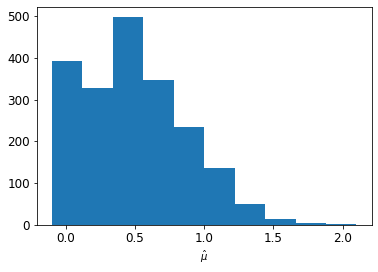

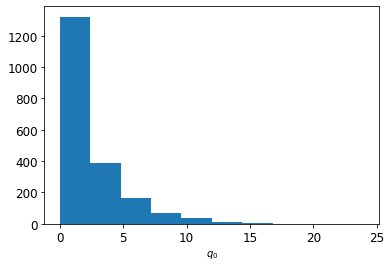

Z BL:(1.9884217493537617, 0.8233135765238061, 1.025075, 1.9887793625291965, 0.7861700376812931)
Z:1.1744621846045868
Z_std:1.14533738796858
Z_1:0.4589148858167688
Z_std_1:5.15401118770649
7
AUC:0.9029412086605457
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

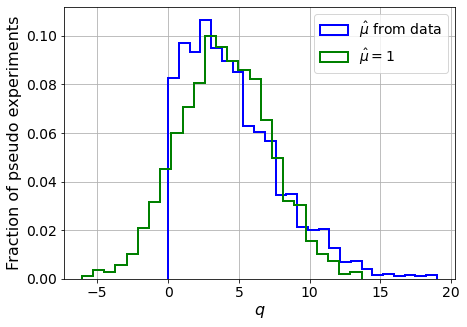

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  7435.87952466  7262.61767904  7040.85476165
  6758.66294891  6406.10310776  5963.54912726  5428.23184473
  4787.93186281  4007.70294323  3075.68700796  1971.07125559
   652.08445138  -904.61967302 -2754.70875781 -5320.72131543]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4353.16183153  4375.2103295   4380.54699241


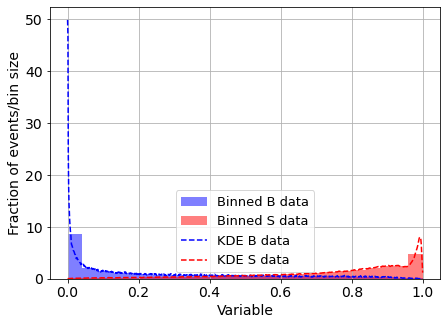

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.022598032384787827
0.022598032384787827
3 done
4 done
0.0
9.62087048428648e-05


  1%|▋                                                                | 22/2000 [00:07<12:30,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5286913315143729
<p_{s}(Sdata)> = 1.755671112542764
<p_{b}(Bdata)> = 8.212147808115896
<p_{s}(Bdata)> = 0.4138643301258175


  3%|██▏                                                              | 66/2000 [00:21<08:46,  3.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4156893158595859
<p_{s}(Sdata)> = 2.6348575932636065
<p_{b}(Bdata)> = 8.113320888263441
<p_{s}(Bdata)> = 0.42665148453061774


  4%|██▋                                                              | 82/2000 [00:26<10:07,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42022829583066856
<p_{s}(Sdata)> = 2.0319692699138225
<p_{b}(Bdata)> = 8.244673753267339
<p_{s}(Bdata)> = 0.4170113616906415


  5%|██▉                                                              | 92/2000 [00:29<08:51,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37738095338973837
<p_{s}(Sdata)> = 2.3119340073431798
<p_{b}(Bdata)> = 8.266934894980576
<p_{s}(Bdata)> = 0.4138208940438475


  6%|███▊                                                            | 118/2000 [00:36<05:44,  5.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4425313622289368
<p_{s}(Sdata)> = 2.0264012940169853
<p_{b}(Bdata)> = 8.003442215839627
<p_{s}(Bdata)> = 0.4160697831906104
muhat = -0.1
<p_{b}(Sdata)> = 0.5295902864958659
<p_{s}(Sdata)> = 2.062980473628644
<p_{b}(Bdata)> = 8.038117539427985
<p_{s}(Bdata)> = 0.4141725856275807


  7%|████▋                                                           | 147/2000 [00:45<08:45,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4140047664164434
<p_{s}(Sdata)> = 2.05017659880434
<p_{b}(Bdata)> = 8.196486958064941
<p_{s}(Bdata)> = 0.417461907283207


  8%|█████▏                                                          | 162/2000 [00:51<09:47,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3977003704363036
<p_{s}(Sdata)> = 2.369941924177515
<p_{b}(Bdata)> = 8.162340652633969
<p_{s}(Bdata)> = 0.4137470264040777


  9%|██████                                                          | 188/2000 [00:58<06:25,  4.70it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.44863943366244685
<p_{s}(Sdata)> = 2.4922496910991545
<p_{b}(Bdata)> = 8.11208738315914
<p_{s}(Bdata)> = 0.4295539286607787


 10%|██████▋                                                         | 210/2000 [01:05<11:08,  2.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3571009818349785
<p_{s}(Sdata)> = 2.320630810072413
<p_{b}(Bdata)> = 8.162549559702612
<p_{s}(Bdata)> = 0.4179453797136013


 11%|██████▊                                                         | 214/2000 [01:07<12:21,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3935270602006243
<p_{s}(Sdata)> = 2.2962303956283496
<p_{b}(Bdata)> = 8.098522428342632
<p_{s}(Bdata)> = 0.4185361085066374


 15%|█████████▍                                                      | 293/2000 [01:33<09:38,  2.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46919076474505006
<p_{s}(Sdata)> = 2.2201947060942255
<p_{b}(Bdata)> = 8.368349725305428
<p_{s}(Bdata)> = 0.41119706446951065


 15%|█████████▍                                                      | 295/2000 [01:33<07:31,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35846651457609185
<p_{s}(Sdata)> = 2.417015801338398
<p_{b}(Bdata)> = 8.252033458274804
<p_{s}(Bdata)> = 0.41804539995698264


 15%|█████████▊                                                      | 308/2000 [01:38<09:25,  2.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.34585795659209906
<p_{s}(Sdata)> = 2.5825540633176893
<p_{b}(Bdata)> = 8.187960444087754
<p_{s}(Bdata)> = 0.42550572702795214


 17%|██████████▉                                                     | 341/2000 [01:48<08:55,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4815228114359534
<p_{s}(Sdata)> = 2.328628973672922
<p_{b}(Bdata)> = 8.058171531131528
<p_{s}(Bdata)> = 0.4160119110256917


 18%|███████████▏                                                    | 351/2000 [01:51<09:10,  2.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43506605519197067
<p_{s}(Sdata)> = 2.1478590164852704
<p_{b}(Bdata)> = 8.097971940142779
<p_{s}(Bdata)> = 0.4139995567681847


 19%|████████████                                                    | 376/2000 [01:58<06:42,  4.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3942954712201873
<p_{s}(Sdata)> = 2.399981986113357
<p_{b}(Bdata)> = 8.179733184505954
<p_{s}(Bdata)> = 0.42876108479857145


 19%|████████████▍                                                   | 388/2000 [02:01<05:34,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36893262417054895
<p_{s}(Sdata)> = 2.433241384496551
<p_{b}(Bdata)> = 8.311533205377026
<p_{s}(Bdata)> = 0.4141916071267482
muhat = -0.1
<p_{b}(Sdata)> = 0.45037420845718595
<p_{s}(Sdata)> = 2.0119969952625683
<p_{b}(Bdata)> = 8.391488065810297
<p_{s}(Bdata)> = 0.4088654269344509


 22%|██████████████                                                  | 439/2000 [02:17<06:32,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4323647126705497
<p_{s}(Sdata)> = 2.0852720163261447
<p_{b}(Bdata)> = 8.024890464422187
<p_{s}(Bdata)> = 0.418832811198796


 22%|██████████████▏                                                 | 445/2000 [02:19<06:38,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4668240155046583
<p_{s}(Sdata)> = 2.0143265632635114
<p_{b}(Bdata)> = 8.097712756082041
<p_{s}(Bdata)> = 0.4156453218612802


 23%|██████████████▍                                                 | 453/2000 [02:21<07:48,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.419186944376283
<p_{s}(Sdata)> = 1.8462969189809155
<p_{b}(Bdata)> = 8.171724543743688
<p_{s}(Bdata)> = 0.4167329991305884


 26%|████████████████▌                                               | 519/2000 [02:41<09:06,  2.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.389761084734684
<p_{s}(Sdata)> = 2.134636609711334
<p_{b}(Bdata)> = 8.238430348425346
<p_{s}(Bdata)> = 0.41601753649191836


 26%|████████████████▋                                               | 522/2000 [02:42<06:38,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40671565889769773
<p_{s}(Sdata)> = 2.090335651665691
<p_{b}(Bdata)> = 8.09240223722242
<p_{s}(Bdata)> = 0.41862568833351627


 28%|██████████████████▏                                             | 569/2000 [02:56<05:16,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.452997890636662
<p_{s}(Sdata)> = 1.7733970348759895
<p_{b}(Bdata)> = 8.225351570580843
<p_{s}(Bdata)> = 0.4170121773322912


 30%|███████████████████▎                                            | 602/2000 [03:05<05:57,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4144622938913455
<p_{s}(Sdata)> = 2.1786936696812025
<p_{b}(Bdata)> = 8.184856988679911
<p_{s}(Bdata)> = 0.41446485123808424


 31%|███████████████████▌                                            | 611/2000 [03:08<05:25,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44937887628792444
<p_{s}(Sdata)> = 1.9714517727179952
<p_{b}(Bdata)> = 8.26516393740791
<p_{s}(Bdata)> = 0.4141481616759088


 32%|████████████████████▎                                           | 636/2000 [03:14<04:16,  5.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.45398254427045465
<p_{s}(Sdata)> = 2.280241381375415
<p_{b}(Bdata)> = 8.036110867075585
<p_{s}(Bdata)> = 0.4325663416768416


 32%|████████████████████▊                                           | 649/2000 [03:18<06:18,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4016705178843134
<p_{s}(Sdata)> = 2.2285718029984327
<p_{b}(Bdata)> = 8.002144160507912
<p_{s}(Bdata)> = 0.4209310848858234


 34%|█████████████████████▊                                          | 680/2000 [03:26<03:38,  6.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3696718766785925
<p_{s}(Sdata)> = 2.217232265013627
<p_{b}(Bdata)> = 8.153153475581538
<p_{s}(Bdata)> = 0.41958878960480755
muhat = -0.1
<p_{b}(Sdata)> = 0.44181658772889876
<p_{s}(Sdata)> = 2.3369984133858632
<p_{b}(Bdata)> = 8.050882578370468
<p_{s}(Bdata)> = 0.4162123123327355


 34%|█████████████████████▉                                          | 685/2000 [03:28<06:08,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3868943863774283
<p_{s}(Sdata)> = 2.3528779423412667
<p_{b}(Bdata)> = 8.024344633715456
<p_{s}(Bdata)> = 0.4164993120795026


 35%|██████████████████████▎                                         | 696/2000 [03:30<04:02,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43480255349052915
<p_{s}(Sdata)> = 2.161648928719816
<p_{b}(Bdata)> = 8.239029065266509
<p_{s}(Bdata)> = 0.41987245733183914
muhat = -0.1
<p_{b}(Sdata)> = 0.48034633316822384
<p_{s}(Sdata)> = 2.0602421634003405
<p_{b}(Bdata)> = 8.104591594698771
<p_{s}(Bdata)> = 0.42209661246635555


 36%|███████████████████████▎                                        | 730/2000 [03:41<06:10,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5377733997069613
<p_{s}(Sdata)> = 1.8442718046987947
<p_{b}(Bdata)> = 8.272791745518777
<p_{s}(Bdata)> = 0.41517385125957235


 37%|███████████████████████▉                                        | 747/2000 [03:45<04:52,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5200583634573648
<p_{s}(Sdata)> = 2.0708683821874327
<p_{b}(Bdata)> = 8.061522158876656
<p_{s}(Bdata)> = 0.4183655055451263


 38%|████████████████████████▎                                       | 759/2000 [03:49<06:43,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43796563908001285
<p_{s}(Sdata)> = 1.9158967231887216
<p_{b}(Bdata)> = 8.28021396283629
<p_{s}(Bdata)> = 0.4137974648762396


 39%|████████████████████████▉                                       | 780/2000 [03:56<07:33,  2.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.423545922433394
<p_{s}(Sdata)> = 1.880464554968989
<p_{b}(Bdata)> = 8.095749450995932
<p_{s}(Bdata)> = 0.4194244322911807


 40%|█████████████████████████▍                                      | 794/2000 [04:00<06:26,  3.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3746652415172802
<p_{s}(Sdata)> = 2.267226116236452
<p_{b}(Bdata)> = 8.049538705209539
<p_{s}(Bdata)> = 0.4164392157470545


 40%|█████████████████████████▊                                      | 805/2000 [04:03<04:20,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4120536310191474
<p_{s}(Sdata)> = 2.2533960143317704
<p_{b}(Bdata)> = 8.126704336329869
<p_{s}(Bdata)> = 0.41209690927401393


 43%|███████████████████████████▎                                    | 852/2000 [04:17<05:22,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4349872902342802
<p_{s}(Sdata)> = 1.9497532786215028
<p_{b}(Bdata)> = 8.217768630686798
<p_{s}(Bdata)> = 0.4168488044947274


 44%|███████████████████████████▉                                    | 872/2000 [04:23<05:23,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41778593530936425
<p_{s}(Sdata)> = 1.9040009522965957
<p_{b}(Bdata)> = 8.089018242356357
<p_{s}(Bdata)> = 0.4141388744915686


 46%|█████████████████████████████▏                                  | 913/2000 [04:35<04:34,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43979165089378036
<p_{s}(Sdata)> = 1.8850264195475792
<p_{b}(Bdata)> = 8.062130856147009
<p_{s}(Bdata)> = 0.4150802755015003


 47%|█████████████████████████████▉                                  | 935/2000 [04:41<05:02,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4713335223777551
<p_{s}(Sdata)> = 1.8625417136753584
<p_{b}(Bdata)> = 8.064414205091065
<p_{s}(Bdata)> = 0.418104657195154


 47%|██████████████████████████████▏                                 | 943/2000 [04:44<05:58,  2.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4028490510367672
<p_{s}(Sdata)> = 2.275992677723675
<p_{b}(Bdata)> = 8.20870382960849
<p_{s}(Bdata)> = 0.4148306483523537


 47%|██████████████████████████████▏                                 | 945/2000 [04:44<05:04,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38803829965851194
<p_{s}(Sdata)> = 2.292931290500611
<p_{b}(Bdata)> = 8.176418554945561
<p_{s}(Bdata)> = 0.4140511876583446


 48%|██████████████████████████████▉                                 | 965/2000 [04:51<07:16,  2.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4152438119210314
<p_{s}(Sdata)> = 2.015718235987618
<p_{b}(Bdata)> = 7.990230132677164
<p_{s}(Bdata)> = 0.4186260743742839


 49%|███████████████████████████████▍                                | 984/2000 [04:56<04:27,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3712605872174897
<p_{s}(Sdata)> = 2.22562459624649
<p_{b}(Bdata)> = 8.212461740158401
<p_{s}(Bdata)> = 0.4146224123806468


 52%|████████████████████████████████▍                              | 1030/2000 [05:09<04:42,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.445761252490777
<p_{s}(Sdata)> = 2.0325917509128537
<p_{b}(Bdata)> = 8.233455098324177
<p_{s}(Bdata)> = 0.4184801438319899


 53%|█████████████████████████████████▍                             | 1061/2000 [05:18<04:34,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3855401761729321
<p_{s}(Sdata)> = 2.0635994213547963
<p_{b}(Bdata)> = 8.01985819084063
<p_{s}(Bdata)> = 0.4213587990915736


 55%|██████████████████████████████████▋                            | 1100/2000 [05:28<04:59,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4338609571843158
<p_{s}(Sdata)> = 1.9650751064502805
<p_{b}(Bdata)> = 8.122424378236305
<p_{s}(Bdata)> = 0.41737369293471144


 56%|███████████████████████████████████▍                           | 1126/2000 [05:36<04:29,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4772523959124433
<p_{s}(Sdata)> = 1.9439227553685083
<p_{b}(Bdata)> = 8.136723878393664
<p_{s}(Bdata)> = 0.4172360102953508


 57%|███████████████████████████████████▋                           | 1134/2000 [05:39<05:05,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4141053530641781
<p_{s}(Sdata)> = 2.0205109961766388
<p_{b}(Bdata)> = 8.199374503160849
<p_{s}(Bdata)> = 0.41840295246039866


 57%|████████████████████████████████████                           | 1145/2000 [05:42<04:52,  2.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40319954969915234
<p_{s}(Sdata)> = 2.0880685900854874
<p_{b}(Bdata)> = 8.077058034688683
<p_{s}(Bdata)> = 0.42350546913909776


 61%|██████████████████████████████████████▏                        | 1214/2000 [06:02<02:54,  4.50it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4028667534741446
<p_{s}(Sdata)> = 2.3896099337683245
<p_{b}(Bdata)> = 8.139561599082453
<p_{s}(Bdata)> = 0.43069305576478495


 61%|██████████████████████████████████████▎                        | 1216/2000 [06:03<03:23,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4042793683113593
<p_{s}(Sdata)> = 2.026038283568184
<p_{b}(Bdata)> = 8.159031339943057
<p_{s}(Bdata)> = 0.411750234557525


 61%|██████████████████████████████████████▍                        | 1222/2000 [06:04<03:37,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3862851647400195
<p_{s}(Sdata)> = 2.0894768070951937
<p_{b}(Bdata)> = 8.128942434883367
<p_{s}(Bdata)> = 0.4146639177164571


 64%|████████████████████████████████████████                       | 1272/2000 [06:20<03:20,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45021079520621726
<p_{s}(Sdata)> = 1.7656461055670791
<p_{b}(Bdata)> = 8.055054170492575
<p_{s}(Bdata)> = 0.4202441071170039


 65%|█████████████████████████████████████████                      | 1305/2000 [06:29<02:52,  4.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42738901286942077
<p_{s}(Sdata)> = 1.9943633123100795
<p_{b}(Bdata)> = 8.183528997889391
<p_{s}(Bdata)> = 0.41461015918990746
muhat = -0.1
<p_{b}(Sdata)> = 0.8152977372845022
<p_{s}(Sdata)> = 2.0667747601106004
<p_{b}(Bdata)> = 8.092762238031774
<p_{s}(Bdata)> = 0.41678656033667133


 65%|█████████████████████████████████████████▏                     | 1309/2000 [06:30<02:46,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44380088133027024
<p_{s}(Sdata)> = 2.1219456671845984
<p_{b}(Bdata)> = 8.177881334337386
<p_{s}(Bdata)> = 0.4187666577311528


 68%|███████████████████████████████████████████                    | 1366/2000 [06:48<02:49,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4538318113137823
<p_{s}(Sdata)> = 1.6945754726992681
<p_{b}(Bdata)> = 8.251026112995167
<p_{s}(Bdata)> = 0.4220357825410235


 70%|███████████████████████████████████████████▉                   | 1393/2000 [06:56<02:44,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4162429301284957
<p_{s}(Sdata)> = 2.185016837171333
<p_{b}(Bdata)> = 8.127390680111873
<p_{s}(Bdata)> = 0.41887929613179076


 70%|████████████████████████████████████████████                   | 1399/2000 [06:58<03:22,  2.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3912028643214297
<p_{s}(Sdata)> = 2.03437340616066
<p_{b}(Bdata)> = 8.129031096228449
<p_{s}(Bdata)> = 0.41921865383243545


 71%|████████████████████████████████████████████▉                  | 1427/2000 [07:06<02:22,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4624453427446614
<p_{s}(Sdata)> = 1.8641849531555255
<p_{b}(Bdata)> = 8.261768717573913
<p_{s}(Bdata)> = 0.41310500358808105


 74%|██████████████████████████████████████████████▊                | 1487/2000 [07:23<02:02,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3154639881890055
<p_{s}(Sdata)> = 2.4216405682451323
<p_{b}(Bdata)> = 8.154568134947278
<p_{s}(Bdata)> = 0.4133006579005777


 75%|██████████████████████████████████████████████▉                | 1492/2000 [07:25<02:34,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38895942221037405
<p_{s}(Sdata)> = 2.165648528122781
<p_{b}(Bdata)> = 8.268877202032535
<p_{s}(Bdata)> = 0.4179592410929663


 75%|███████████████████████████████████████████████▎               | 1502/2000 [07:27<02:42,  3.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4491271230583553
<p_{s}(Sdata)> = 1.9348827808581837
<p_{b}(Bdata)> = 8.216248507255306
<p_{s}(Bdata)> = 0.4188078153587832


 76%|███████████████████████████████████████████████▌               | 1510/2000 [07:30<03:01,  2.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4127270608879999
<p_{s}(Sdata)> = 2.1780795803559845
<p_{b}(Bdata)> = 8.007082827343067
<p_{s}(Bdata)> = 0.42135939971960973


 77%|████████████████████████████████████████████████▎              | 1532/2000 [07:37<02:41,  2.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4387487816023502
<p_{s}(Sdata)> = 2.1274533956675548
<p_{b}(Bdata)> = 8.187251322722267
<p_{s}(Bdata)> = 0.42353026152997697


 78%|████████████████████████████████████████████████▉              | 1554/2000 [07:43<02:13,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39966369490550274
<p_{s}(Sdata)> = 2.0043854698564436
<p_{b}(Bdata)> = 8.218710228356144
<p_{s}(Bdata)> = 0.4130789362486527


 78%|█████████████████████████████████████████████████▎             | 1565/2000 [07:47<02:29,  2.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3430370762273543
<p_{s}(Sdata)> = 2.305092892023582
<p_{b}(Bdata)> = 8.113318209875017
<p_{s}(Bdata)> = 0.41851952688920296


 79%|█████████████████████████████████████████████████▊             | 1581/2000 [07:52<02:31,  2.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49014657655665733
<p_{s}(Sdata)> = 2.0606436629638862
<p_{b}(Bdata)> = 8.23209577225241
<p_{s}(Bdata)> = 0.4126514715119922


 81%|███████████████████████████████████████████████████▏           | 1626/2000 [08:05<01:53,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.372425657277767
<p_{s}(Sdata)> = 2.535560852820739
<p_{b}(Bdata)> = 8.210199308806253
<p_{s}(Bdata)> = 0.4215012107832225


 83%|████████████████████████████████████████████████████▌          | 1668/2000 [08:17<01:29,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.640157173488564
<p_{s}(Sdata)> = 1.7906763893191537
<p_{b}(Bdata)> = 8.147977900892833
<p_{s}(Bdata)> = 0.418221735453161


 84%|████████████████████████████████████████████████████▋          | 1674/2000 [08:19<01:08,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4087399730096082
<p_{s}(Sdata)> = 2.2153919903250636
<p_{b}(Bdata)> = 8.25972435936506
<p_{s}(Bdata)> = 0.4172716473734371


 84%|█████████████████████████████████████████████████████          | 1684/2000 [08:22<01:22,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4020646578610195
<p_{s}(Sdata)> = 2.1959808491780977
<p_{b}(Bdata)> = 7.891753244335007
<p_{s}(Bdata)> = 0.42008286735691336


 85%|█████████████████████████████████████████████████████▎         | 1692/2000 [08:24<01:11,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4842185567539533
<p_{s}(Sdata)> = 1.8542982050019985
<p_{b}(Bdata)> = 8.085269442379122
<p_{s}(Bdata)> = 0.4174142798224721


 85%|█████████████████████████████████████████████████████▋         | 1704/2000 [08:27<01:23,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3963840890840641
<p_{s}(Sdata)> = 2.031742802740141
<p_{b}(Bdata)> = 8.00023254696045
<p_{s}(Bdata)> = 0.41552740572587016


 86%|██████████████████████████████████████████████████████▍        | 1727/2000 [08:33<01:13,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48078360730261815
<p_{s}(Sdata)> = 2.0614775886790704
<p_{b}(Bdata)> = 8.24123361797863
<p_{s}(Bdata)> = 0.41530428812050446


 90%|████████████████████████████████████████████████████████▊      | 1802/2000 [08:57<00:52,  3.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.511462019888489
<p_{s}(Sdata)> = 1.8124461266074028
<p_{b}(Bdata)> = 8.12430117099821
<p_{s}(Bdata)> = 0.4194090716425322


 92%|█████████████████████████████████████████████████████████▋     | 1832/2000 [09:06<00:47,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4371579943601821
<p_{s}(Sdata)> = 2.1690675038654947
<p_{b}(Bdata)> = 8.197113170498316
<p_{s}(Bdata)> = 0.4158751652101808


 92%|█████████████████████████████████████████████████████████▊     | 1835/2000 [09:07<00:40,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39266594879762945
<p_{s}(Sdata)> = 2.0363014049335573
<p_{b}(Bdata)> = 8.14851399205208
<p_{s}(Bdata)> = 0.41717175041251353


 93%|██████████████████████████████████████████████████████████▎    | 1853/2000 [09:12<00:41,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7677139539059497
<p_{s}(Sdata)> = 2.1096207473707214
<p_{b}(Bdata)> = 8.101582568512962
<p_{s}(Bdata)> = 0.4200673205975914


 94%|███████████████████████████████████████████████████████████▏   | 1877/2000 [09:19<00:39,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40963711586146845
<p_{s}(Sdata)> = 2.030627211382944
<p_{b}(Bdata)> = 8.134873151425117
<p_{s}(Bdata)> = 0.41945889746117937


 95%|███████████████████████████████████████████████████████████▉   | 1902/2000 [09:26<00:25,  3.83it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4610101385539336
<p_{s}(Sdata)> = 2.386168874904018
<p_{b}(Bdata)> = 8.11450089185561
<p_{s}(Bdata)> = 0.4269222514335123


 96%|████████████████████████████████████████████████████████████▍  | 1917/2000 [09:32<00:30,  2.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48239895129954413
<p_{s}(Sdata)> = 1.9830439651865124
<p_{b}(Bdata)> = 8.018697465796953
<p_{s}(Bdata)> = 0.4192563634808957


 97%|█████████████████████████████████████████████████████████████▍ | 1949/2000 [09:41<00:10,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4425423040406113
<p_{s}(Sdata)> = 1.9518379066778635
<p_{b}(Bdata)> = 8.177036164150344
<p_{s}(Bdata)> = 0.414563951319105


 98%|█████████████████████████████████████████████████████████████▊ | 1963/2000 [09:45<00:09,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4057358576340951
<p_{s}(Sdata)> = 2.036836654637261
<p_{b}(Bdata)> = 8.134313561223626
<p_{s}(Bdata)> = 0.41645035303696204


 99%|██████████████████████████████████████████████████████████████▏| 1974/2000 [09:48<00:08,  3.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39129256730588413
<p_{s}(Sdata)> = 2.2451792260667545
<p_{b}(Bdata)> = 8.150716406794801
<p_{s}(Bdata)> = 0.4153240251368343


 99%|██████████████████████████████████████████████████████████████▍| 1984/2000 [09:51<00:05,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41602137464721345
<p_{s}(Sdata)> = 1.790414344074708
<p_{b}(Bdata)> = 8.256029092387775
<p_{s}(Bdata)> = 0.42143303542715915


100%|██████████████████████████████████████████████████████████████▋| 1991/2000 [09:52<00:01,  6.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48541422458375116
<p_{s}(Sdata)> = 2.0153531043791886
<p_{b}(Bdata)> = 8.199856256512899
<p_{s}(Bdata)> = 0.41607078434209027
muhat = -0.1
<p_{b}(Sdata)> = 0.5004023023692076
<p_{s}(Sdata)> = 1.7332494785356691
<p_{b}(Bdata)> = 8.139701642167832
<p_{s}(Bdata)> = 0.4142981716409366


100%|███████████████████████████████████████████████████████████████| 2000/2000 [09:55<00:00,  3.36it/s]


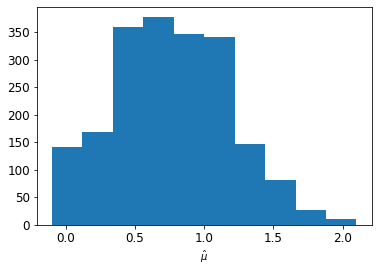

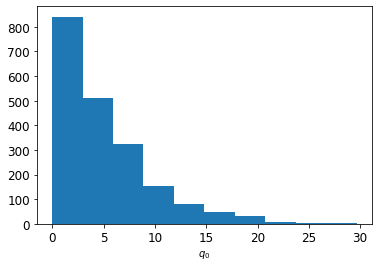

Z BL:(1.993781565906986, 0.8253836778146211, 1.0327000000000002, 1.9947907954821205, 0.8019321364330758)
Z:1.934748450140421
Z_std:1.1778409682811117
Z_1:1.832808922947736
Z_std_1:1.5135762589358204
8
AUC:0.9026962746666057
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

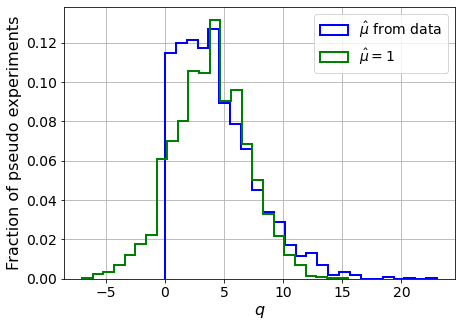

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  7439.50158545  7254.77285162  7018.54928215
  6718.31419317  6347.84964369  5897.69809777  5355.34103782
  4717.09261578  3940.48615063  3010.92407491  1923.62412404
   622.79369543  -926.32530867 -2764.29543925 -5324.87256572]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4364.16476312  4390.00218331  4397.51923254


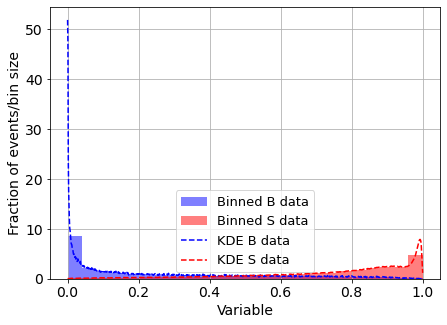

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.016910995508116672
0.016910995508116672
3 done
4 done
0.0
2.3157782671342984e-05


  0%|                                                                  | 1/2000 [00:00<04:38,  7.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4063859862879856
<p_{s}(Sdata)> = 2.441242532159798
<p_{b}(Bdata)> = 8.27369341374947
<p_{s}(Bdata)> = 0.41764930076887835


  0%|▏                                                                 | 5/2000 [00:01<09:57,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3859990020354407
<p_{s}(Sdata)> = 2.3143984620131985
<p_{b}(Bdata)> = 8.316744788040495
<p_{s}(Bdata)> = 0.4176803675664892


  1%|▌                                                                | 18/2000 [00:08<14:34,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5773354333747478
<p_{s}(Sdata)> = 1.9143899249208318
<p_{b}(Bdata)> = 8.343514223460419
<p_{s}(Bdata)> = 0.4245279247633728


  3%|█▋                                                               | 51/2000 [00:26<12:34,  2.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46067349108555344
<p_{s}(Sdata)> = 1.7683574638588149
<p_{b}(Bdata)> = 8.434628690649314
<p_{s}(Bdata)> = 0.42176107070175634


  3%|█▉                                                               | 59/2000 [00:30<14:15,  2.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42171215310131344
<p_{s}(Sdata)> = 1.9422386431057888
<p_{b}(Bdata)> = 8.329971025318503
<p_{s}(Bdata)> = 0.42442859167192154


  3%|█▉                                                               | 61/2000 [00:30<10:04,  3.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40445877531974533
<p_{s}(Sdata)> = 1.892550605464124
<p_{b}(Bdata)> = 8.303403948563655
<p_{s}(Bdata)> = 0.42115839899946345


  3%|██▏                                                              | 68/2000 [00:34<13:38,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5347032365663474
<p_{s}(Sdata)> = 1.847206785450771
<p_{b}(Bdata)> = 8.411781662227957
<p_{s}(Bdata)> = 0.42407964459641145


  4%|██▎                                                              | 71/2000 [00:35<13:28,  2.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3804690423188562
<p_{s}(Sdata)> = 2.368266724351788
<p_{b}(Bdata)> = 8.428263179810108
<p_{s}(Bdata)> = 0.41803394991746207


  7%|████▍                                                           | 139/2000 [01:12<12:26,  2.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.40066188463776414
<p_{s}(Sdata)> = 2.4036429182324084
<p_{b}(Bdata)> = 8.31292263000397
<p_{s}(Bdata)> = 0.4279857491488373


  7%|████▋                                                           | 147/2000 [01:16<12:52,  2.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4603226811756057
<p_{s}(Sdata)> = 1.8775986431048426
<p_{b}(Bdata)> = 8.440359212342539
<p_{s}(Bdata)> = 0.42232533408855877


 10%|██████▍                                                         | 202/2000 [01:46<12:25,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42661705247282117
<p_{s}(Sdata)> = 1.8976647621608638
<p_{b}(Bdata)> = 8.603026803350236
<p_{s}(Bdata)> = 0.4153459013430007


 11%|██████▊                                                         | 214/2000 [01:53<15:02,  1.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3511684754820163
<p_{s}(Sdata)> = 2.4609851296161485
<p_{b}(Bdata)> = 8.27335280546157
<p_{s}(Bdata)> = 0.41974550977822334


 11%|███████                                                         | 221/2000 [01:56<11:16,  2.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43251794930911486
<p_{s}(Sdata)> = 1.997050128906764
<p_{b}(Bdata)> = 8.215206618186086
<p_{s}(Bdata)> = 0.42861955261529094


 11%|███████▏                                                        | 225/2000 [01:57<08:49,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4199460855544129
<p_{s}(Sdata)> = 2.035829038199606
<p_{b}(Bdata)> = 8.290575703684816
<p_{s}(Bdata)> = 0.4190381661179416


 12%|███████▌                                                        | 238/2000 [02:03<10:26,  2.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4062111404370685
<p_{s}(Sdata)> = 2.119726649890458
<p_{b}(Bdata)> = 8.428895873046455
<p_{s}(Bdata)> = 0.417470526192945


 12%|███████▋                                                        | 241/2000 [02:04<10:46,  2.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3653261088242671
<p_{s}(Sdata)> = 2.2752958192506547
<p_{b}(Bdata)> = 8.42667616985754
<p_{s}(Bdata)> = 0.4150905343271196


 18%|███████████▎                                                    | 355/2000 [03:08<13:14,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4959779051981135
<p_{s}(Sdata)> = 1.6797729368815915
<p_{b}(Bdata)> = 8.504190591800022
<p_{s}(Bdata)> = 0.4199808350284006


 18%|███████████▌                                                    | 361/2000 [03:11<12:07,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6034762158118656
<p_{s}(Sdata)> = 2.0712027087457727
<p_{b}(Bdata)> = 8.281966939615348
<p_{s}(Bdata)> = 0.4172401797308661


 18%|███████████▋                                                    | 365/2000 [03:13<12:52,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4783332596730301
<p_{s}(Sdata)> = 1.7177579918891481
<p_{b}(Bdata)> = 8.444159691923794
<p_{s}(Bdata)> = 0.4227998299773156


 19%|███████████▊                                                    | 371/2000 [03:16<12:14,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5883491563532977
<p_{s}(Sdata)> = 1.5888035332062955
<p_{b}(Bdata)> = 8.460980769241985
<p_{s}(Bdata)> = 0.4197919091895142


 19%|████████████▍                                                   | 389/2000 [03:25<10:22,  2.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4121207588158687
<p_{s}(Sdata)> = 2.2954845408477333
<p_{b}(Bdata)> = 8.406307950042972
<p_{s}(Bdata)> = 0.4154227297821442


 21%|█████████████▏                                                  | 414/2000 [03:37<09:34,  2.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4323039316907727
<p_{s}(Sdata)> = 1.7186059682283141
<p_{b}(Bdata)> = 8.422939350849344
<p_{s}(Bdata)> = 0.4208015840477538


 21%|█████████████▍                                                  | 418/2000 [03:39<10:02,  2.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40888778141643517
<p_{s}(Sdata)> = 2.0575411820031673
<p_{b}(Bdata)> = 8.323112698961168
<p_{s}(Bdata)> = 0.4238242917254091


 21%|█████████████▋                                                  | 429/2000 [03:45<09:21,  2.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43081298295028386
<p_{s}(Sdata)> = 1.9207768142974275
<p_{b}(Bdata)> = 8.320148880447439
<p_{s}(Bdata)> = 0.4198139135325818
muhat = -0.1
<p_{b}(Sdata)> = 0.4377271842041444
<p_{s}(Sdata)> = 1.9676729061455747
<p_{b}(Bdata)> = 8.505575358392115
<p_{s}(Bdata)> = 0.4216889125271388


 24%|███████████████▍                                                | 484/2000 [04:15<10:09,  2.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40358996326400376
<p_{s}(Sdata)> = 2.2830829952685106
<p_{b}(Bdata)> = 8.235954417064162
<p_{s}(Bdata)> = 0.4206123643629184


 24%|███████████████▌                                                | 486/2000 [04:16<09:30,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4430843268080773
<p_{s}(Sdata)> = 1.9414138264454592
<p_{b}(Bdata)> = 8.288924435019156
<p_{s}(Bdata)> = 0.4164993638741746


 24%|███████████████▌                                                | 488/2000 [04:17<09:36,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4198758173265646
<p_{s}(Sdata)> = 2.0652685085176192
<p_{b}(Bdata)> = 8.379044341773863
<p_{s}(Bdata)> = 0.41521709242043425


 25%|████████████████                                                | 503/2000 [04:25<11:32,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44769560825746474
<p_{s}(Sdata)> = 2.1967166591926435
<p_{b}(Bdata)> = 8.473276668111845
<p_{s}(Bdata)> = 0.413910839532621


 26%|████████████████▋                                               | 521/2000 [04:35<09:25,  2.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39835173633632276
<p_{s}(Sdata)> = 2.121714361431919
<p_{b}(Bdata)> = 8.369567457504461
<p_{s}(Bdata)> = 0.4187424997856523


 30%|███████████████████                                             | 594/2000 [05:17<12:13,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4463626868408277
<p_{s}(Sdata)> = 1.7326479276353368
<p_{b}(Bdata)> = 8.319530272484123
<p_{s}(Bdata)> = 0.42298338167282057


 31%|███████████████████▌                                            | 611/2000 [05:26<10:59,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4554800845005955
<p_{s}(Sdata)> = 1.8980447271746153
<p_{b}(Bdata)> = 8.26265829433482
<p_{s}(Bdata)> = 0.42045070229582204


 33%|████████████████████▊                                           | 652/2000 [05:49<08:39,  2.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39179992684037396
<p_{s}(Sdata)> = 2.160336556007068
<p_{b}(Bdata)> = 8.334142322392172
<p_{s}(Bdata)> = 0.4186745615378974


 39%|████████████████████████▋                                       | 771/2000 [06:56<10:04,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5104543886587278
<p_{s}(Sdata)> = 1.999595588020656
<p_{b}(Bdata)> = 8.251833496823616
<p_{s}(Bdata)> = 0.4173877230318438


 39%|████████████████████████▊                                       | 777/2000 [06:58<10:00,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4175870090860738
<p_{s}(Sdata)> = 2.303110928810944
<p_{b}(Bdata)> = 8.455446995404255
<p_{s}(Bdata)> = 0.427012384756047


 40%|█████████████████████████▌                                      | 797/2000 [07:09<07:37,  2.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42389246203365677
<p_{s}(Sdata)> = 1.911457155692274
<p_{b}(Bdata)> = 8.505502926037543
<p_{s}(Bdata)> = 0.4158682628507642


 41%|██████████████████████████▏                                     | 817/2000 [07:20<10:01,  1.97it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5201056493342685
<p_{s}(Sdata)> = 2.3162498435922876
<p_{b}(Bdata)> = 8.483275275459393
<p_{s}(Bdata)> = 0.4296423845118857


 41%|██████████████████████████▏                                     | 820/2000 [07:21<08:12,  2.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40873656335145
<p_{s}(Sdata)> = 1.8351816389456093
<p_{b}(Bdata)> = 8.38057264594921
<p_{s}(Bdata)> = 0.42027690107822463


 42%|███████████████████████████▏                                    | 850/2000 [07:37<07:34,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3992937491134211
<p_{s}(Sdata)> = 2.2658293885154577
<p_{b}(Bdata)> = 8.304799929291597
<p_{s}(Bdata)> = 0.4199879088345066


 44%|████████████████████████████▍                                   | 889/2000 [07:58<06:18,  2.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4076702199630348
<p_{s}(Sdata)> = 2.1450375787392564
<p_{b}(Bdata)> = 8.355733186209504
<p_{s}(Bdata)> = 0.4240293879672093


 45%|████████████████████████████▋                                   | 897/2000 [08:01<07:09,  2.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40102974306545874
<p_{s}(Sdata)> = 2.2451080734604885
<p_{b}(Bdata)> = 8.29256730153011
<p_{s}(Bdata)> = 0.41678498909582834


 46%|█████████████████████████████▊                                  | 930/2000 [08:18<07:32,  2.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41710068721563953
<p_{s}(Sdata)> = 1.9549379673722922
<p_{b}(Bdata)> = 8.371414171879518
<p_{s}(Bdata)> = 0.4237681209085594


 47%|██████████████████████████████                                  | 938/2000 [08:22<06:45,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4907659164556634
<p_{s}(Sdata)> = 2.014868085267683
<p_{b}(Bdata)> = 8.214551877884581
<p_{s}(Bdata)> = 0.424797423534763


 47%|██████████████████████████████▎                                 | 946/2000 [08:27<07:20,  2.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4547053369426423
<p_{s}(Sdata)> = 1.8867134236624206
<p_{b}(Bdata)> = 8.100379555483793
<p_{s}(Bdata)> = 0.42108184248026737


 48%|██████████████████████████████▊                                 | 963/2000 [08:35<07:35,  2.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46086822681214645
<p_{s}(Sdata)> = 1.9640764415992777
<p_{b}(Bdata)> = 8.326276011639896
<p_{s}(Bdata)> = 0.4182114429753394


 48%|██████████████████████████████▉                                 | 966/2000 [08:37<07:01,  2.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47362383428241855
<p_{s}(Sdata)> = 1.9369560173621343
<p_{b}(Bdata)> = 8.387341334459082
<p_{s}(Bdata)> = 0.42471825605254343


 49%|███████████████████████████████▎                                | 979/2000 [08:44<09:26,  1.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.715306048592493
<p_{s}(Sdata)> = 2.104424900910632
<p_{b}(Bdata)> = 8.329222466546641
<p_{s}(Bdata)> = 0.4200855250728606


 50%|███████████████████████████████▊                                | 994/2000 [08:54<09:20,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44456702959742134
<p_{s}(Sdata)> = 1.9729587539413669
<p_{b}(Bdata)> = 8.431451502171152
<p_{s}(Bdata)> = 0.4234185147722922


 50%|███████████████████████████████▉                                | 998/2000 [08:56<08:12,  2.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3950353001115542
<p_{s}(Sdata)> = 2.2243929623850733
<p_{b}(Bdata)> = 8.321592915583468
<p_{s}(Bdata)> = 0.41929816556008864


 51%|████████████████████████████████                               | 1016/2000 [09:11<11:30,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43120288605235296
<p_{s}(Sdata)> = 1.889080132449981
<p_{b}(Bdata)> = 8.282099189110115
<p_{s}(Bdata)> = 0.41822719682219356


 51%|████████████████████████████████▏                              | 1021/2000 [09:14<08:31,  1.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4453671887072528
<p_{s}(Sdata)> = 2.0269452385862317
<p_{b}(Bdata)> = 8.395308495572255
<p_{s}(Bdata)> = 0.41962259961377213


 52%|████████████████████████████████▌                              | 1035/2000 [09:21<06:33,  2.45it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3521247470340311
<p_{s}(Sdata)> = 2.799228470063141
<p_{b}(Bdata)> = 8.315818528042248
<p_{s}(Bdata)> = 0.4266361906493535


 52%|████████████████████████████████▊                              | 1040/2000 [09:23<06:06,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46810541485665225
<p_{s}(Sdata)> = 1.9327428199827905
<p_{b}(Bdata)> = 8.333358397966453
<p_{s}(Bdata)> = 0.4207426982439603


 56%|███████████████████████████████████▏                           | 1119/2000 [10:07<06:47,  2.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4371956768980581
<p_{s}(Sdata)> = 2.296137829358768
<p_{b}(Bdata)> = 8.399064738312077
<p_{s}(Bdata)> = 0.41900262780106373


 58%|████████████████████████████████████▌                          | 1160/2000 [10:22<03:17,  4.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4758423961874417
<p_{s}(Sdata)> = 2.396222884782566
<p_{b}(Bdata)> = 8.437782651875647
<p_{s}(Bdata)> = 0.43084637040225965


 59%|█████████████████████████████████████▏                         | 1179/2000 [10:28<05:06,  2.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4259030138147929
<p_{s}(Sdata)> = 1.748050869360666
<p_{b}(Bdata)> = 8.324976843645482
<p_{s}(Bdata)> = 0.4222262992303314


 60%|█████████████████████████████████████▍                         | 1190/2000 [10:31<04:05,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38067927568501814
<p_{s}(Sdata)> = 2.38230107285706
<p_{b}(Bdata)> = 8.43584812957031
<p_{s}(Bdata)> = 0.4179648994511268


 61%|██████████████████████████████████████▍                        | 1221/2000 [10:40<02:55,  4.43it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.378511277893476
<p_{s}(Sdata)> = 2.566642387127396
<p_{b}(Bdata)> = 8.438749782017227
<p_{s}(Bdata)> = 0.4278465310420841


 63%|███████████████████████████████████████▊                       | 1263/2000 [10:54<02:49,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4036847217749887
<p_{s}(Sdata)> = 2.111703928541597
<p_{b}(Bdata)> = 8.381608558482212
<p_{s}(Bdata)> = 0.41986885699730353


 67%|██████████████████████████████████████████▎                    | 1345/2000 [11:21<03:17,  3.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41471221810989656
<p_{s}(Sdata)> = 1.9568893904677689
<p_{b}(Bdata)> = 8.304720971190962
<p_{s}(Bdata)> = 0.41531659895923856


 68%|███████████████████████████████████████████                    | 1366/2000 [11:27<02:48,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44501281877390786
<p_{s}(Sdata)> = 2.1651073234515676
<p_{b}(Bdata)> = 8.291284145417961
<p_{s}(Bdata)> = 0.42057656437126856


 68%|███████████████████████████████████████████                    | 1369/2000 [11:28<02:43,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4436439445966261
<p_{s}(Sdata)> = 1.9913866141076382
<p_{b}(Bdata)> = 8.415484137080954
<p_{s}(Bdata)> = 0.41978854477792593


 69%|███████████████████████████████████████████▌                   | 1382/2000 [11:31<02:28,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6153961822479559
<p_{s}(Sdata)> = 1.8569446257897042
<p_{b}(Bdata)> = 8.128533504565162
<p_{s}(Bdata)> = 0.4243260143043067


 71%|████████████████████████████████████████████▊                  | 1424/2000 [11:46<03:11,  3.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49876340067359265
<p_{s}(Sdata)> = 1.7963894090744361
<p_{b}(Bdata)> = 8.266783423049079
<p_{s}(Bdata)> = 0.42667168134493266


 71%|█████████████████████████████████████████████                  | 1429/2000 [11:47<02:42,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4694463300597427
<p_{s}(Sdata)> = 1.7440783402646542
<p_{b}(Bdata)> = 8.424905904497082
<p_{s}(Bdata)> = 0.4200347290246276


 73%|██████████████████████████████████████████████▎                | 1469/2000 [12:00<02:03,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4284662878713277
<p_{s}(Sdata)> = 2.044558295422721
<p_{b}(Bdata)> = 8.254936817674636
<p_{s}(Bdata)> = 0.42289953737143154


 75%|███████████████████████████████████████████████▎               | 1503/2000 [12:11<02:35,  3.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4809062639356119
<p_{s}(Sdata)> = 2.32741983394932
<p_{b}(Bdata)> = 8.389452392281125
<p_{s}(Bdata)> = 0.4148198328042187


 78%|█████████████████████████████████████████████████              | 1556/2000 [12:28<02:23,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5317007473566611
<p_{s}(Sdata)> = 1.992033906419706
<p_{b}(Bdata)> = 8.513291797258127
<p_{s}(Bdata)> = 0.4162372958220463


 78%|█████████████████████████████████████████████████▍             | 1569/2000 [12:32<02:27,  2.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3965860009772102
<p_{s}(Sdata)> = 2.057139638677561
<p_{b}(Bdata)> = 8.350322129831673
<p_{s}(Bdata)> = 0.42152385546784116


 80%|██████████████████████████████████████████████████             | 1590/2000 [12:39<01:49,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46852546545396645
<p_{s}(Sdata)> = 1.974413231263079
<p_{b}(Bdata)> = 8.503505687033028
<p_{s}(Bdata)> = 0.4177350769407641


 81%|██████████████████████████████████████████████████▊            | 1615/2000 [12:46<02:17,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5253494940425687
<p_{s}(Sdata)> = 1.9235193925242544
<p_{b}(Bdata)> = 8.426471192873667
<p_{s}(Bdata)> = 0.42332751005238106


 82%|███████████████████████████████████████████████████▍           | 1631/2000 [12:52<02:21,  2.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4451274472531969
<p_{s}(Sdata)> = 1.8977931027144603
<p_{b}(Bdata)> = 8.521694246712952
<p_{s}(Bdata)> = 0.4220926280433005


 82%|███████████████████████████████████████████████████▉           | 1650/2000 [12:57<01:26,  4.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46658288976984186
<p_{s}(Sdata)> = 1.8665069427936225
<p_{b}(Bdata)> = 8.182850382272775
<p_{s}(Bdata)> = 0.42232481454519516


 83%|████████████████████████████████████████████████████▍          | 1664/2000 [13:02<01:50,  3.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4231331240231501
<p_{s}(Sdata)> = 2.2730514651171463
<p_{b}(Bdata)> = 8.411806069602726
<p_{s}(Bdata)> = 0.41956406947138086


 84%|████████████████████████████████████████████████████▊          | 1676/2000 [13:06<01:46,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3521703647437795
<p_{s}(Sdata)> = 2.18841702178928
<p_{b}(Bdata)> = 8.367910345793357
<p_{s}(Bdata)> = 0.4213125239941626


 84%|████████████████████████████████████████████████████▊          | 1678/2000 [13:06<01:22,  3.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5342052006333291
<p_{s}(Sdata)> = 1.7225363364530195
<p_{b}(Bdata)> = 8.41351805503756
<p_{s}(Bdata)> = 0.41843563944003104


 88%|███████████████████████████████████████████████████████▋       | 1767/2000 [13:36<01:29,  2.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39507421098897777
<p_{s}(Sdata)> = 2.3975013895139226
<p_{b}(Bdata)> = 8.37236789167596
<p_{s}(Bdata)> = 0.42053499130765026


 90%|████████████████████████████████████████████████████████▊      | 1804/2000 [13:46<00:33,  5.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4308200328989323
<p_{s}(Sdata)> = 1.987396897882647
<p_{b}(Bdata)> = 8.360072624839365
<p_{s}(Bdata)> = 0.4200715866145238
muhat = -0.1
<p_{b}(Sdata)> = 0.4106269516566365
<p_{s}(Sdata)> = 2.000907957735961
<p_{b}(Bdata)> = 8.34916006717188
<p_{s}(Bdata)> = 0.4222139471503382


 91%|█████████████████████████████████████████████████████████▍     | 1822/2000 [13:52<01:03,  2.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47942265707022336
<p_{s}(Sdata)> = 1.7954582135566133
<p_{b}(Bdata)> = 8.249993393307603
<p_{s}(Bdata)> = 0.4269854100129515


 92%|█████████████████████████████████████████████████████████▋     | 1833/2000 [13:55<00:48,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44210887608857735
<p_{s}(Sdata)> = 1.8773373322337021
<p_{b}(Bdata)> = 8.303816175713882
<p_{s}(Bdata)> = 0.4169272559499663


 92%|██████████████████████████████████████████████████████████     | 1845/2000 [13:59<00:43,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39298740676907007
<p_{s}(Sdata)> = 2.0871723031577845
<p_{b}(Bdata)> = 8.48900120647179
<p_{s}(Bdata)> = 0.42168196754902226


 94%|███████████████████████████████████████████████████████████▏   | 1880/2000 [14:09<00:38,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35806390933242266
<p_{s}(Sdata)> = 2.462582702952408
<p_{b}(Bdata)> = 8.467081360532761
<p_{s}(Bdata)> = 0.4216775908957871


 95%|███████████████████████████████████████████████████████████▌   | 1891/2000 [14:13<00:40,  2.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40613578946279005
<p_{s}(Sdata)> = 2.243102197066831
<p_{b}(Bdata)> = 8.421349293869051
<p_{s}(Bdata)> = 0.42058461661813296


 97%|█████████████████████████████████████████████████████████████▎ | 1945/2000 [14:31<00:20,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4058455312296053
<p_{s}(Sdata)> = 2.0699771057075487
<p_{b}(Bdata)> = 8.463218296050847
<p_{s}(Bdata)> = 0.4218640433657595


100%|███████████████████████████████████████████████████████████████| 2000/2000 [14:49<00:00,  2.25it/s]


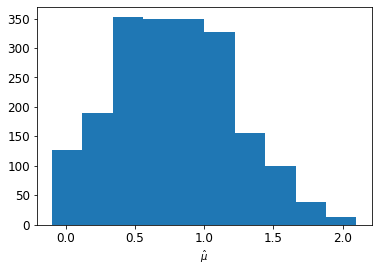

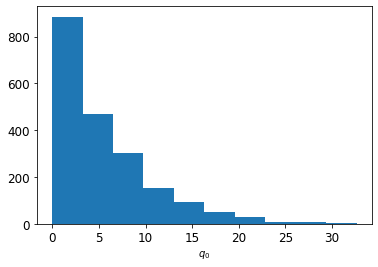

Z BL:(1.9669102799214462, 0.8136962371831946, 1.0246000000000002, 1.969286588124275, 0.7995589284014248)
Z:1.9668634074841713
Z_std:1.317378933385271
Z_1:1.894000899216155
Z_std_1:1.5879023661887315
9
AUC:0.9023758454876669
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

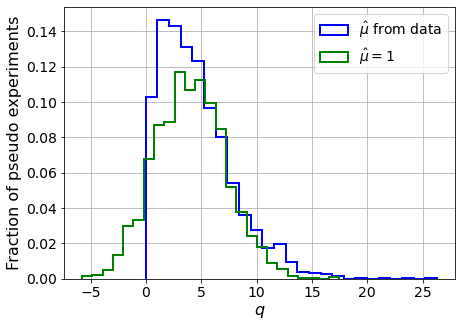

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  7170.15680244  7009.32554654  6801.31147533
  6535.7798413   6194.69524345  5774.86239581  5262.42494095
  4644.83513635  3884.00790694  2979.48426436  1903.13289551
   627.10342641  -900.98603097 -2728.67891512 -5306.97060195]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4286.92345569  4297.02641794


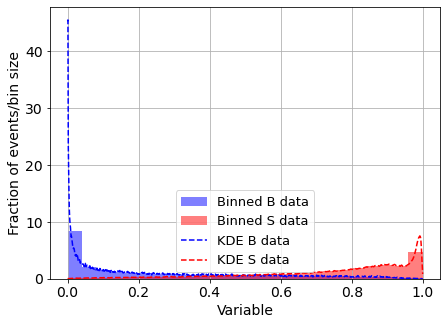

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.02249363528350227
0.02249363528350227
3 done
4 done
0.0
4.0749530430547296e-05


  6%|███▌                                                            | 113/2000 [00:38<12:08,  2.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6917503862133553
<p_{s}(Sdata)> = 1.8476365087804798
<p_{b}(Bdata)> = 7.413483187525559
<p_{s}(Bdata)> = 0.42294779505102414


  7%|████▋                                                           | 145/2000 [00:47<09:35,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4136573913702781
<p_{s}(Sdata)> = 2.1011853158915073
<p_{b}(Bdata)> = 7.291389212387162
<p_{s}(Bdata)> = 0.4218290617185029


  8%|████▉                                                           | 153/2000 [00:50<12:01,  2.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4609120743593861
<p_{s}(Sdata)> = 1.9047769697502144
<p_{b}(Bdata)> = 7.448809950263013
<p_{s}(Bdata)> = 0.4234958493104801


  8%|█████                                                           | 160/2000 [00:52<07:32,  4.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3752403444927978
<p_{s}(Sdata)> = 2.350409320354715
<p_{b}(Bdata)> = 7.456944456579263
<p_{s}(Bdata)> = 0.42674097565212105


 10%|██████▍                                                         | 200/2000 [01:06<08:47,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5530634599643097
<p_{s}(Sdata)> = 2.020782021593365
<p_{b}(Bdata)> = 7.539072104139282
<p_{s}(Bdata)> = 0.418746585886329


 10%|██████▌                                                         | 206/2000 [01:07<08:34,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43036280880784333
<p_{s}(Sdata)> = 2.1570002374527566
<p_{b}(Bdata)> = 7.524966311395098
<p_{s}(Bdata)> = 0.4206719956837367


 12%|███████▌                                                        | 237/2000 [01:17<08:31,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4556295844868483
<p_{s}(Sdata)> = 1.9010761675859038
<p_{b}(Bdata)> = 7.380466953702394
<p_{s}(Bdata)> = 0.42020556715149515


 13%|████████▎                                                       | 259/2000 [01:24<07:56,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5015946227907524
<p_{s}(Sdata)> = 2.005071818094864
<p_{b}(Bdata)> = 7.442178876673665
<p_{s}(Bdata)> = 0.4199649470738538


 13%|████████▍                                                       | 262/2000 [01:25<08:12,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4119479276665511
<p_{s}(Sdata)> = 1.9815549871839293
<p_{b}(Bdata)> = 7.388822706638482
<p_{s}(Bdata)> = 0.4198298260409926


 14%|████████▉                                                       | 278/2000 [01:30<11:03,  2.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4791960801933259
<p_{s}(Sdata)> = 1.9222331993711923
<p_{b}(Bdata)> = 7.5052729762607875
<p_{s}(Bdata)> = 0.4189743209648278


 15%|█████████▌                                                      | 297/2000 [01:36<08:29,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.494416086970754
<p_{s}(Sdata)> = 1.873047053302531
<p_{b}(Bdata)> = 7.6993715605327555
<p_{s}(Bdata)> = 0.41382488190639405


 16%|██████████▎                                                     | 321/2000 [01:44<09:58,  2.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3970696298649701
<p_{s}(Sdata)> = 2.064812961856018
<p_{b}(Bdata)> = 7.606505260311889
<p_{s}(Bdata)> = 0.42177423789492563


 16%|██████████▎                                                     | 323/2000 [01:45<09:17,  3.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40540471072013123
<p_{s}(Sdata)> = 1.9146991676291798
<p_{b}(Bdata)> = 7.431669128634364
<p_{s}(Bdata)> = 0.42237054850116995


 17%|██████████▊                                                     | 336/2000 [01:48<08:37,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5135027505214164
<p_{s}(Sdata)> = 2.0016606751986243
<p_{b}(Bdata)> = 7.442172822092337
<p_{s}(Bdata)> = 0.4190941297132937


 17%|██████████▊                                                     | 338/2000 [01:49<07:02,  3.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4256758742055289
<p_{s}(Sdata)> = 1.9726848518744016
<p_{b}(Bdata)> = 7.4124930420001816
<p_{s}(Bdata)> = 0.422270064084405


 17%|███████████                                                     | 346/2000 [01:51<07:05,  3.89it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4113805013040393
<p_{s}(Sdata)> = 2.414355691133363
<p_{b}(Bdata)> = 7.491880535201467
<p_{s}(Bdata)> = 0.43102293094493427


 17%|███████████▏                                                    | 348/2000 [01:52<08:42,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42087515925406194
<p_{s}(Sdata)> = 2.0192395711201305
<p_{b}(Bdata)> = 7.405489619720209
<p_{s}(Bdata)> = 0.41935911032301276


 18%|███████████▍                                                    | 356/2000 [01:55<09:54,  2.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4383075319240799
<p_{s}(Sdata)> = 2.060196938864247
<p_{b}(Bdata)> = 7.531388655903169
<p_{s}(Bdata)> = 0.42072520985146944


 18%|███████████▋                                                    | 365/2000 [01:57<06:48,  4.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3663901058176253
<p_{s}(Sdata)> = 2.4399847361637774
<p_{b}(Bdata)> = 7.52663257311423
<p_{s}(Bdata)> = 0.4288205893616909


 19%|███████████▉                                                    | 372/2000 [02:00<09:27,  2.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.466175020101941
<p_{s}(Sdata)> = 1.7954624124581442
<p_{b}(Bdata)> = 7.428752518603665
<p_{s}(Bdata)> = 0.4224777309439574


 20%|████████████▍                                                   | 390/2000 [02:05<08:34,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4642883438365207
<p_{s}(Sdata)> = 1.927417346202834
<p_{b}(Bdata)> = 7.544607635901494
<p_{s}(Bdata)> = 0.41463157230525305


 21%|█████████████▌                                                  | 423/2000 [02:17<08:32,  3.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3947297702274892
<p_{s}(Sdata)> = 2.271052855057849
<p_{b}(Bdata)> = 7.421167604089947
<p_{s}(Bdata)> = 0.41852989293583454


 23%|██████████████▍                                                 | 452/2000 [02:27<09:26,  2.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4834299251849057
<p_{s}(Sdata)> = 1.8630883159007596
<p_{b}(Bdata)> = 7.569086684610075
<p_{s}(Bdata)> = 0.42005899798174295


 23%|██████████████▋                                                 | 458/2000 [02:29<07:41,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4534092972015149
<p_{s}(Sdata)> = 1.9164450777962883
<p_{b}(Bdata)> = 7.38618338533502
<p_{s}(Bdata)> = 0.41665401960497084


 24%|███████████████▏                                                | 476/2000 [02:35<06:25,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41750696920038716
<p_{s}(Sdata)> = 1.8463046694081908
<p_{b}(Bdata)> = 7.429735191888653
<p_{s}(Bdata)> = 0.42158447629140366


 24%|███████████████▎                                                | 479/2000 [02:36<08:54,  2.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.446776067264754
<p_{s}(Sdata)> = 1.9699867955751322
<p_{b}(Bdata)> = 7.304745410741716
<p_{s}(Bdata)> = 0.4231114745165899


 25%|███████████████▋                                                | 492/2000 [02:40<05:46,  4.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3635150566693165
<p_{s}(Sdata)> = 2.633763503878687
<p_{b}(Bdata)> = 7.374567048036517
<p_{s}(Bdata)> = 0.4292788723579244


 25%|███████████████▊                                                | 494/2000 [02:41<06:14,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4305533027606271
<p_{s}(Sdata)> = 2.2630010133913885
<p_{b}(Bdata)> = 7.380745725072922
<p_{s}(Bdata)> = 0.4225567276170265


 25%|███████████████▉                                                | 499/2000 [02:43<08:46,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45438836509298736
<p_{s}(Sdata)> = 2.207184222730507
<p_{b}(Bdata)> = 7.635307937469565
<p_{s}(Bdata)> = 0.4137444799987453


 25%|████████████████                                                | 503/2000 [02:44<09:01,  2.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3878276058876747
<p_{s}(Sdata)> = 2.027737698946268
<p_{b}(Bdata)> = 7.508355509500294
<p_{s}(Bdata)> = 0.4236719327218513


 25%|████████████████▎                                               | 509/2000 [02:45<05:31,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44638689372068063
<p_{s}(Sdata)> = 2.033668050153868
<p_{b}(Bdata)> = 7.373682944098831
<p_{s}(Bdata)> = 0.41939910265395275
muhat = -0.1
<p_{b}(Sdata)> = 0.8109051357931525
<p_{s}(Sdata)> = 2.085944869617845
<p_{b}(Bdata)> = 7.414667329524181
<p_{s}(Bdata)> = 0.4225559932371894


 26%|████████████████▊                                               | 527/2000 [02:52<10:01,  2.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3940385681914152
<p_{s}(Sdata)> = 2.36947329970837
<p_{b}(Bdata)> = 7.448164333706319
<p_{s}(Bdata)> = 0.4154482883520626


 28%|██████████████████                                              | 563/2000 [03:04<06:38,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5795196143189656
<p_{s}(Sdata)> = 1.9200207598559806
<p_{b}(Bdata)> = 7.52081606199347
<p_{s}(Bdata)> = 0.4182389325984284


 29%|██████████████████▍                                             | 576/2000 [03:08<07:55,  2.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4706243018125341
<p_{s}(Sdata)> = 1.7466875155140482
<p_{b}(Bdata)> = 7.542465903373695
<p_{s}(Bdata)> = 0.42389706992015846


 34%|█████████████████████▊                                          | 681/2000 [03:59<09:13,  2.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43213209282761944
<p_{s}(Sdata)> = 2.085313356130495
<p_{b}(Bdata)> = 7.483546200950467
<p_{s}(Bdata)> = 0.4140866366473171


 35%|██████████████████████▏                                         | 693/2000 [04:06<09:39,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4965086962953202
<p_{s}(Sdata)> = 1.7194207107685398
<p_{b}(Bdata)> = 7.371043307682056
<p_{s}(Bdata)> = 0.42252267178588265


 35%|██████████████████████▍                                         | 700/2000 [04:09<09:39,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3941431264605684
<p_{s}(Sdata)> = 2.0758414378863113
<p_{b}(Bdata)> = 7.359407088601151
<p_{s}(Bdata)> = 0.42163592368181935


 36%|██████████████████████▉                                         | 716/2000 [04:18<09:16,  2.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4502711854799235
<p_{s}(Sdata)> = 1.9774350565827032
<p_{b}(Bdata)> = 7.366884263575936
<p_{s}(Bdata)> = 0.4244048575131861


 40%|█████████████████████████▌                                      | 800/2000 [05:05<07:47,  2.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38775336736864274
<p_{s}(Sdata)> = 2.0798807901457788
<p_{b}(Bdata)> = 7.557362194560675
<p_{s}(Bdata)> = 0.41735534263538887


 41%|█████████████████████████▉                                      | 812/2000 [05:11<07:48,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37801545881214743
<p_{s}(Sdata)> = 2.285777608293478
<p_{b}(Bdata)> = 7.449643093000687
<p_{s}(Bdata)> = 0.42081149934969375
muhat = -0.1
<p_{b}(Sdata)> = 0.5161036831853598
<p_{s}(Sdata)> = 1.9072737277929463
<p_{b}(Bdata)> = 7.503366706897622
<p_{s}(Bdata)> = 0.4193128072372065


 43%|███████████████████████████▋                                    | 867/2000 [05:41<06:02,  3.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4223487723812663
<p_{s}(Sdata)> = 2.2860092198946003
<p_{b}(Bdata)> = 7.41514247145873
<p_{s}(Bdata)> = 0.42542591369755856
muhat = -0.1
<p_{b}(Sdata)> = 0.4003213755889103
<p_{s}(Sdata)> = 2.069046504648403
<p_{b}(Bdata)> = 7.444327332513892
<p_{s}(Bdata)> = 0.41916400820564154


 44%|████████████████████████████▎                                   | 883/2000 [05:48<07:14,  2.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42971910415659503
<p_{s}(Sdata)> = 2.183562432903643
<p_{b}(Bdata)> = 7.54304331624964
<p_{s}(Bdata)> = 0.4211035783027864


 45%|████████████████████████████▋                                   | 898/2000 [05:57<07:49,  2.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47874962820146383
<p_{s}(Sdata)> = 2.016117284110199
<p_{b}(Bdata)> = 7.410135657588139
<p_{s}(Bdata)> = 0.41875314509608924


 46%|█████████████████████████████▏                                  | 912/2000 [06:05<08:54,  2.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4008195141986419
<p_{s}(Sdata)> = 1.9894367062930893
<p_{b}(Bdata)> = 7.423709979212573
<p_{s}(Bdata)> = 0.42499015416892677


 46%|█████████████████████████████▌                                  | 925/2000 [06:13<06:54,  2.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5099124208407382
<p_{s}(Sdata)> = 1.879505145887467
<p_{b}(Bdata)> = 7.376171221407341
<p_{s}(Bdata)> = 0.4193958109454713


 47%|██████████████████████████████▏                                 | 945/2000 [06:24<07:55,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48150217160411335
<p_{s}(Sdata)> = 1.5927861430340182
<p_{b}(Bdata)> = 7.449905686316586
<p_{s}(Bdata)> = 0.42500593608551657


 48%|██████████████████████████████▉                                 | 967/2000 [06:36<06:32,  2.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4350094213277064
<p_{s}(Sdata)> = 1.9349166261959867
<p_{b}(Bdata)> = 7.589893845555754
<p_{s}(Bdata)> = 0.41433659086067326


 49%|███████████████████████████████▏                                | 974/2000 [06:39<07:28,  2.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47530813029771124
<p_{s}(Sdata)> = 2.1882195813540846
<p_{b}(Bdata)> = 7.4507346006131305
<p_{s}(Bdata)> = 0.41840039240313537


 52%|████████████████████████████████▊                              | 1042/2000 [07:20<07:59,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4788282368014166
<p_{s}(Sdata)> = 1.8848088522550148
<p_{b}(Bdata)> = 7.336878103581828
<p_{s}(Bdata)> = 0.42158270127678243


 52%|████████████████████████████████▉                              | 1047/2000 [07:22<06:17,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4006299703612642
<p_{s}(Sdata)> = 1.7994631630438027
<p_{b}(Bdata)> = 7.313118072840172
<p_{s}(Bdata)> = 0.4255623790184642


 53%|█████████████████████████████████▎                             | 1058/2000 [07:28<07:22,  2.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4183528011543966
<p_{s}(Sdata)> = 2.15902237302343
<p_{b}(Bdata)> = 7.439334689168886
<p_{s}(Bdata)> = 0.4137732344152579


 54%|██████████████████████████████████▏                            | 1085/2000 [07:44<08:32,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45254506487452895
<p_{s}(Sdata)> = 1.967563484351205
<p_{b}(Bdata)> = 7.558093153531214
<p_{s}(Bdata)> = 0.41970087692859837


 56%|███████████████████████████████████                            | 1114/2000 [07:59<07:11,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40643361149262186
<p_{s}(Sdata)> = 2.080533795134669
<p_{b}(Bdata)> = 7.559431938421401
<p_{s}(Bdata)> = 0.4189532379031092


 59%|█████████████████████████████████████                          | 1176/2000 [08:32<06:37,  2.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46402919366983847
<p_{s}(Sdata)> = 1.8073303078224443
<p_{b}(Bdata)> = 7.50039629834673
<p_{s}(Bdata)> = 0.4230026771738547


 62%|██████████████████████████████████████▉                        | 1238/2000 [09:05<05:16,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43157019661594526
<p_{s}(Sdata)> = 2.186460049992709
<p_{b}(Bdata)> = 7.497550532219852
<p_{s}(Bdata)> = 0.4172175268158266


 63%|███████████████████████████████████████▊                       | 1263/2000 [09:17<05:10,  2.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5292312401139068
<p_{s}(Sdata)> = 1.6852870355032745
<p_{b}(Bdata)> = 7.423508110914322
<p_{s}(Bdata)> = 0.42243086837116467


 67%|██████████████████████████████████████████▍                    | 1348/2000 [10:05<04:23,  2.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45332193233155266
<p_{s}(Sdata)> = 1.8007216876268481
<p_{b}(Bdata)> = 7.313367262013191
<p_{s}(Bdata)> = 0.4277005679076474


 68%|██████████████████████████████████████████▋                    | 1356/2000 [10:09<04:40,  2.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4538223543565767
<p_{s}(Sdata)> = 2.0671168325063953
<p_{b}(Bdata)> = 7.559456852175731
<p_{s}(Bdata)> = 0.41624582148489003


 69%|███████████████████████████████████████████▏                   | 1373/2000 [10:19<05:32,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38190818810036764
<p_{s}(Sdata)> = 2.1491161274776287
<p_{b}(Bdata)> = 7.4971772787847675
<p_{s}(Bdata)> = 0.419216633724523


 69%|███████████████████████████████████████████▎                   | 1376/2000 [10:20<04:19,  2.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44386338015226634
<p_{s}(Sdata)> = 2.030699343213372
<p_{b}(Bdata)> = 7.500322142467687
<p_{s}(Bdata)> = 0.41862946371130566


 69%|███████████████████████████████████████████▍                   | 1379/2000 [10:21<04:05,  2.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4789685891944692
<p_{s}(Sdata)> = 2.0695568699420703
<p_{b}(Bdata)> = 7.4242954061651805
<p_{s}(Bdata)> = 0.4169562593755559


 71%|████████████████████████████████████████████▍                  | 1412/2000 [10:39<04:16,  2.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4097622490851091
<p_{s}(Sdata)> = 2.4443912785791095
<p_{b}(Bdata)> = 7.333345363680252
<p_{s}(Bdata)> = 0.43430984231063474


 71%|████████████████████████████████████████████▋                  | 1420/2000 [10:43<04:36,  2.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43399685151636164
<p_{s}(Sdata)> = 1.838924785573306
<p_{b}(Bdata)> = 7.5686865516129025
<p_{s}(Bdata)> = 0.4221673859178461


 72%|█████████████████████████████████████████████▍                 | 1441/2000 [10:54<03:10,  2.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5114728766042304
<p_{s}(Sdata)> = 1.560726261746294
<p_{b}(Bdata)> = 7.334071549055509
<p_{s}(Bdata)> = 0.42143593159658693


 74%|██████████████████████████████████████████████▋                | 1483/2000 [11:19<03:51,  2.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4321756201901519
<p_{s}(Sdata)> = 1.8118190355929265
<p_{b}(Bdata)> = 7.509531308605228
<p_{s}(Bdata)> = 0.4178602682531542


 78%|█████████████████████████████████████████████████▏             | 1561/2000 [12:01<03:20,  2.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.388468948614573
<p_{s}(Sdata)> = 2.190008241171241
<p_{b}(Bdata)> = 7.358864169838996
<p_{s}(Bdata)> = 0.4159558357438915


 81%|███████████████████████████████████████████████████▏           | 1625/2000 [12:29<01:39,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3738128418789578
<p_{s}(Sdata)> = 2.243847546286691
<p_{b}(Bdata)> = 7.4275900353510655
<p_{s}(Bdata)> = 0.42594576142097357


 82%|███████████████████████████████████████████████████▍           | 1631/2000 [12:31<01:53,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5051541050743481
<p_{s}(Sdata)> = 1.7507443662915056
<p_{b}(Bdata)> = 7.573244144311474
<p_{s}(Bdata)> = 0.4237243203160945


 84%|█████████████████████████████████████████████████████▏         | 1690/2000 [12:49<01:29,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43630525759219135
<p_{s}(Sdata)> = 1.8878420523534207
<p_{b}(Bdata)> = 7.359679869513172
<p_{s}(Bdata)> = 0.421530015597274


 85%|█████████████████████████████████████████████████████▌         | 1701/2000 [12:52<01:29,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45131849036267246
<p_{s}(Sdata)> = 1.7667137022299217
<p_{b}(Bdata)> = 7.315661260889604
<p_{s}(Bdata)> = 0.4208604016873268


 88%|███████████████████████████████████████████████████████▋       | 1767/2000 [13:14<01:21,  2.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4876605601763236
<p_{s}(Sdata)> = 1.9593033052144044
<p_{b}(Bdata)> = 7.343106239496528
<p_{s}(Bdata)> = 0.41824766080096765


 94%|███████████████████████████████████████████████████████████▌   | 1889/2000 [13:56<00:31,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43563672938568593
<p_{s}(Sdata)> = 1.945961198202231
<p_{b}(Bdata)> = 7.3619316830398756
<p_{s}(Bdata)> = 0.4200715315050226


 95%|███████████████████████████████████████████████████████████▊   | 1900/2000 [13:59<00:30,  3.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37782790233205044
<p_{s}(Sdata)> = 2.2363205393550927
<p_{b}(Bdata)> = 7.499303752835558
<p_{s}(Bdata)> = 0.42203784700457314


 96%|████████████████████████████████████████████████████████████▏  | 1911/2000 [14:02<00:28,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6130734647858579
<p_{s}(Sdata)> = 1.6722394308447373
<p_{b}(Bdata)> = 7.419551063822507
<p_{s}(Bdata)> = 0.42046710813439936


 99%|██████████████████████████████████████████████████████████████ | 1971/2000 [14:22<00:10,  2.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4613517204983439
<p_{s}(Sdata)> = 1.9959246295871846
<p_{b}(Bdata)> = 7.436106194039256
<p_{s}(Bdata)> = 0.42255118501569


 99%|██████████████████████████████████████████████████████████████▌| 1987/2000 [14:27<00:04,  2.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.389044627427634
<p_{s}(Sdata)> = 2.051226787936954
<p_{b}(Bdata)> = 7.583398553549775
<p_{s}(Bdata)> = 0.41992783924970645


100%|██████████████████████████████████████████████████████████████▋| 1992/2000 [14:29<00:03,  2.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3796312808572376
<p_{s}(Sdata)> = 2.17544564407498
<p_{b}(Bdata)> = 7.6486508522270436
<p_{s}(Bdata)> = 0.41867189883757727


100%|███████████████████████████████████████████████████████████████| 2000/2000 [14:31<00:00,  2.29it/s]


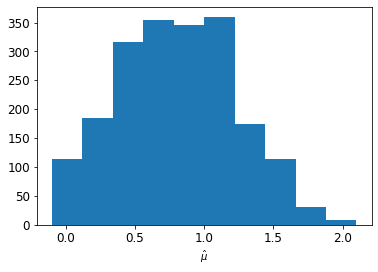

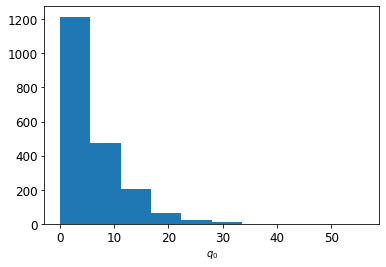

Z BL:(1.9947573199150315, 0.8258486464241244, 1.01425, 1.9951316221019264, 0.7988174259586379)
Z:2.003778690486953
Z_std:1.4431570960139593
Z_1:1.9459631029939937
Z_std_1:1.667861785168728


<Figure size 432x288 with 0 Axes>

In [57]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)
num_pseudo = 2000

Z_BL        = []

Z_MLL        = []
Z_MLL_std    = []
Z_MLL_mu     = []
Z_MLL_std_mu = []

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []
for iloop in range(10):
    
    print(iloop)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    df = pd.DataFrame()


    #np.random.seed(28890)

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
    df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

    df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
    df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

    df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    #df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)
    
    df_test = pd.DataFrame()

    SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

    df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
    df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
    df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
    df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

    df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
    df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
    df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

    df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
    df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
    df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
    df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
    df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

    df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
    df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

    df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
    df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
    df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

    df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
    df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
    #df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

    df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
    df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
    df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])


    df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

    df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

    df_test_array = np.asarray(df_test)
    
    nobs = len(df_array)

    train_size = int(0.80 * nobs)
    val_size   = nobs - train_size #%- test_size 

    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    val_indices   = random_indices[train_size:]
    
    
    X_train        = df_array[train_indices, :22]
    bkg_flag_train = df_array[train_indices, 22]
    y_mon_train    = df_array[train_indices, -1]

    X_test        = df_test_array[:, :22]
    bkg_flag_test = df_test_array[:, 22]
    y_mon_test    = df_test_array[:, -1]

    X_val        = df_array[val_indices, :22]
    bkg_flag_val = df_array[val_indices, 22]
    y_mon_val    = df_array[val_indices, -1]
    
    # to normalize
    x_scaler = preprocessing.MinMaxScaler()
    x_scaler = x_scaler.fit(X_train)

    X_mon_train = x_scaler.transform(X_train)
    X_mon_test  = x_scaler.transform(X_test)
    X_mon_val   = x_scaler.transform(X_val)
    
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators  = 500,
        learning_rate = 0.1,
        reg_lambda    = 0.0, reg_alpha = 0.0,
        early_stopping_rounds = 50,#early stopping
        eval_metric = 'logloss',
        gamma = 0.0, objective = 'binary:logistic',
        max_depth = 5)

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  = False)

    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
    auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
    auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
    auc_total.append( auc(fpr_total, tpr_total) )
    
    
    print('AUC:' + str(auc_total[iloop]))
    
    Z_BL.append( BL_test_fast('discovery', pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, 5, linear_bins=True) )

    
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    print(np.min(pB_B_data))
    pB_B_data[np.where(pB_B_data == 0 )[0]] = np.min(pB_B_data[np.where(pB_B_data > 0 )[0]])
    pS_B_data[np.where(pS_B_data == 0 )[0]] = np.min(pS_B_data[np.where(pS_B_data > 0 )[0]])
    print(np.min(pB_B_data))

    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    print(np.min(pB_S_data))
    pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
    pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
    print(np.min(pB_S_data))

    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(2000)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])


        if np.min(prob_x_given_B) == 0:
            print('There are events with p(s)=0')
            prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])

        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )
    
    plt.hist(np.asarray(muhat_selected_MLL_list))
    plt.xlabel(r'$\hat{\mu}$')
    plt.savefig('../graph/BP' + str(bp+1) + '/muhat_hist_' + str(iloop) + '_MET200.pdf')
    plt.show()
    plt.clf()
    
    plt.hist(np.asarray(q_muhat_MLL))
    plt.xlabel(r'$q_{0}$')
    plt.savefig('../graph/BP' + str(bp+1) + '/q0_hist_' + str(iloop) + '_MET200.pdf')
    plt.show()
    plt.clf()
    print('Z BL:' + str(Z_BL[iloop]))
    print('Z:' + str(Z_MLL[iloop]))
    print('Z_std:' + str(Z_MLL_std[iloop]))
    print('Z_1:' + str(Z_MLL_mu[iloop]))
    print('Z_std_1:' + str(Z_MLL_std_mu[iloop]))

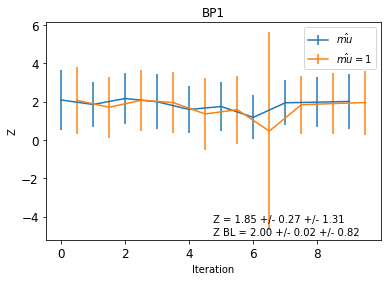

In [58]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.text(0.5,0.08, 'Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(Z_MLL_std)),
         transform = plt.gca().transAxes)
plt.text(0.5,0.02, 'Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])), transform = plt.gca().transAxes)
plt.title('BP' + str(bp+1))
plt.xlabel('Iteration')
plt.savefig('../graph/loopBP' + str(bp+1) + '_50000_MLLvariable_MET200_new.pdf')

In [59]:
Z_MLL

[2.0802619545476064,
 1.8471886026498379,
 2.1570617093400526,
 1.9857291441675442,
 1.586271515978786,
 1.7392679460370968,
 1.1744621846045868,
 1.934748450140421,
 1.9668634074841713,
 2.003778690486953]

In [63]:
Z_MLL_std

[1.5827623502436199,
 1.1672146240944818,
 1.3381716900470066,
 1.4405943715645209,
 1.2402455708504445,
 1.2943193356877225,
 1.14533738796858,
 1.1778409682811117,
 1.317378933385271,
 1.4431570960139593]

In [60]:
np.asarray(Z_BL)[:,0]

array([2.05304447, 2.01900455, 2.02198082, 1.98326794, 2.00428253,
       1.99332336, 1.98842175, 1.99378157, 1.96691028, 1.99475732])

In [61]:
print('Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(Z_MLL_std)))
print('Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0]))  + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])) )

Z = 1.85 +/- 0.27 +/- 1.31
Z BL = 2.00 +/- 0.02 +/- 0.82


In [62]:
print('AUC : ' + str(np.mean(np.asarray(auc_total))) + ' +/- ' + str(np.std(np.asarray(auc_total))))

AUC : 0.902556272286034 +/- 0.00042750396771813065
